# Skane
# Bleking

![My Image](./Map-of-Sweden-showing-the-21-administrative-regions-adapted-from-SCB-2007.png)


In [1]:
#importing modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# 1. DATA preprocessing

In [2]:
#Parameters
n=20
starting_week = 10-4 #start week
first_case = 9
T_max = 48 #length of prediction
pv = 0.023 #fraction of infected that are admitted
rho = 7*1/5.1 #latency period
gamma = 7*1/5 #recovery rate
delay = 3 #2.5 #delay from infection to admission

In [3]:
file = pd.read_excel('../data/statistik-covid19-inskrivna_v2.xlsx', sheet_name = "Inskrivna i slutenvård")
data = [['Sthlm',           8, 2389923, 'SE-AB',  6524],
        ['VGR',             9, 1725881,  'SE-O', 23800],
        ['Skåne',          10, 1387650,  'SE-M', 10968],
        ['Östergötland',   11,  467095,  'SE-E', 10559],
        ['Jönköping',      12,  364750,  'SE-F',  8190],
        ['Södermanland',   13,  299101,  'SE-D', 10437],
        ['Uppsala',        14,  387628,  'SE-C',  5427],
        ['Gävleborg',      15,  287660,  'SE-X',  8504],
        ['Västmanland',    16,  277074,  'SE-U',  6075],
        ['Örebro',         17,  305726,  'SE-T', 28029],
        ['Norrbotten',     18,  249768, 'SE-BD', 18118],
        ['Dalarna',        19,  287806,  'SE-W', 17519],
        ['Västernorrland', 20,  244855,  'SE-Y',  5118],
        ['Värmland',       21,  282840,  'SE-S', 54665],
        ['Halland',        22,  336132,  'SE-N', 97239],
        ['Kalmar',         23,  245992,  'SE-H', 11165],
        ['Kronoberg',      24,  202163,  'SE-G', 21549],
        ['Västerbotten',   25,  273061,  'SE-AC', 8424],
        ['Jämtland',       26,  130972,  'SE-Z',  2931],
        ['Blekinge',       27,  159349,  'SE-K', 48935],
        ['Gotland',        28,   60106,  'SE-I',  3135]] 
regions = pd.DataFrame(data, columns = ['region', 'index','population', 'regionkod', 'area']) 
regions['density'] = regions['population']/regions['area']
first_cases = first_case*np.ones(21).astype(int) #week number when first case was recorded
regions['first case'] = first_cases
starting_weeks = first_cases - 3

regions.drop(regions.index[[20]],inplace=True) #remove Gotland


In [4]:
def getData(name, first_case):
    temp = regions.loc[regions['region'] == name] #find the right row
    index = temp['index'].values #find the region index
    N = temp['population'].values[0] #find population size of region
    R = file.iloc[index[0]] 
    R = R.replace(' ', 0) #replace missing data with 0
    R = R.replace('X', 0) 
    R = R.replace('IU', 0) 
    
    ind = np.arange(3, len(R), 2) 
    I = R.iloc[ind].values #extract admissions
    I = I[:-2] #remove last (incomplete) data point
    padding = np.zeros(10 - first_case + 3) 
    I = np.insert(I, 0, padding) 
    veckor = np.arange(0, len(I), 1) #create array of week numbers
    
    return I,veckor,N


#Load Google mobility data
def loadMobility(name, starting_week):
    df = pd.read_csv('../data/2020_SE_Region_Mobility_Report.csv') 
    temp = regions.loc[regions['region'] == name] 
    code = temp['regionkod'].values 
    temp2 = df.loc[df['iso_3166_2_code'] == code[0]]
    transit = temp2['transit_stations_percent_change_from_baseline'].values 
    dagar = np.arange(46, 46 + len(transit))
    tv = np.ceil(dagar / 7)
    
    
    gveckor = np.unique(tv)
    k = 0
    Tr = np.zeros(int(max(gveckor) - min(gveckor))+1)

    for i in gveckor:
        ind=tv==i
        Tr[k]=np.mean(transit[ind])/100
        k=k+1
    for i in range(1,len(Tr)):
        if np.isnan(Tr[i]):
            Tr[i]=Tr[i-1]
    #print(Tr)
    init=0.2 #set base line travel
    Tr[0:2]=[init,init]
    #print(Tr)
    #print(gveckor)
    #print(gveckor-svecka)
    Trfkn = interp1d(gveckor-starting_week, Tr, kind = "linear", fill_value = "extrapolate")
    #print(Tr)
    return Trfkn

In [5]:
def loadMobility_list(name_list, starting_week):
    Trfkn_dict = dict()
    for i in name_list:
       Trfkn_dict[i] = loadMobility(i, starting_week) 
    return Trfkn_dict


def getData_list(name_list, first_case):
    getData_dict = dict()
    for i in name_list:
        I, veckor, N = getData(i, first_case)
        getData_dict[i] =  {'I': I, 'veckor': veckor, 'N': N}
    return getData_dict

# 2. Correlation Analysis

In [6]:
name_list = regions.region.tolist()
Trfkn_dict = loadMobility_list(name_list, starting_week = 6) 
getData_dict = getData_list(name_list, first_case = 9) 

In [7]:
region_name = ['Sthlm']
df = pd.DataFrame(getData_dict[region_name[0]]['I'])/regions[regions.region == region_name[0]].density.values

for j in getData_dict.keys():
    if j == region_name[0]:
        continue
    region_name.append(j)
    df_temp = pd.DataFrame(getData_dict[j]['I'])
  
    df_temp = df_temp/regions[regions.region ==j].density.values
    df = pd.concat([df,df_temp], axis = 1)
 

In [8]:
df.columns = region_name
df.head()

,Sthlm,VGR,Skåne,Östergötland,Jönköping,Södermanland,Uppsala,Gävleborg,Västmanland,Örebro,Norrbotten,Dalarna,Västernorrland,Värmland,Halland,Kalmar,Kronoberg,Västerbotten,Jämtland,Blekinge
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.101002,0.124111,0.0,0.0,0.0,0.0,0.056002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df.corr()

,Sthlm,VGR,Skåne,Östergötland,Jönköping,Södermanland,Uppsala,Gävleborg,Västmanland,Örebro,Norrbotten,Dalarna,Västernorrland,Värmland,Halland,Kalmar,Kronoberg,Västerbotten,Jämtland,Blekinge
Sthlm,1.000000,0.843206,0.707943,0.968330,0.911792,0.912002,0.906437,0.851443,0.919852,0.608364,0.916373,0.942713,0.767337,0.609362,0.797345,0.845498,0.634756,0.777421,0.834126,0.277613
VGR,0.843206,1.000000,0.887548,0.728929,0.583918,0.913086,0.903484,0.892073,0.902264,0.570380,0.880070,0.705631,0.886026,0.854733,0.793608,0.925145,0.855745,0.805349,0.664991,0.540573
Skåne,0.707943,0.887548,1.000000,0.621677,0.400992,0.826470,0.836551,0.770706,0.844795,0.357385,0.694584,0.537343,0.825453,0.701450,0.634010,0.837116,0.895035,0.708041,0.714445,0.703238
Östergötland,0.968330,0.728929,0.621677,1.000000,0.949446,0.843867,0.836592,0.758317,0.858380,0.558964,0.861616,0.937252,0.634197,0.456047,0.695051,0.749121,0.519094,0.666688,0.848179,0.214819
Jönköping,0.911792,0.583918,0.400992,0.949446,1.000000,0.742007,0.728714,0.634586,0.728252,0.546562,0.769218,0.934666,0.496379,0.328326,0.611534,0.626122,0.309441,0.592080,0.726492,0.029500
Södermanland,0.912002,0.913086,0.826470,0.843867,0.742007,1.000000,0.935397,0.890879,0.919812,0.666803,0.861836,0.819782,0.839591,0.734929,0.810330,0.888893,0.747598,0.818094,0.757545,0.496441
Uppsala,0.906437,0.903484,0.836551,0.836592,0.728714,0.935397,1.000000,0.834167,0.951433,0.563244,0.822067,0.805795,0.879517,0.724591,0.791194,0.910907,0.725122,0.833061,0.812731,0.496166
Gävleborg,0.851443,0.892073,0.770706,0.758317,0.634586,0.890879,0.834167,1.000000,0.888467,0.611241,0.894599,0.780226,0.822392,0.799760,0.880823,0.863245,0.827918,0.790691,0.698229,0.388709
Västmanland,0.919852,0.902264,0.844795,0.858380,0.728252,0.919812,0.951433,0.888467,1.000000,0.591124,0.874052,0.816632,0.876964,0.703475,0.832255,0.882670,0.768168,0.795805,0.850684,0.471452
Örebro,0.608364,0.570380,0.357385,0.558964,0.546562,0.666803,0.563244,0.611241,0.591124,1.000000,0.661141,0.610308,0.579358,0.611706,0.725711,0.523089,0.391109,0.514327,0.427815,0.262842


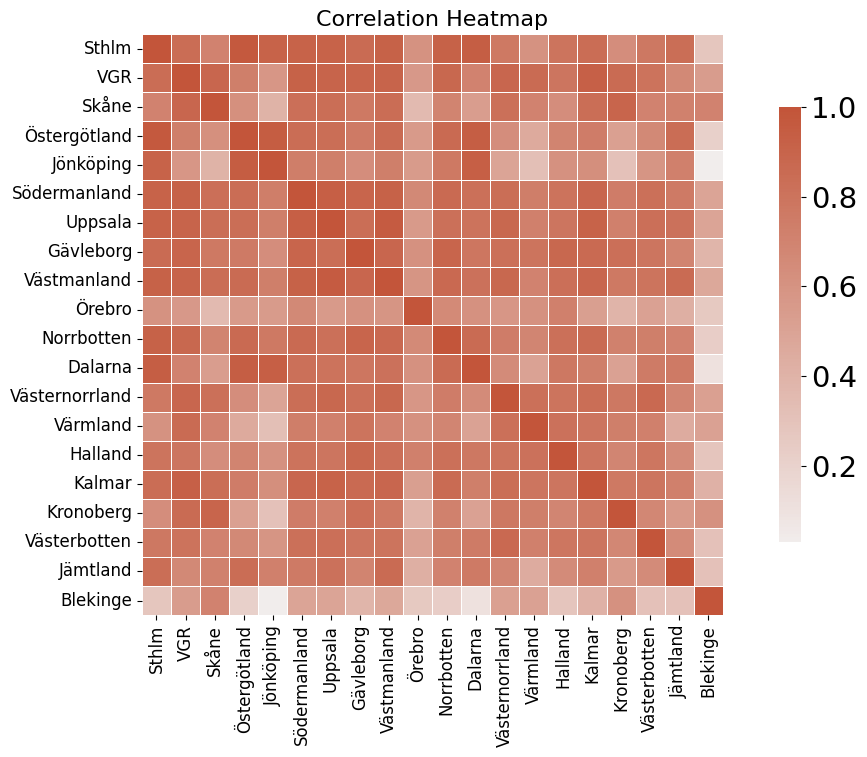

In [10]:
import seaborn as sns


corr = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(
    corr,
    cmap=cmap,
           # show correlation coefficients
    fmt=".2f",        # format for annotations
    linewidths=0.5,   # space between cells
    square=True,      # keep the cells square
    cbar_kws={"shrink": 0.75},  # color bar size
    center=0   ,
    annot_kws={"size": 8}       # center the colormap at zero
)

# Add title and tweak layout
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("../data/correlation_heatmap.svg", format="svg")

# Display the plot
plt.show()

In [11]:
df_Sthlm = pd.DataFrame(df.corr().loc['Sthlm']).sort_values(by = 'Sthlm', ascending=False)
df_Sthlm

,Sthlm
Sthlm,1.000000
Östergötland,0.968330
Dalarna,0.942713
Västmanland,0.919852
Norrbotten,0.916373
Södermanland,0.912002
Jönköping,0.911792
Uppsala,0.906437
Gävleborg,0.851443
Kalmar,0.845498


In [12]:
df_Skåne= pd.DataFrame(df.corr().loc['Skåne']).sort_values(by = 'Skåne', ascending=False)
df_Skåne

,Skåne
Skåne,1.000000
Kronoberg,0.895035
VGR,0.887548
Västmanland,0.844795
Kalmar,0.837116
Uppsala,0.836551
Södermanland,0.826470
Västernorrland,0.825453
Gävleborg,0.770706
Jämtland,0.714445


In [13]:
df_Uppsala= pd.DataFrame(df.corr().loc['Uppsala']).sort_values(by = 'Uppsala', ascending=False)
df_Uppsala

,Uppsala
Uppsala,1.000000
Västmanland,0.951433
Södermanland,0.935397
Kalmar,0.910907
Sthlm,0.906437
VGR,0.903484
Västernorrland,0.879517
Östergötland,0.836592
Skåne,0.836551
Gävleborg,0.834167


# 3. Modeling

#### S[Sthlm]=x0      

#### E[Sthlm]=x1       

#### I[Sthlm]=x2       

#### R[Sthlm]=x3

#### S[Södermanland]=x4      

#### E[Södermanland]=x5       

#### I[Södermanland]=x6       

#### R[Södermanland]=x7

In [14]:
name_list = ['Kalmar', 'Blekinge']
transit_fkn_dct = loadMobility_list(name_list, starting_week = 6) 
getData_dict = getData_list(name_list, first_case = 9) 
region_0 = name_list[0]
region_1 = name_list[1]
I_train = [getData_dict[name_list[0]]['I'],
           getData_dict[name_list[1]]['I']]
weeks_train = getData_dict[region_0]['veckor'] 

def beta(t, a, b, transit_fkn):
    return a + b * transit_fkn(t)

def dx(x, t, N, a, b, c, lag):
    S0, E0, I0, R0, S1, E1, I1, R1 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]

    dS0 =  - S0 * (beta(t-lag, a[0], b[0], transit_fkn_dct[region_0]) * I0/N[0] + c*I1/N[1])
    dS1 =  - S1 * (beta(t-lag, a[1], b[1], transit_fkn_dct[region_1]) * I1/N[1] + c*I0/N[0])
    dE0 =    S0 * (beta(t-lag, a[0], b[0], transit_fkn_dct[region_0]) * I0/N[0] + c*I1/N[1]) - rho*E0
    dE1 =    S1 * (beta(t-lag, a[1], b[1], transit_fkn_dct[region_1]) * I1/N[1] + c*I0/N[0]) - rho*E1
    dI0 =  rho*E0 - gamma*I0
    dI1 =  rho*E1 - gamma*I1
    dR0 =  gamma*I0
    dR1 =  gamma*I1

    return [dS0, dE0, dI0, dR0,
            dS1, dE1, dI1, dR1]

def pred_inlagda(t, a1, b1, a2, b2, c, lag):
    N = [getData_dict[name_list[0]]['N'],
         getData_dict[name_list[1]]['N']]
    x0 = [N[0]-1, 0, 1, 0,
          N[1]-1, 0, 1, 0] #initial conditions
    x = odeint(dx, x0, t, args=(N, [a1, a2], [b1, b2], c, lag))
    return pv*x[:, [2, 6]]

In [15]:
getData_dict

{'Kalmar': {'I': array([0.0, 0.0, 0.0, 0.0, 0, 0, 9, 10, 20, 24, 26, 28, 35, 26, 22, 7, 15,
         12, 20, 19, 7, 8, 7, 5, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 4,
         8, 15, 23, 24, 24, 33, 25], dtype=object),
  'veckor': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
  'N': 245992},
 'Blekinge': {'I': array([0.0, 0.0, 0.0, 0.0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 4, 5, 10, 6, 17, 8,
         13, 0, 5, 0, 4, 0, 5, 0, 6, 5, 0, 0, 0, 0, 4, 7, 4, 0, 4, 7, 7, 12,
         9, 9, 13, 29], dtype=object),
  'veckor': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
  'N': 159349}}

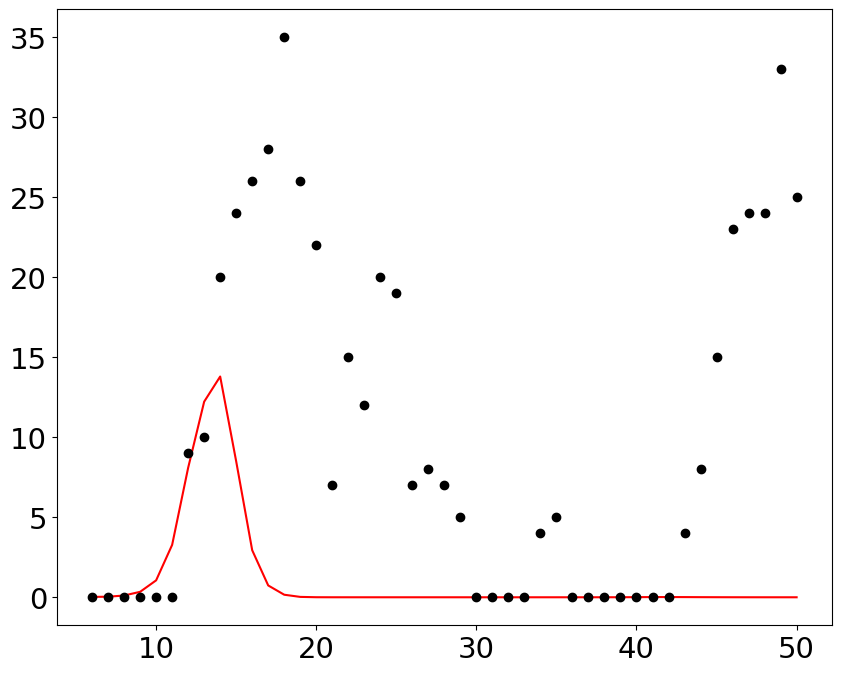

In [16]:
a = [2.380262, 1.729996 ] 
b = [11.197420, 1.387774] 
c = 0
P = pred_inlagda(weeks_train, a[0], b[0], a[1], b[1], c, delay)
fig, axes = plt.subplots(1, 1, figsize = (10, 8))
axes.plot(weeks_train+6, P[:,0], 'r', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[0], 'ko', label = "Inlagda")


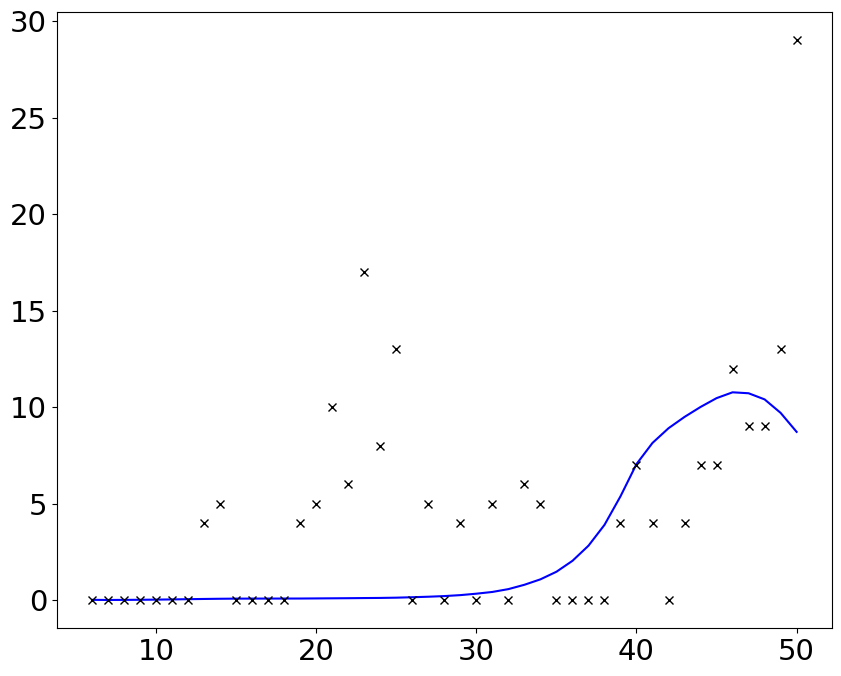

In [17]:
fig, axes = plt.subplots(1, 1, figsize = (10, 8))

axes.plot(weeks_train+6, P[:,1], 'b', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[1], 'kx', label = "Inlagda")

In [18]:
def return_RMSE(P, I):
    return np.sqrt(np.mean((P - I)**2))

def return_CV_RMSE(P, I):
    return 100 * return_RMSE(P, I) / np.mean(I)

In [19]:
print(return_RMSE(P[:,0], I_train[0]))
print(return_RMSE(P[:,1], I_train[1]))
print(return_CV_RMSE(P[:,0], I_train[0]))
print(return_CV_RMSE(P[:,1], I_train[1]))

14.181747239381641
5.643517502542591
137.24271521982232
125.72192456159236


In [20]:
#!pip install wandb


In [21]:
from tqdm import tqdm

name_list = ['Kalmar', 'Blekinge']
transit_fkn_dict = loadMobility_list(name_list, starting_week) 
getData_dict = getData_list(name_list, first_case)

I_train = [getData_dict[name_list[0]]['I'],
           getData_dict[name_list[1]]['I']]
weeks_train = getData_dict[name_list[0]]['veckor']  # getData_dict['Södermanland']['veckor'] == getData_dict['Sthlm']['veckor']

n=3
ah0 = np.linspace(3,10,n)
bh0 = np.linspace(4,10,n)
ah1 = np.linspace(3,10,n)
bh1 = np.linspace(4,10,n)
c = np.linspace(0,0.2,n)

E_rmse0 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))
E_rmse1 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))

E_cv_rmse0 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))
E_cv_rmse1 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))

for i in tqdm(range(n)):
    for j in range(n):
        for k in range(n):
            for l in range(n): 
                for m in range(n):
                    P = pred_inlagda(weeks_train, ah0[i], bh0[j], ah1[k], bh1[l], c[m], delay)
                    
                    # Store the results in the arrays (instead of RMSE)
                    E_rmse0[i,j,k,l,m] = return_RMSE(P[:,0], I_train[0])
                    E_rmse1[i,j,k,l,m] = return_RMSE(P[:,1], I_train[1])  

                    # Store the results in the arrays (instead of cv-rms)
                    E_cv_rmse0[i, j, k, l, m] = return_CV_RMSE(P[:,0], I_train[0]) 
                    E_cv_rmse1[i, j, k, l, m] = return_CV_RMSE(P[:,1], I_train[1])

                                

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 10.85s/it]


In [24]:
sweep_config = {
    'method': 'bayes'
    }

In [25]:
metric = {
    'name': 'CV_RMSE',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [26]:
parameters_dict = {
    "ah0": {
        "min": 0,
        "max": 3,
        "distribution": "uniform"
    },
    "bh0": {
        "min": 0,
        "max": 15,
        "distribution": "uniform"
    },
    "ah1": {
        "min": 0,
        "max": 3,
        "distribution": "uniform"
    },
    "bh1": {
        "min": 0,
        "max": 15,
        "distribution": "uniform"
    },
    "c": {
        "min": 0,
        "max": 2,
        "distribution": "uniform"
    }
}

sweep_config['parameters'] = parameters_dict


In [27]:
import pprint
pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'CV_RMSE'},
 'parameters': {'ah0': {'distribution': 'uniform', 'max': 3, 'min': 0},
                'ah1': {'distribution': 'uniform', 'max': 3, 'min': 0},
                'bh0': {'distribution': 'uniform', 'max': 15, 'min': 0},
                'bh1': {'distribution': 'uniform', 'max': 15, 'min': 0},
                'c': {'distribution': 'uniform', 'max': 2, 'min': 0}}}


In [28]:
import wandb


In [29]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-SEIR_kalmar_bleking")

Create sweep with ID: 1im3f1kp
Sweep URL: https://wandb.ai/danish2562022/sweeps-SEIR_kalmar_bleking/sweeps/1im3f1kp


In [30]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms


def fit_model(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        P = pred_inlagda(weeks_train, config.ah0, config.bh0, config.ah1, config.bh1, config.c, delay)
        CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
        CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
        CV_RMSE = CV_RMSE_1 + CV_RMSE_2
        RMSE_1 = return_RMSE(P[:,0], I_train[0])
        RMSE_2 = return_RMSE(P[:,1], I_train[1])
        RMSE = RMSE_1 + RMSE_2
        wandb.log({"CV_RMSE": CV_RMSE, "RMSE": RMSE,  "RMSE_Kalmar": RMSE_1,  "RMSE_Blekinge": RMSE_2,  "CV_RMSE_'Kalmar": CV_RMSE_1,  "CV_RMSE_Blekinge": CV_RMSE_2})  

In [ ]:
wandb.agent(sweep_id,fit_model, count=10000)

wandb: Agent Starting Run: 02hmw27q with config:
wandb: 	ah0: 0.15112098057751566
wandb: 	ah1: 0.7574895283390225
wandb: 	bh0: 14.923391868691196
wandb: 	bh1: 10.417584523001302
wandb: 	c: 0.7366664501942604
wandb: Currently logged in as: danish2562022. Use `wandb login --relogin` to force relogin


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.53225
CV_RMSE_'Kalmar,144.23157
CV_RMSE_Blekinge,161.30067
RMSE,22.14454
RMSE_Blekinge,7.24061


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iue41vgk with config:
wandb: 	ah0: 1.8114381830124575
wandb: 	ah1: 2.224428405949792
wandb: 	bh0: 12.826870206673584
wandb: 	bh1: 2.6352030528753883
wandb: 	c: 0.8725689798822811


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,3059.81918
CV_RMSE_'Kalmar,1481.47488
CV_RMSE_Blekinge,1578.34429
RMSE,223.93586
RMSE_Blekinge,70.85012


wandb: Agent Starting Run: bo0jss5q with config:
wandb: 	ah0: 1.4230718905949529
wandb: 	ah1: 2.2798244213531116
wandb: 	bh0: 0.7102241565132894
wandb: 	bh1: 14.504179210044745
wandb: 	c: 1.3234090134413945


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,2549.27684
CV_RMSE_'Kalmar,975.16768
CV_RMSE_Blekinge,1574.10916
RMSE,171.42734
RMSE_Blekinge,70.66001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nf9hxrrc with config:
wandb: 	ah0: 0.48268947386087013
wandb: 	ah1: 1.5434417289790694
wandb: 	bh0: 3.0159714819169343
wandb: 	bh1: 12.204802457825
wandb: 	c: 0.100679281630208


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.86621
CV_RMSE_'Kalmar,144.64618
CV_RMSE_Blekinge,162.22003
RMSE,22.22865
RMSE_Blekinge,7.28188


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r9lxt8dd with config:
wandb: 	ah0: 2.1615497680893063
wandb: 	ah1: 2.6527893093795787
wandb: 	bh0: 13.054605585722838
wandb: 	bh1: 4.55379497677862
wandb: 	c: 0.185853552938267


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,4075.36141
CV_RMSE_'Kalmar,2110.45356
CV_RMSE_Blekinge,1964.90785
RMSE,306.28273
RMSE_Blekinge,88.20253


wandb: Agent Starting Run: d0a4k5k2 with config:
wandb: 	ah0: 0.008001884083109645
wandb: 	ah1: 0.9028115160947852
wandb: 	bh0: 12.061856942979412
wandb: 	bh1: 14.061666050740005
wandb: 	c: 0.5663759201658387


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.34002
CV_RMSE_'Kalmar,144.215
CV_RMSE_Blekinge,161.12503
RMSE,22.13494
RMSE_Blekinge,7.23272


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e99rmo9o with config:
wandb: 	ah0: 0.20226782863825443
wandb: 	ah1: 0.13539085464089506
wandb: 	bh0: 9.264139429334648
wandb: 	bh1: 10.009950589271948
wandb: 	c: 0.40436242902856834


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.88471
CV_RMSE_'Kalmar,144.98607
CV_RMSE_Blekinge,161.89864
RMSE,22.24934
RMSE_Blekinge,7.26745


wandb: Agent Starting Run: kjpevvgj with config:
wandb: 	ah0: 0.3604512840662773
wandb: 	ah1: 0.7700773705874863
wandb: 	bh0: 4.346579245916005
wandb: 	bh1: 14.901353238068909
wandb: 	c: 0.05408782514332766


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.43588
CV_RMSE_'Kalmar,144.96938
CV_RMSE_Blekinge,161.46651
RMSE,22.22822
RMSE_Blekinge,7.24805


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qed2iuxx with config:
wandb: 	ah0: 0.00863178356195704
wandb: 	ah1: 0.6878906218604129
wandb: 	bh0: 1.8458463433224748
wandb: 	bh1: 11.874095385365166
wandb: 	c: 0.18198804593459503


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.72914
CV_RMSE_'Kalmar,144.97727
CV_RMSE_Blekinge,161.75187
RMSE,22.24185
RMSE_Blekinge,7.26086


wandb: Agent Starting Run: lbxd6wdn with config:
wandb: 	ah0: 0.024220928226829863
wandb: 	ah1: 0.005585486079364044
wandb: 	bh0: 13.773144740192386
wandb: 	bh1: 7.718013677653422
wandb: 	c: 1.6753392478795956


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.05854
CV_RMSE_'Kalmar,142.9645
CV_RMSE_Blekinge,161.09404
RMSE,22.00433
RMSE_Blekinge,7.23133


wandb: Agent Starting Run: cuy5ja0f with config:
wandb: 	ah0: 0.1251795009876956
wandb: 	ah1: 0.1217265703223286
wandb: 	bh0: 12.149041299712726
wandb: 	bh1: 11.409604091082812
wandb: 	c: 0.7357318431049102


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.47955
CV_RMSE_'Kalmar,144.74512
CV_RMSE_Blekinge,161.73443
RMSE,22.21707
RMSE_Blekinge,7.26008


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q5i41lco with config:
wandb: 	ah0: 0.17267628993976447
wandb: 	ah1: 1.187178850719146
wandb: 	bh0: 5.130061402861237
wandb: 	bh1: 10.448587964123549
wandb: 	c: 0.16584616465799318


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.47394
CV_RMSE_'Kalmar,144.92845
CV_RMSE_Blekinge,161.54549
RMSE,22.22754
RMSE_Blekinge,7.2516


wandb: Agent Starting Run: i91whgi3 with config:
wandb: 	ah0: 0.1319537035075814
wandb: 	ah1: 0.4698570179739825
wandb: 	bh0: 14.154692902904303
wandb: 	bh1: 13.796646369265234
wandb: 	c: 0.3056180958842931


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.40857
CV_RMSE_'Kalmar,144.77182
CV_RMSE_Blekinge,161.63675
RMSE,22.21545
RMSE_Blekinge,7.25569


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gw2hz2w2 with config:
wandb: 	ah0: 0.04545269396339935
wandb: 	ah1: 0.13006731111235093
wandb: 	bh0: 10.045085362615742
wandb: 	bh1: 4.512698869591419
wandb: 	c: 0.9207589382530356


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.81969
CV_RMSE_'Kalmar,144.94102
CV_RMSE_Blekinge,161.87867
RMSE,22.24379
RMSE_Blekinge,7.26655


wandb: Agent Starting Run: 5ak56cmw with config:
wandb: 	ah0: 0.05521384558435927
wandb: 	ah1: 0.19072095853151727
wandb: 	bh0: 13.379828484550098
wandb: 	bh1: 1.974460647639339
wandb: 	c: 1.2637187922920108


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.86552
CV_RMSE_'Kalmar,144.45978
CV_RMSE_Blekinge,161.40575
RMSE,22.17284
RMSE_Blekinge,7.24532


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lgdfy3z0 with config:
wandb: 	ah0: 0.026357716771349016
wandb: 	ah1: 1.48357439501677
wandb: 	bh0: 0.8467561252861999
wandb: 	bh1: 14.665958582816508
wandb: 	c: 0.013994806566618225


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.95631
CV_RMSE_'Kalmar,144.94435
CV_RMSE_Blekinge,160.01197
RMSE,22.16034
RMSE_Blekinge,7.18276


wandb: Agent Starting Run: bfo8txgb with config:
wandb: 	ah0: 0.057358174000432194
wandb: 	ah1: 0.27854079078966565
wandb: 	bh0: 0.2055445136477302
wandb: 	bh1: 2.5410299447182068
wandb: 	c: 0.23323531668415945


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98806
CV_RMSE_'Kalmar,145.04604
CV_RMSE_Blekinge,161.94202
RMSE,22.25749
RMSE_Blekinge,7.2694


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: if0q6pke with config:
wandb: 	ah0: 0.16638106032279143
wandb: 	ah1: 0.29932479838874015
wandb: 	bh0: 14.870787636339813
wandb: 	bh1: 6.234020782601025
wandb: 	c: 0.12514111837423547


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.83652
CV_RMSE_'Kalmar,144.91799
CV_RMSE_Blekinge,161.91853
RMSE,22.2432
RMSE_Blekinge,7.26834


wandb: Agent Starting Run: kacakxle with config:
wandb: 	ah0: 0.14228666568172477
wandb: 	ah1: 0.021454897689197172
wandb: 	bh0: 5.927887949406488
wandb: 	bh1: 1.6804177021520768
wandb: 	c: 0.2235561577207947


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98536
CV_RMSE_'Kalmar,145.04356
CV_RMSE_Blekinge,161.9418
RMSE,22.25722
RMSE_Blekinge,7.26939


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xv9pzf8p with config:
wandb: 	ah0: 0.03594423029522442
wandb: 	ah1: 0.17409130663340056
wandb: 	bh0: 4.605294293744136
wandb: 	bh1: 6.559244433518799
wandb: 	c: 0.026889263103514027


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98515
CV_RMSE_'Kalmar,145.04571
CV_RMSE_Blekinge,161.93944
RMSE,22.25734
RMSE_Blekinge,7.26928


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 85211724 with config:
wandb: 	ah0: 0.1350429382807864
wandb: 	ah1: 0.22737207197727585
wandb: 	bh0: 14.161332593096402
wandb: 	bh1: 8.558177209975588
wandb: 	c: 0.2808376369438099


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.80432
CV_RMSE_'Kalmar,144.91764
CV_RMSE_Blekinge,161.88669
RMSE,22.24174
RMSE_Blekinge,7.26691


wandb: Agent Starting Run: nw1do46w with config:
wandb: 	ah0: 0.15880468101879075
wandb: 	ah1: 0.05420862301169005
wandb: 	bh0: 14.43081609675297
wandb: 	bh1: 4.065795940743403
wandb: 	c: 0.19068777270270745


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.85729
CV_RMSE_'Kalmar,144.93534
CV_RMSE_Blekinge,161.92195
RMSE,22.24515
RMSE_Blekinge,7.2685


wandb: Agent Starting Run: frd1l83f with config:
wandb: 	ah0: 0.06557950606582508
wandb: 	ah1: 0.43288224633286887
wandb: 	bh0: 10.923178971280194
wandb: 	bh1: 10.10896965500192
wandb: 	c: 0.04106188757095652


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.92057
CV_RMSE_'Kalmar,145.02374
CV_RMSE_Blekinge,161.89683
RMSE,22.25316
RMSE_Blekinge,7.26737


wandb: Agent Starting Run: 2qdbuv6f with config:
wandb: 	ah0: 0.055121498888044074
wandb: 	ah1: 0.17851179605414114
wandb: 	bh0: 14.155199714558895
wandb: 	bh1: 7.927532989728407
wandb: 	c: 1.0112123743314667


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.09785
CV_RMSE_'Kalmar,144.51254
CV_RMSE_Blekinge,161.58531
RMSE,22.18635
RMSE_Blekinge,7.25338


wandb: Agent Starting Run: elx377au with config:
wandb: 	ah0: 0.010304682388126762
wandb: 	ah1: 0.7585367180942891
wandb: 	bh0: 6.873802571779144
wandb: 	bh1: 14.767384696843171
wandb: 	c: 0.12679683358596305


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.39431
CV_RMSE_'Kalmar,144.9263
CV_RMSE_Blekinge,161.46802
RMSE,22.22384
RMSE_Blekinge,7.24812


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fwqz10ew with config:
wandb: 	ah0: 0.1315472254815249
wandb: 	ah1: 0.029698395686644563
wandb: 	bh0: 4.171453394674565
wandb: 	bh1: 0.18986957959281847
wandb: 	c: 1.0517353540733545


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.95198
CV_RMSE_'Kalmar,145.02133
CV_RMSE_Blekinge,161.93065
RMSE,22.25442
RMSE_Blekinge,7.26889


wandb: Agent Starting Run: qoxmwlun with config:
wandb: 	ah0: 0.036147729299119025
wandb: 	ah1: 0.11204618334539128
wandb: 	bh0: 14.876708280002374
wandb: 	bh1: 8.501026318977743
wandb: 	c: 0.6940049241752781


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.51668
CV_RMSE_'Kalmar,144.75703
CV_RMSE_Blekinge,161.75965
RMSE,22.21944
RMSE_Blekinge,7.26121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u6z3zwtt with config:
wandb: 	ah0: 0.006447291762054386
wandb: 	ah1: 1.0468241741932591
wandb: 	bh0: 2.835042770945453
wandb: 	bh1: 10.03934249365122
wandb: 	c: 0.05470807823069124


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.72985
CV_RMSE_'Kalmar,145.0237
CV_RMSE_Blekinge,161.70616
RMSE,22.24459
RMSE_Blekinge,7.25881


wandb: Agent Starting Run: efrbli7o with config:
wandb: 	ah0: 0.3264053593020375
wandb: 	ah1: 0.3602921436403951
wandb: 	bh0: 14.68675437029184
wandb: 	bh1: 14.153862630660948
wandb: 	c: 1.2498019678844812


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.04633
CV_RMSE_'Kalmar,141.69832
CV_RMSE_Blekinge,161.34802
RMSE,21.88489
RMSE_Blekinge,7.24273


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mw52pb9g with config:
wandb: 	ah0: 0.8997457212797481
wandb: 	ah1: 0.009262758750513744
wandb: 	bh0: 0.3146874857761178
wandb: 	bh1: 8.786009641999375
wandb: 	c: 0.06035356571141981


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.97483
CV_RMSE_'Kalmar,145.03844
CV_RMSE_Blekinge,161.93639
RMSE,22.25645
RMSE_Blekinge,7.26914


wandb: Agent Starting Run: bavey77w with config:
wandb: 	ah0: 0.07018193341300316
wandb: 	ah1: 0.2903708111132407
wandb: 	bh0: 14.105684759702502
wandb: 	bh1: 12.617339597559118
wandb: 	c: 1.7671557700472489


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.97746
CV_RMSE_'Kalmar,145.03872
CV_RMSE_Blekinge,161.93875
RMSE,22.25658
RMSE_Blekinge,7.26925


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a87a08v6 with config:
wandb: 	ah0: 0.05823994777890107
wandb: 	ah1: 0.029191542502760903
wandb: 	bh0: 14.254448380875845
wandb: 	bh1: 1.9450339405401555
wandb: 	c: 1.8857087512965365


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,2147.57538
CV_RMSE_'Kalmar,888.99411
CV_RMSE_Blekinge,1258.58128
RMSE,148.35904
RMSE_Blekinge,56.49632


wandb: Agent Starting Run: 39ruandi with config:
wandb: 	ah0: 0.046518195240110805
wandb: 	ah1: 0.6191277925604445
wandb: 	bh0: 10.20720352113645
wandb: 	bh1: 0.2552833906511742
wandb: 	c: 0.5585627923006753


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.91566
CV_RMSE_'Kalmar,145.0044
CV_RMSE_Blekinge,161.91126
RMSE,22.25181
RMSE_Blekinge,7.26802


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3o5dxjud with config:
wandb: 	ah0: 0.11269297972879656
wandb: 	ah1: 0.018287303677450018
wandb: 	bh0: 11.312267391081813
wandb: 	bh1: 11.938579496573071
wandb: 	c: 1.5946961497711638


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.82315
CV_RMSE_'Kalmar,142.6807
CV_RMSE_Blekinge,161.14245
RMSE,21.97718
RMSE_Blekinge,7.23351


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8t56vwu5 with config:
wandb: 	ah0: 0.5228772433195273
wandb: 	ah1: 0.04533551182869633
wandb: 	bh0: 10.388606367481112
wandb: 	bh1: 0.2115044809418359
wandb: 	c: 0.7935534941098459


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.73118
CV_RMSE_'Kalmar,144.86501
CV_RMSE_Blekinge,161.86617
RMSE,22.23538
RMSE_Blekinge,7.26599


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hcggd3ae with config:
wandb: 	ah0: 0.08851433247473262
wandb: 	ah1: 0.4476009151014603
wandb: 	bh0: 12.97481736705607
wandb: 	bh1: 0.17575522805186206
wandb: 	c: 0.7930810239594006


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.64203
CV_RMSE_'Kalmar,144.85832
CV_RMSE_Blekinge,161.7837
RMSE,22.23098
RMSE_Blekinge,7.26229


wandb: Agent Starting Run: qezup6rv with config:
wandb: 	ah0: 0.314894142869094
wandb: 	ah1: 0.0878280113321761
wandb: 	bh0: 1.003930505843853
wandb: 	bh1: 14.484130449415174
wandb: 	c: 0.4749802282932376


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.58145
CV_RMSE_'Kalmar,144.82183
CV_RMSE_Blekinge,161.75963
RMSE,22.22613
RMSE_Blekinge,7.26121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5rx9g846 with config:
wandb: 	ah0: 0.11329122409440828
wandb: 	ah1: 0.30401216568148504
wandb: 	bh0: 12.804550842799864
wandb: 	bh1: 1.3848250587563276
wandb: 	c: 1.102883104526618


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.18773
CV_RMSE_'Kalmar,144.63985
CV_RMSE_Blekinge,161.54788
RMSE,22.19782
RMSE_Blekinge,7.2517


wandb: Agent Starting Run: u1x8vafx with config:
wandb: 	ah0: 1.0357203475116088
wandb: 	ah1: 0.1068152208856088
wandb: 	bh0: 1.8521866535092295
wandb: 	bh1: 14.7263574075858
wandb: 	c: 0.1654269382062259


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.71493
CV_RMSE_'Kalmar,144.63913
CV_RMSE_Blekinge,160.0758
RMSE,22.13167
RMSE_Blekinge,7.18562


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l0j6t5lo with config:
wandb: 	ah0: 0.13128854324311268
wandb: 	ah1: 0.09691936258877264
wandb: 	bh0: 12.24124618927626
wandb: 	bh1: 3.4157701985218436
wandb: 	c: 0.7716273111247871


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.77329
CV_RMSE_'Kalmar,144.90734
CV_RMSE_Blekinge,161.86595
RMSE,22.23974
RMSE_Blekinge,7.26598


wandb: Agent Starting Run: 67jhbqli with config:
wandb: 	ah0: 1.5358449267721546
wandb: 	ah1: 0.039057464336014314
wandb: 	bh0: 1.2077417314727508
wandb: 	bh1: 1.1048758077066272
wandb: 	c: 0.07201098708986375


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.5474
CV_RMSE_'Kalmar,144.63918
CV_RMSE_Blekinge,161.90822
RMSE,22.21393
RMSE_Blekinge,7.26788


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qsr6do8o with config:
wandb: 	ah0: 0.032739625081165014
wandb: 	ah1: 0.18783411191075972
wandb: 	bh0: 12.614054262371006
wandb: 	bh1: 1.1477427330662655
wandb: 	c: 0.06770217517962074


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.95134
CV_RMSE_'Kalmar,145.01143
CV_RMSE_Blekinge,161.93991
RMSE,22.25382
RMSE_Blekinge,7.2693


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jadhahej with config:
wandb: 	ah0: 0.7067134929762324
wandb: 	ah1: 0.08952736734543465
wandb: 	bh0: 1.6644533579332543
wandb: 	bh1: 2.627068067435099
wandb: 	c: 0.3613808812718631


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98086
CV_RMSE_'Kalmar,145.03977
CV_RMSE_Blekinge,161.94109
RMSE,22.2568
RMSE_Blekinge,7.26936


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cyvsplnn with config:
wandb: 	ah0: 1.0546622133335526
wandb: 	ah1: 0.1556771658103041
wandb: 	bh0: 0.5430688726876598
wandb: 	bh1: 0.0972129522788684
wandb: 	c: 0.5429584740042259


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.92465
CV_RMSE_'Kalmar,145.00122
CV_RMSE_Blekinge,161.92343
RMSE,22.25202
RMSE_Blekinge,7.26856


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ivdgtuns with config:
wandb: 	ah0: 0.27321505036177673
wandb: 	ah1: 0.2955436929487931
wandb: 	bh0: 0.5523782360889051
wandb: 	bh1: 0.39827229499058314
wandb: 	c: 0.780213710123494


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.97585
CV_RMSE_'Kalmar,145.03767
CV_RMSE_Blekinge,161.93818
RMSE,22.25645
RMSE_Blekinge,7.26923


wandb: Agent Starting Run: fhqgxh5i with config:
wandb: 	ah0: 0.12060809815773076
wandb: 	ah1: 1.4922503889832304
wandb: 	bh0: 4.42594775841161
wandb: 	bh1: 14.374195619448871
wandb: 	c: 0.040069405095731536


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.43612
CV_RMSE_'Kalmar,144.85191
CV_RMSE_Blekinge,160.58421
RMSE,22.17648
RMSE_Blekinge,7.20845


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ochvwus6 with config:
wandb: 	ah0: 0.7989068393680199
wandb: 	ah1: 0.05907445366375674
wandb: 	bh0: 7.256373879418598
wandb: 	bh1: 14.790372529339862
wandb: 	c: 0.43721628194087536


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.4625
CV_RMSE_'Kalmar,144.69973
CV_RMSE_Blekinge,161.76277
RMSE,22.21366
RMSE_Blekinge,7.26135


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7sgmfgkp with config:
wandb: 	ah0: 0.5427002899496511
wandb: 	ah1: 0.016258402169308184
wandb: 	bh0: 5.06474348945733
wandb: 	bh1: 12.938349554116808
wandb: 	c: 0.3483546339921255


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.83999
CV_RMSE_'Kalmar,144.96017
CV_RMSE_Blekinge,161.87982
RMSE,22.24582
RMSE_Blekinge,7.26661


wandb: Agent Starting Run: fhb594xx with config:
wandb: 	ah0: 0.3272930537368436
wandb: 	ah1: 0.1015074537527212
wandb: 	bh0: 0.05679322464271386
wandb: 	bh1: 0.2264518307583846
wandb: 	c: 0.3324852956601241


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.9885
CV_RMSE_'Kalmar,145.04612
CV_RMSE_Blekinge,161.94238
RMSE,22.25751
RMSE_Blekinge,7.26941


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hwq6ze79 with config:
wandb: 	ah0: 0.2115855632008169
wandb: 	ah1: 0.4772130422668326
wandb: 	bh0: 13.541476121969172
wandb: 	bh1: 9.710792463154146
wandb: 	c: 1.5010888002282683


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.71299
CV_RMSE_'Kalmar,141.75834
CV_RMSE_Blekinge,161.95464
RMSE,21.91833
RMSE_Blekinge,7.26996


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3zo6crqf with config:
wandb: 	ah0: 0.19152785197084887
wandb: 	ah1: 0.3293012524014446
wandb: 	bh0: 0.14343023832530888
wandb: 	bh1: 12.219941647858626
wandb: 	c: 0.006061481753866227


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.91193
CV_RMSE_'Kalmar,145.04509
CV_RMSE_Blekinge,161.86684
RMSE,22.25401
RMSE_Blekinge,7.26602


wandb: Agent Starting Run: s5cirw0e with config:
wandb: 	ah0: 0.017551839930115665
wandb: 	ah1: 0.16415938456931123
wandb: 	bh0: 8.358187244943526
wandb: 	bh1: 14.36880815812858
wandb: 	c: 0.7996110815451338


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.2532
CV_RMSE_'Kalmar,144.623
CV_RMSE_Blekinge,161.63019
RMSE,22.19978
RMSE_Blekinge,7.2554


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g8cxicvw with config:
wandb: 	ah0: 0.29811328589421027
wandb: 	ah1: 0.07200692189844049
wandb: 	bh0: 12.129675708740546
wandb: 	bh1: 9.26573118220661
wandb: 	c: 1.2831131790870989


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.23226
CV_RMSE_'Kalmar,143.88499
CV_RMSE_Blekinge,161.34727
RMSE,22.11082
RMSE_Blekinge,7.2427


wandb: Agent Starting Run: 5e7ek3im with config:
wandb: 	ah0: 0.9327803750606312
wandb: 	ah1: 0.07093854849354408
wandb: 	bh0: 0.7179588514809004
wandb: 	bh1: 9.65339939812044
wandb: 	c: 0.5526083529437811


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.63538
CV_RMSE_'Kalmar,144.47227
CV_RMSE_Blekinge,161.16311
RMSE,22.16323
RMSE_Blekinge,7.23443


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c72tgbth with config:
wandb: 	ah0: 0.007467978944769471
wandb: 	ah1: 0.0024224458011697925
wandb: 	bh0: 11.15279850552222
wandb: 	bh1: 8.364768583119075
wandb: 	c: 1.365446726173279


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.9723
CV_RMSE_'Kalmar,144.40415
CV_RMSE_Blekinge,161.56815
RMSE,22.17438
RMSE_Blekinge,7.25261


wandb: Agent Starting Run: m3do8077 with config:
wandb: 	ah0: 0.8684215541819096
wandb: 	ah1: 0.02054635844399033
wandb: 	bh0: 0.03381916695072984
wandb: 	bh1: 0.3761748709856805
wandb: 	c: 0.8869573652535583


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.69202
CV_RMSE_'Kalmar,144.88992
CV_RMSE_Blekinge,161.80211
RMSE,22.23507
RMSE_Blekinge,7.26312


wandb: Agent Starting Run: um58971a with config:
wandb: 	ah0: 0.891673117210404
wandb: 	ah1: 0.015407849539145646
wandb: 	bh0: 3.6341012902150167
wandb: 	bh1: 0.07946195757756902
wandb: 	c: 0.0019298421330007365


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.97842
CV_RMSE_'Kalmar,145.03592
CV_RMSE_Blekinge,161.9425
RMSE,22.25646
RMSE_Blekinge,7.26942


wandb: Agent Starting Run: 07b3pvdy with config:
wandb: 	ah0: 2.7507097339142765
wandb: 	ah1: 0.03868050770537401
wandb: 	bh0: 0.025895716371003297
wandb: 	bh1: 0.42680640455625696
wandb: 	c: 0.00877992869242128


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,1472.81002
CV_RMSE_'Kalmar,1313.62515
CV_RMSE_Blekinge,159.18487
RMSE,142.8869
RMSE_Blekinge,7.14563


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h1s3zsee with config:
wandb: 	ah0: 0.3139924681947379
wandb: 	ah1: 0.10023230577273756
wandb: 	bh0: 14.312707013895343
wandb: 	bh1: 10.215519399481728
wandb: 	c: 1.3741932689292835


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.88485
CV_RMSE_'Kalmar,142.76654
CV_RMSE_Blekinge,161.1183
RMSE,21.98496
RMSE_Blekinge,7.23242


wandb: Agent Starting Run: vgkzm0sj with config:
wandb: 	ah0: 0.22855840346085832
wandb: 	ah1: 0.05422283863250854
wandb: 	bh0: 8.821757559427798
wandb: 	bh1: 0.09685172384308992
wandb: 	c: 0.7030713153038783


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.9306
CV_RMSE_'Kalmar,145.00609
CV_RMSE_Blekinge,161.92451
RMSE,22.25257
RMSE_Blekinge,7.26861


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xi49h09h with config:
wandb: 	ah0: 0.013036753654599996
wandb: 	ah1: 0.18031129153714945
wandb: 	bh0: 12.05585045213236
wandb: 	bh1: 14.148666251026482
wandb: 	c: 0.6291402012903979


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.36094
CV_RMSE_'Kalmar,144.7029
CV_RMSE_Blekinge,161.65804
RMSE,22.20928
RMSE_Blekinge,7.25665


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eyogjb0n with config:
wandb: 	ah0: 0.63391382605251
wandb: 	ah1: 0.006778673934991319
wandb: 	bh0: 13.618582534024126
wandb: 	bh1: 14.54660805609678
wandb: 	c: 0.7516932252705479


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.22106
CV_RMSE_'Kalmar,143.81673
CV_RMSE_Blekinge,161.40433
RMSE,22.10632
RMSE_Blekinge,7.24526


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qruasv44 with config:
wandb: 	ah0: 0.4005735860476545
wandb: 	ah1: 1.2472547999345172
wandb: 	bh0: 3.360905816452492
wandb: 	bh1: 13.256568810855237
wandb: 	c: 0.037435047651636966


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.88829
CV_RMSE_'Kalmar,144.9474
CV_RMSE_Blekinge,160.94089
RMSE,22.20236
RMSE_Blekinge,7.22446


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: io5x8s65 with config:
wandb: 	ah0: 0.9374754537378848
wandb: 	ah1: 0.0592219799271172
wandb: 	bh0: 0.4721599699145962
wandb: 	bh1: 4.875243037535614
wandb: 	c: 0.16464359833926956


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.9794
CV_RMSE_'Kalmar,145.03823
CV_RMSE_Blekinge,161.94117
RMSE,22.25664
RMSE_Blekinge,7.26936


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 864g449o with config:
wandb: 	ah0: 0.2830823824452454
wandb: 	ah1: 0.05526777405662908
wandb: 	bh0: 13.871599106315276
wandb: 	bh1: 4.345355451489695
wandb: 	c: 1.160240226181507


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.82547
CV_RMSE_'Kalmar,144.29076
CV_RMSE_Blekinge,161.53471
RMSE,22.16116
RMSE_Blekinge,7.25111


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lu5w0x8b with config:
wandb: 	ah0: 0.14983232393491985
wandb: 	ah1: 0.05977375080074521
wandb: 	bh0: 2.390614509866604
wandb: 	bh1: 10.998725960424808
wandb: 	c: 0.897427316733779


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.72801
CV_RMSE_'Kalmar,144.871
CV_RMSE_Blekinge,161.85701
RMSE,22.23558
RMSE_Blekinge,7.26558


wandb: Agent Starting Run: fyz8je0p with config:
wandb: 	ah0: 0.0005192275159510151
wandb: 	ah1: 0.061576122551528445
wandb: 	bh0: 14.2785599688462
wandb: 	bh1: 11.642883800414372
wandb: 	c: 1.3103515059017856


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.75976
CV_RMSE_'Kalmar,143.60618
CV_RMSE_Blekinge,161.15358
RMSE,22.07331
RMSE_Blekinge,7.23401


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tg384bgu with config:
wandb: 	ah0: 0.4837451951354378
wandb: 	ah1: 0.2277594893715874
wandb: 	bh0: 2.0946060966073405
wandb: 	bh1: 11.252937071359856
wandb: 	c: 0.5040471857111977


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.79087
CV_RMSE_'Kalmar,144.92225
CV_RMSE_Blekinge,161.86861
RMSE,22.2414
RMSE_Blekinge,7.2661


wandb: Agent Starting Run: vbq44amv with config:
wandb: 	ah0: 0.007000979798597484
wandb: 	ah1: 0.37455239311541955
wandb: 	bh0: 6.867924991300264
wandb: 	bh1: 0.13807286016992215
wandb: 	c: 0.0784155809616045


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98647
CV_RMSE_'Kalmar,145.0443
CV_RMSE_Blekinge,161.94217
RMSE,22.25732
RMSE_Blekinge,7.2694


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rr3wlbrn with config:
wandb: 	ah0: 0.06422669838384198
wandb: 	ah1: 1.4829216813852544
wandb: 	bh0: 0.9428773408579776
wandb: 	bh1: 5.434929633816737
wandb: 	c: 0.03135800743785455


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.48824
CV_RMSE_'Kalmar,145.02129
CV_RMSE_Blekinge,160.46694
RMSE,22.18872
RMSE_Blekinge,7.20318


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: majtfuqt with config:
wandb: 	ah0: 0.012095761060697097
wandb: 	ah1: 0.7743597929531018
wandb: 	bh0: 4.011962824875505
wandb: 	bh1: 2.388133266161077
wandb: 	c: 0.07377831996271467


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98511
CV_RMSE_'Kalmar,145.04559
CV_RMSE_Blekinge,161.93951
RMSE,22.25733
RMSE_Blekinge,7.26928


wandb: Agent Starting Run: 3rcdrs4p with config:
wandb: 	ah0: 0.07302731770284876
wandb: 	ah1: 0.06472139475513539
wandb: 	bh0: 13.422935475868584
wandb: 	bh1: 0.19891272322520748
wandb: 	c: 0.8325532172640331


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.72326
CV_RMSE_'Kalmar,144.87458
CV_RMSE_Blekinge,161.84869
RMSE,22.23558
RMSE_Blekinge,7.26521


wandb: Agent Starting Run: cg1ay1wp with config:
wandb: 	ah0: 0.0954235627565294
wandb: 	ah1: 0.13217778645997902
wandb: 	bh0: 0.1839772743917295
wandb: 	bh1: 2.0844530024027463
wandb: 	c: 1.2237991733204374


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.82979
CV_RMSE_'Kalmar,144.96694
CV_RMSE_Blekinge,161.86284
RMSE,22.24576
RMSE_Blekinge,7.26584


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aqeh0rf5 with config:
wandb: 	ah0: 0.014987232234317638
wandb: 	ah1: 0.046351839781954673
wandb: 	bh0: 12.760911080776594
wandb: 	bh1: 3.2397294016540625
wandb: 	c: 0.997652680495343


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.65622
CV_RMSE_'Kalmar,144.83867
CV_RMSE_Blekinge,161.81755
RMSE,22.23047
RMSE_Blekinge,7.26381


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b8ou8lek with config:
wandb: 	ah0: 0.3185052616850286
wandb: 	ah1: 0.07043824659570841
wandb: 	bh0: 10.513513475264572
wandb: 	bh1: 7.0765783643540505
wandb: 	c: 0.008973152575470822


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.9546
CV_RMSE_'Kalmar,145.01509
CV_RMSE_Blekinge,161.93951
RMSE,22.25418
RMSE_Blekinge,7.26928


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d9zeknml with config:
wandb: 	ah0: 0.06107768722421392
wandb: 	ah1: 1.1694658412358656
wandb: 	bh0: 1.0649124651123476
wandb: 	bh1: 7.071307826186931
wandb: 	c: 0.052582224214344775


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.87197
CV_RMSE_'Kalmar,145.03401
CV_RMSE_Blekinge,161.83796
RMSE,22.25157
RMSE_Blekinge,7.26473


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vnrx9r18 with config:
wandb: 	ah0: 0.29054377916921215
wandb: 	ah1: 0.08097754358025
wandb: 	bh0: 6.6338538123095745
wandb: 	bh1: 9.084559539165792
wandb: 	c: 0.4959115301148536


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.91575
CV_RMSE_'Kalmar,145.00166
CV_RMSE_Blekinge,161.91408
RMSE,22.25165
RMSE_Blekinge,7.26814


wandb: Agent Starting Run: xdzy1vxs with config:
wandb: 	ah0: 0.019779178002696796
wandb: 	ah1: 0.27314799297620773
wandb: 	bh0: 13.248122155148913
wandb: 	bh1: 10.054540058360397
wandb: 	c: 1.5742388224476536


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.25848
CV_RMSE_'Kalmar,142.49081
CV_RMSE_Blekinge,160.76767
RMSE,21.94073
RMSE_Blekinge,7.21668


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cwtlojrm with config:
wandb: 	ah0: 0.09802513837162152
wandb: 	ah1: 0.4687709974726183
wandb: 	bh0: 14.586222360547676
wandb: 	bh1: 4.7216410496979115
wandb: 	c: 1.1704351466088807


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.47222
CV_RMSE_'Kalmar,144.12151
CV_RMSE_Blekinge,161.35071
RMSE,22.13541
RMSE_Blekinge,7.24285


wandb: Agent Starting Run: z4hl9y11 with config:
wandb: 	ah0: 0.42866270091700054
wandb: 	ah1: 1.495270870425831
wandb: 	bh0: 0.34512362617212633
wandb: 	bh1: 11.852629716739727
wandb: 	c: 0.003796234423276257


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.60725
CV_RMSE_'Kalmar,145.02959
CV_RMSE_Blekinge,161.57765
RMSE,22.23943
RMSE_Blekinge,7.25304


wandb: Agent Starting Run: ugr0iqbc with config:
wandb: 	ah0: 0.00011702950964742608
wandb: 	ah1: 0.3810499572846824
wandb: 	bh0: 9.771771130682428
wandb: 	bh1: 7.10169932959602
wandb: 	c: 0.22838229392430964


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.95189
CV_RMSE_'Kalmar,145.02656
CV_RMSE_Blekinge,161.92533
RMSE,22.25473
RMSE_Blekinge,7.26865


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 87hmjjwg with config:
wandb: 	ah0: 0.011863700603001126
wandb: 	ah1: 0.17099509875137253
wandb: 	bh0: 14.978688198601208
wandb: 	bh1: 11.723695799668604
wandb: 	c: 0.23604947421831105


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.7647
CV_RMSE_'Kalmar,144.90769
CV_RMSE_Blekinge,161.85701
RMSE,22.23938
RMSE_Blekinge,7.26558


wandb: Agent Starting Run: xv8w0nc6 with config:
wandb: 	ah0: 0.6785917431957552
wandb: 	ah1: 0.10956045936736748
wandb: 	bh0: 4.388002974788362
wandb: 	bh1: 6.092181492890009
wandb: 	c: 0.44381309186750295


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.94745
CV_RMSE_'Kalmar,145.01543
CV_RMSE_Blekinge,161.93201
RMSE,22.25388
RMSE_Blekinge,7.26895


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fkvq752h with config:
wandb: 	ah0: 0.37862765041528834
wandb: 	ah1: 0.01795562781164639
wandb: 	bh0: 10.290786470292389
wandb: 	bh1: 14.05541359613432
wandb: 	c: 0.3785110937420042


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.6908
CV_RMSE_'Kalmar,144.87267
CV_RMSE_Blekinge,161.81813
RMSE,22.23401
RMSE_Blekinge,7.26384


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o5b0bpu6 with config:
wandb: 	ah0: 0.09251272647018448
wandb: 	ah1: 0.21212479725936584
wandb: 	bh0: 3.2764565853817835
wandb: 	bh1: 9.702547884090055
wandb: 	c: 0.6139104348445188


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.8876
CV_RMSE_'Kalmar,144.98809
CV_RMSE_Blekinge,161.89952
RMSE,22.24959
RMSE_Blekinge,7.26749


wandb: Agent Starting Run: a58k2igf with config:
wandb: 	ah0: 0.3757980314731644
wandb: 	ah1: 0.11243111362647484
wandb: 	bh0: 12.010742341527632
wandb: 	bh1: 14.959295971110125
wandb: 	c: 1.379967399415202


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.1673
CV_RMSE_'Kalmar,141.6869
CV_RMSE_Blekinge,162.48041
RMSE,21.93454
RMSE_Blekinge,7.29356


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rse7q4gj with config:
wandb: 	ah0: 0.4700040941580734
wandb: 	ah1: 0.734103748443888
wandb: 	bh0: 0.14565232530538486
wandb: 	bh1: 1.7986869313225629
wandb: 	c: 0.09722563305771414


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98595
CV_RMSE_'Kalmar,145.04526
CV_RMSE_Blekinge,161.94068
RMSE,22.25735
RMSE_Blekinge,7.26934


wandb: Agent Starting Run: ybohn6rg with config:
wandb: 	ah0: 0.604590793134128
wandb: 	ah1: 0.011514906476823628
wandb: 	bh0: 9.335131943174964
wandb: 	bh1: 14.968252220278432
wandb: 	c: 0.9682796975775112


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.1769
CV_RMSE_'Kalmar,143.7375
CV_RMSE_Blekinge,161.43939
RMSE,22.09971
RMSE_Blekinge,7.24683


wandb: Agent Starting Run: wojb3o1z with config:
wandb: 	ah0: 0.7023859100480291
wandb: 	ah1: 0.0018694282060657264
wandb: 	bh0: 3.3840002586044085
wandb: 	bh1: 4.482821200562489
wandb: 	c: 0.916355063821372


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.83929
CV_RMSE_'Kalmar,144.93888
CV_RMSE_Blekinge,161.90042
RMSE,22.24455
RMSE_Blekinge,7.26753


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b8nuwjrk with config:
wandb: 	ah0: 0.7113299664673375
wandb: 	ah1: 0.0018345528491746643
wandb: 	bh0: 0.36803315854219976
wandb: 	bh1: 2.6045932172458586
wandb: 	c: 0.05073400421231278


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98784
CV_RMSE_'Kalmar,145.04544
CV_RMSE_Blekinge,161.9424
RMSE,22.25744
RMSE_Blekinge,7.26941


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vznvdhln with config:
wandb: 	ah0: 0.4235353078914126
wandb: 	ah1: 0.13816954809182536
wandb: 	bh0: 14.357758878426717
wandb: 	bh1: 14.113306507990435
wandb: 	c: 1.964960793160079


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,1103.76
CV_RMSE_'Kalmar,466.49023
CV_RMSE_Blekinge,637.26977
RMSE,76.81032
RMSE_Blekinge,28.60633


wandb: Agent Starting Run: 9q9qplmi with config:
wandb: 	ah0: 0.2673618048192663
wandb: 	ah1: 0.6159191670359958
wandb: 	bh0: 11.672876651492327
wandb: 	bh1: 13.754516842824389
wandb: 	c: 1.1859777826676146


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.04165
CV_RMSE_'Kalmar,142.26961
CV_RMSE_Blekinge,163.77204
RMSE,22.05274
RMSE_Blekinge,7.35154


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: end2euhs with config:
wandb: 	ah0: 0.3824720421041098
wandb: 	ah1: 0.15716610509554618
wandb: 	bh0: 0.19479431907811928
wandb: 	bh1: 9.79211282130629
wandb: 	c: 0.3035110810902504


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.93988
CV_RMSE_'Kalmar,145.01842
CV_RMSE_Blekinge,161.92146
RMSE,22.25371
RMSE_Blekinge,7.26847


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2fx32bol with config:
wandb: 	ah0: 0.023238563635580967
wandb: 	ah1: 1.507584047750168
wandb: 	bh0: 0.8860952061811977
wandb: 	bh1: 0.5802920429922453
wandb: 	c: 0.1602277851684808


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.32982
CV_RMSE_'Kalmar,144.95738
CV_RMSE_Blekinge,160.37244
RMSE,22.17787
RMSE_Blekinge,7.19894


wandb: Agent Starting Run: v8in715y with config:
wandb: 	ah0: 1.2008995736854962
wandb: 	ah1: 0.09314626015530748
wandb: 	bh0: 2.509286283058226
wandb: 	bh1: 1.5267389277966958
wandb: 	c: 0.06611641774553045


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.95962
CV_RMSE_'Kalmar,145.0179
CV_RMSE_Blekinge,161.94173
RMSE,22.25457
RMSE_Blekinge,7.26938


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j3odfuax with config:
wandb: 	ah0: 0.34762243095484957
wandb: 	ah1: 0.0756057896767397
wandb: 	bh0: 13.733497497243944
wandb: 	bh1: 12.982862308222751
wandb: 	c: 1.0250933170015373


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.97697
CV_RMSE_'Kalmar,143.71615
CV_RMSE_Blekinge,161.26082
RMSE,22.08949
RMSE_Blekinge,7.23882


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bzeoarb4 with config:
wandb: 	ah0: 0.3000155899175412
wandb: 	ah1: 0.20559271219798547
wandb: 	bh0: 7.162605031997285
wandb: 	bh1: 3.840306245379088
wandb: 	c: 0.6797679169431792


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.92723
CV_RMSE_'Kalmar,145.00513
CV_RMSE_Blekinge,161.9221
RMSE,22.25237
RMSE_Blekinge,7.2685


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fem6f6an with config:
wandb: 	ah0: 0.3866508161861061
wandb: 	ah1: 0.016105547724668212
wandb: 	bh0: 1.530512478028074
wandb: 	bh1: 2.16203242988158
wandb: 	c: 1.0156409306517753


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.93474
CV_RMSE_'Kalmar,145.00883
CV_RMSE_Blekinge,161.92591
RMSE,22.25292
RMSE_Blekinge,7.26867


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jqdbidcd with config:
wandb: 	ah0: 0.00187349410490667
wandb: 	ah1: 0.4182219476389451
wandb: 	bh0: 1.189623105777729
wandb: 	bh1: 4.206002350644128
wandb: 	c: 0.5926114129178643


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.97292
CV_RMSE_'Kalmar,145.03667
CV_RMSE_Blekinge,161.93624
RMSE,22.25626
RMSE_Blekinge,7.26914


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 825dm4dy with config:
wandb: 	ah0: 0.2612278095152961
wandb: 	ah1: 0.1050684937142048
wandb: 	bh0: 13.649367913652693
wandb: 	bh1: 8.147619936676238
wandb: 	c: 1.3320628387077027


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.79954
CV_RMSE_'Kalmar,143.59862
CV_RMSE_Blekinge,161.20092
RMSE,22.07465
RMSE_Blekinge,7.23613


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z79a26e8 with config:
wandb: 	ah0: 0.30862669490900296
wandb: 	ah1: 0.03746282821014835
wandb: 	bh0: 5.017399224548365
wandb: 	bh1: 5.377744692818187
wandb: 	c: 0.8086642993286879


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.92812
CV_RMSE_'Kalmar,145.00447
CV_RMSE_Blekinge,161.92365
RMSE,22.25237
RMSE_Blekinge,7.26857


wandb: Agent Starting Run: kdcteada with config:
wandb: 	ah0: 0.12900602755840818
wandb: 	ah1: 2.1782727695517825
wandb: 	bh0: 1.0153537917484874
wandb: 	bh1: 14.46441970850178
wandb: 	c: 1.4915254298972491


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,3408.50287
CV_RMSE_'Kalmar,985.51538
CV_RMSE_Blekinge,2422.98749
RMSE,210.60181
RMSE_Blekinge,108.76522


wandb: Agent Starting Run: tew4meep with config:
wandb: 	ah0: 0.10676718894805282
wandb: 	ah1: 0.7897343756111909
wandb: 	bh0: 2.030982917946639
wandb: 	bh1: 1.2182296233581185
wandb: 	c: 0.33023030941428155


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98255
CV_RMSE_'Kalmar,145.04334
CV_RMSE_Blekinge,161.93921
RMSE,22.25708
RMSE_Blekinge,7.26927


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7h52d6ko with config:
wandb: 	ah0: 0.5813230856399669
wandb: 	ah1: 0.0837832152492215
wandb: 	bh0: 1.312098530867104
wandb: 	bh1: 7.773726045474232
wandb: 	c: 0.6031967390388726


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.91979
CV_RMSE_'Kalmar,144.99609
CV_RMSE_Blekinge,161.9237
RMSE,22.2515
RMSE_Blekinge,7.26857


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9gcbrzvf with config:
wandb: 	ah0: 0.5380221504986297
wandb: 	ah1: 0.12563757283091836
wandb: 	bh0: 11.303757768324356
wandb: 	bh1: 13.866604922739151
wandb: 	c: 1.1608651042892564


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.19268
CV_RMSE_'Kalmar,142.91181
CV_RMSE_Blekinge,161.28087
RMSE,22.00727
RMSE_Blekinge,7.23972


wandb: Agent Starting Run: 2qsu4i91 with config:
wandb: 	ah0: 0.16094041405644566
wandb: 	ah1: 0.27643262694656934
wandb: 	bh0: 13.113707453805022
wandb: 	bh1: 12.689252802779189
wandb: 	c: 1.1977279895376776


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.44508
CV_RMSE_'Kalmar,143.34033
CV_RMSE_Blekinge,161.10475
RMSE,22.04365
RMSE_Blekinge,7.23181


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ino7wo96 with config:
wandb: 	ah0: 0.30070857363065695
wandb: 	ah1: 0.2938783356291723
wandb: 	bh0: 0.6544315433675335
wandb: 	bh1: 14.954643040343896
wandb: 	c: 0.08520648082336924


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.74107
CV_RMSE_'Kalmar,144.98936
CV_RMSE_Blekinge,161.75171
RMSE,22.24309
RMSE_Blekinge,7.26085


wandb: Agent Starting Run: rfy4uorb with config:
wandb: 	ah0: 0.005052452592694712
wandb: 	ah1: 1.0064951781954534
wandb: 	bh0: 14.996636230574447
wandb: 	bh1: 13.192109694697155
wandb: 	c: 1.4029996377218132


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,311.09035
CV_RMSE_'Kalmar,140.33224
CV_RMSE_Blekinge,170.75811
RMSE,22.16614
RMSE_Blekinge,7.66514


wandb: Agent Starting Run: 5tb61lmr with config:
wandb: 	ah0: 0.0239397833634456
wandb: 	ah1: 0.04281511124638815
wandb: 	bh0: 8.422843635272406
wandb: 	bh1: 0.561320798010782
wandb: 	c: 1.98078949723401


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,2341.51135
CV_RMSE_'Kalmar,962.41293
CV_RMSE_Blekinge,1379.09841
RMSE,161.35553
RMSE_Blekinge,61.9062


wandb: Agent Starting Run: 2xiyjo4s with config:
wandb: 	ah0: 0.30145940799144066
wandb: 	ah1: 0.44356096301483405
wandb: 	bh0: 5.111083278899721
wandb: 	bh1: 10.2894448893168
wandb: 	c: 0.1940109783257198


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.90249
CV_RMSE_'Kalmar,145.01684
CV_RMSE_Blekinge,161.88565
RMSE,22.25194
RMSE_Blekinge,7.26687


wandb: Agent Starting Run: v8degbud with config:
wandb: 	ah0: 0.25124888628992914
wandb: 	ah1: 0.037582266559105126
wandb: 	bh0: 7.766676601511902
wandb: 	bh1: 11.396173686441344
wandb: 	c: 1.1881135839602277


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.00939
CV_RMSE_'Kalmar,144.39638
CV_RMSE_Blekinge,161.61301
RMSE,22.17559
RMSE_Blekinge,7.25463


wandb: Agent Starting Run: 7mr3ifyz with config:
wandb: 	ah0: 0.06489673692323972
wandb: 	ah1: 0.6954171950146202
wandb: 	bh0: 8.816443181282422
wandb: 	bh1: 12.007208564982236
wandb: 	c: 0.278792856572575


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.63607
CV_RMSE_'Kalmar,144.93188
CV_RMSE_Blekinge,161.70419
RMSE,22.23502
RMSE_Blekinge,7.25872


wandb: Agent Starting Run: 1fkhg1rb with config:
wandb: 	ah0: 0.07288462849137967
wandb: 	ah1: 0.2344330954292706
wandb: 	bh0: 14.59509718598476
wandb: 	bh1: 1.092241784115633
wandb: 	c: 0.8522770799691781


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.52855
CV_RMSE_'Kalmar,144.75955
CV_RMSE_Blekinge,161.769
RMSE,22.22012
RMSE_Blekinge,7.26163


wandb: Agent Starting Run: fpqbm0gj with config:
wandb: 	ah0: 0.04703396583044739
wandb: 	ah1: 1.6156606713329025
wandb: 	bh0: 2.194409956417793
wandb: 	bh1: 11.722196181186412
wandb: 	c: 0.002991068214951653


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.61475
CV_RMSE_'Kalmar,145.03594
CV_RMSE_Blekinge,159.5788
RMSE,22.15036
RMSE_Blekinge,7.16332


wandb: Agent Starting Run: se30zhp1 with config:
wandb: 	ah0: 1.2372774275606897
wandb: 	ah1: 2.0230744358053636
wandb: 	bh0: 14.884462816524833
wandb: 	bh1: 13.595528809419127
wandb: 	c: 0.0186437042272356


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,1871.1856
CV_RMSE_'Kalmar,144.86168
CV_RMSE_Blekinge,1726.32392
RMSE,92.4618
RMSE_Blekinge,77.49276


wandb: Agent Starting Run: qk0i9ncr with config:
wandb: 	ah0: 0.1702189791143427
wandb: 	ah1: 0.4219917645381014
wandb: 	bh0: 3.4267011128085274
wandb: 	bh1: 0.036036931483903745
wandb: 	c: 0.4979703024775828


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98361
CV_RMSE_'Kalmar,145.043
CV_RMSE_Blekinge,161.94062
RMSE,22.25711
RMSE_Blekinge,7.26933


wandb: Agent Starting Run: sulv3g58 with config:
wandb: 	ah0: 0.13090927842699995
wandb: 	ah1: 1.31181775605839
wandb: 	bh0: 4.470620680420359
wandb: 	bh1: 13.22965036459018
wandb: 	c: 0.02833455921476125


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.93808
CV_RMSE_'Kalmar,144.98265
CV_RMSE_Blekinge,160.95543
RMSE,22.20665
RMSE_Blekinge,7.22511


wandb: Agent Starting Run: dhqjeb96 with config:
wandb: 	ah0: 0.17924712817624877
wandb: 	ah1: 0.26171814315230335
wandb: 	bh0: 11.800905030906154
wandb: 	bh1: 5.739845711759475
wandb: 	c: 1.0030488402153117


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.43855
CV_RMSE_'Kalmar,144.70578
CV_RMSE_Blekinge,161.73277
RMSE,22.21293
RMSE_Blekinge,7.26


wandb: Agent Starting Run: 5qgz8vy0 with config:
wandb: 	ah0: 0.11281589303767849
wandb: 	ah1: 0.25314002694269844
wandb: 	bh0: 13.252358343762223
wandb: 	bh1: 4.85005802818033
wandb: 	c: 1.071707907303301


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.24754
CV_RMSE_'Kalmar,144.58943
CV_RMSE_Blekinge,161.65811
RMSE,22.19756
RMSE_Blekinge,7.25665


wandb: Agent Starting Run: szzcyeb4 with config:
wandb: 	ah0: 0.11936598823033616
wandb: 	ah1: 0.7413161529677254
wandb: 	bh0: 14.855296399773389
wandb: 	bh1: 10.925440310821696
wandb: 	c: 1.342751439807636


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,302.01546
CV_RMSE_'Kalmar,141.49531
CV_RMSE_Blekinge,160.52015
RMSE,21.82675
RMSE_Blekinge,7.20557


wandb: Agent Starting Run: ikw34554 with config:
wandb: 	ah0: 0.17960069756338792
wandb: 	ah1: 0.18461297576775024
wandb: 	bh0: 5.222275092565397
wandb: 	bh1: 6.942771721192847
wandb: 	c: 0.8805697387103009


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.86833
CV_RMSE_'Kalmar,144.96836
CV_RMSE_Blekinge,161.89997
RMSE,22.24757
RMSE_Blekinge,7.26751


wandb: Agent Starting Run: 4p8sh30f with config:
wandb: 	ah0: 0.11204969732542824
wandb: 	ah1: 0.11965894634047024
wandb: 	bh0: 1.8167287586915777
wandb: 	bh1: 0.4762401055498433
wandb: 	c: 0.029021569278524284


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98895
CV_RMSE_'Kalmar,145.04646
CV_RMSE_Blekinge,161.94249
RMSE,22.25755
RMSE_Blekinge,7.26942


wandb: Agent Starting Run: w3g1wst0 with config:
wandb: 	ah0: 0.012183162972448812
wandb: 	ah1: 0.12900184097890577
wandb: 	bh0: 6.159962958329729
wandb: 	bh1: 9.193527325486516
wandb: 	c: 0.11999418999965904


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.97163
CV_RMSE_'Kalmar,145.0411
CV_RMSE_Blekinge,161.93053
RMSE,22.25646
RMSE_Blekinge,7.26888


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9bnp0dmn with config:
wandb: 	ah0: 0.1498364716130195
wandb: 	ah1: 0.6979363176252562
wandb: 	bh0: 13.928264656577031
wandb: 	bh1: 14.57011176941942
wandb: 	c: 1.079194674713876


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.20026
CV_RMSE_'Kalmar,142.14466
CV_RMSE_Blekinge,161.0556
RMSE,21.91789
RMSE_Blekinge,7.22961


wandb: Agent Starting Run: of2ifgfb with config:
wandb: 	ah0: 0.19636202946273396
wandb: 	ah1: 0.07952939534019487
wandb: 	bh0: 12.959599605504977
wandb: 	bh1: 1.2589853813178764
wandb: 	c: 0.7789406466041175


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.71263
CV_RMSE_'Kalmar,144.86358
CV_RMSE_Blekinge,161.84905
RMSE,22.23446
RMSE_Blekinge,7.26522


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: it34uwg2 with config:
wandb: 	ah0: 0.3384359859405671
wandb: 	ah1: 0.04144878569737198
wandb: 	bh0: 10.704735437535408
wandb: 	bh1: 2.8318884156951567
wandb: 	c: 0.4408908570490637


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.90161
CV_RMSE_'Kalmar,144.98142
CV_RMSE_Blekinge,161.92019
RMSE,22.24983
RMSE_Blekinge,7.26842


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vxt4uxqu with config:
wandb: 	ah0: 0.7008101734991722
wandb: 	ah1: 1.39678311344368
wandb: 	bh0: 2.1145992622079133
wandb: 	bh1: 14.98725139478502
wandb: 	c: 0.5916190161484955


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,4762.35788
CV_RMSE_'Kalmar,1107.70455
CV_RMSE_Blekinge,3654.65333
RMSE,278.51613
RMSE_Blekinge,164.05333


wandb: Agent Starting Run: o0adntvc with config:
wandb: 	ah0: 0.23298501876292876
wandb: 	ah1: 0.16967137367376217
wandb: 	bh0: 2.723036732369581
wandb: 	bh1: 8.251764556473155
wandb: 	c: 0.2865147156744936


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.96767
CV_RMSE_'Kalmar,145.03595
CV_RMSE_Blekinge,161.93172
RMSE,22.25598
RMSE_Blekinge,7.26893


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hpq212j1 with config:
wandb: 	ah0: 0.5333210568725492
wandb: 	ah1: 0.45214382462728264
wandb: 	bh0: 3.436005625863055
wandb: 	bh1: 11.017995284773583
wandb: 	c: 0.021188113118600693


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.91484
CV_RMSE_'Kalmar,145.03963
CV_RMSE_Blekinge,161.87522
RMSE,22.25383
RMSE_Blekinge,7.2664


wandb: Agent Starting Run: fc00uhrj with config:
wandb: 	ah0: 0.909669286674028
wandb: 	ah1: 0.056929878867558514
wandb: 	bh0: 9.17790275392348
wandb: 	bh1: 14.480097750700027
wandb: 	c: 0.2403150256964841


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.59154
CV_RMSE_'Kalmar,144.78049
CV_RMSE_Blekinge,161.81105
RMSE,22.22417
RMSE_Blekinge,7.26352


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2lsbjp63 with config:
wandb: 	ah0: 1.315504071900622
wandb: 	ah1: 0.32578993682080715
wandb: 	bh0: 0.2900676863251045
wandb: 	bh1: 13.229632111789476
wandb: 	c: 0.02220108922813746


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.48296
CV_RMSE_'Kalmar,144.72019
CV_RMSE_Blekinge,159.76277
RMSE,22.12599
RMSE_Blekinge,7.17157


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z6olgysy with config:
wandb: 	ah0: 1.3378418861188912
wandb: 	ah1: 0.14525916902752356
wandb: 	bh0: 4.573188736926783
wandb: 	bh1: 9.093876941904403
wandb: 	c: 0.08028300889835327


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.8632
CV_RMSE_'Kalmar,144.9372
CV_RMSE_Blekinge,161.926
RMSE,22.24552
RMSE_Blekinge,7.26868


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y3byxolk with config:
wandb: 	ah0: 0.051974934323810285
wandb: 	ah1: 0.8280837928222755
wandb: 	bh0: 4.631010750974044
wandb: 	bh1: 8.779513246727308
wandb: 	c: 0.053844083162911005


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.89951
CV_RMSE_'Kalmar,145.03832
CV_RMSE_Blekinge,161.86119
RMSE,22.25306
RMSE_Blekinge,7.26577


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8rnv3a0s with config:
wandb: 	ah0: 0.001870450262555168
wandb: 	ah1: 1.0055883027977166
wandb: 	bh0: 8.865598886970842
wandb: 	bh1: 9.007008804473568
wandb: 	c: 0.008511143896584139


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.8379
CV_RMSE_'Kalmar,145.03915
CV_RMSE_Blekinge,161.79875
RMSE,22.25034
RMSE_Blekinge,7.26297


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vxbt3d5o with config:
wandb: 	ah0: 0.014288704949520503
wandb: 	ah1: 0.6681414267232895
wandb: 	bh0: 11.366296257709168
wandb: 	bh1: 1.3057156857753027
wandb: 	c: 1.9996052150291903


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,4408.81226
CV_RMSE_'Kalmar,1901.64482
CV_RMSE_Blekinge,2507.16745
RMSE,309.04726
RMSE_Blekinge,112.54396


wandb: Agent Starting Run: 0l4nhet2 with config:
wandb: 	ah0: 0.07542028433896253
wandb: 	ah1: 0.04178997976772414
wandb: 	bh0: 7.369301952560167
wandb: 	bh1: 8.928441702952565
wandb: 	c: 0.9122006156372248


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.79126
CV_RMSE_'Kalmar,144.9244
CV_RMSE_Blekinge,161.86685
RMSE,22.24154
RMSE_Blekinge,7.26602


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w70j9bbw with config:
wandb: 	ah0: 0.6741682461955258
wandb: 	ah1: 0.17136196700943684
wandb: 	bh0: 7.839515834605754
wandb: 	bh1: 14.341512291385593
wandb: 	c: 0.11658865856424017


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.78378
CV_RMSE_'Kalmar,144.96154
CV_RMSE_Blekinge,161.82225
RMSE,22.24338
RMSE_Blekinge,7.26402


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6m4h7uth with config:
wandb: 	ah0: 0.5185564486707206
wandb: 	ah1: 1.5057632022345295
wandb: 	bh0: 1.410757522939516
wandb: 	bh1: 7.884056443156107
wandb: 	c: 0.03734827558305765


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.56839
CV_RMSE_'Kalmar,144.99987
CV_RMSE_Blekinge,161.56851
RMSE,22.23595
RMSE_Blekinge,7.25263


wandb: Agent Starting Run: m8bbmrvh with config:
wandb: 	ah0: 0.8566699545970267
wandb: 	ah1: 0.005021422004468756
wandb: 	bh0: 4.124542290504079
wandb: 	bh1: 12.82123049789334
wandb: 	c: 0.3003552798926299


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.82279
CV_RMSE_'Kalmar,144.93654
CV_RMSE_Blekinge,161.88626
RMSE,22.24367
RMSE_Blekinge,7.26689


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1i00kj9g with config:
wandb: 	ah0: 0.4220092796790743
wandb: 	ah1: 0.0086154131011974
wandb: 	bh0: 2.900045356612295
wandb: 	bh1: 13.264175740518793
wandb: 	c: 0.2682525451178226


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.87699
CV_RMSE_'Kalmar,144.99032
CV_RMSE_Blekinge,161.88666
RMSE,22.24925
RMSE_Blekinge,7.26691


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: odx0mmnj with config:
wandb: 	ah0: 0.8728326776429577
wandb: 	ah1: 0.20232303340936952
wandb: 	bh0: 4.7682175753384985
wandb: 	bh1: 14.217018916383402
wandb: 	c: 0.03819880668993281


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.83614
CV_RMSE_'Kalmar,145.00815
CV_RMSE_Blekinge,161.82799
RMSE,22.24845
RMSE_Blekinge,7.26428


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vg7yspzv with config:
wandb: 	ah0: 1.2753528143534512
wandb: 	ah1: 1.082363891257843
wandb: 	bh0: 0.1456764790299253
wandb: 	bh1: 0.8849855770757259
wandb: 	c: 0.1739280715163838


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.82248
CV_RMSE_'Kalmar,144.94967
CV_RMSE_Blekinge,161.87281
RMSE,22.24442
RMSE_Blekinge,7.26629


wandb: Agent Starting Run: ubutnvfi with config:
wandb: 	ah0: 2.731537653190745
wandb: 	ah1: 0.09506199389471126
wandb: 	bh0: 0.42241796656229735
wandb: 	bh1: 6.344553729701639
wandb: 	c: 0.08442410467091688


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,1953.30357
CV_RMSE_'Kalmar,1285.53933
CV_RMSE_Blekinge,667.76424
RMSE,162.81426
RMSE_Blekinge,29.97519


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a15j1nz6 with config:
wandb: 	ah0: 0.7416465853756716
wandb: 	ah1: 0.48072300279218205
wandb: 	bh0: 2.5731815891777243
wandb: 	bh1: 5.441546815802765
wandb: 	c: 0.007616671942813014


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98019
CV_RMSE_'Kalmar,145.04281
CV_RMSE_Blekinge,161.93738
RMSE,22.25695
RMSE_Blekinge,7.26919


wandb: Agent Starting Run: nlaa5bve with config:
wandb: 	ah0: 0.383803355124018
wandb: 	ah1: 0.010784543183646966
wandb: 	bh0: 10.425364815554849
wandb: 	bh1: 7.837341994512975
wandb: 	c: 0.9579575312320044


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.47921
CV_RMSE_'Kalmar,144.71167
CV_RMSE_Blekinge,161.76754
RMSE,22.2151
RMSE_Blekinge,7.26157


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sk1p414l with config:
wandb: 	ah0: 0.14281152098848215
wandb: 	ah1: 2.8511776637821136
wandb: 	bh0: 5.596500024672624
wandb: 	bh1: 0.5732638834234327
wandb: 	c: 0.10249787205875704


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,2189.15441
CV_RMSE_'Kalmar,180.31281
CV_RMSE_Blekinge,2008.8416
RMSE,108.80699
RMSE_Blekinge,90.17467


wandb: Agent Starting Run: t6ndls8v with config:
wandb: 	ah0: 0.3709102480561951
wandb: 	ah1: 1.959543026590567
wandb: 	bh0: 4.193779231278548
wandb: 	bh1: 10.333216684691408
wandb: 	c: 0.010973880654602697


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,4554.7388
CV_RMSE_'Kalmar,151.09812
CV_RMSE_Blekinge,4403.64068
RMSE,213.28801
RMSE_Blekinge,197.67454


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 13f06mii with config:
wandb: 	ah0: 0.4374106942399151
wandb: 	ah1: 0.6627873171848229
wandb: 	bh0: 3.083450964773491
wandb: 	bh1: 12.539815356635174
wandb: 	c: 0.008211698535691925


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.77379
CV_RMSE_'Kalmar,145.04069
CV_RMSE_Blekinge,161.7331
RMSE,22.24756
RMSE_Blekinge,7.26002


wandb: Agent Starting Run: 1nk402xq with config:
wandb: 	ah0: 2.2691359617689737
wandb: 	ah1: 0.2067534273753824
wandb: 	bh0: 2.3523519648039644
wandb: 	bh1: 6.429727325561178
wandb: 	c: 0.0695752596778243


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,1792.03554
CV_RMSE_'Kalmar,1216.68589
CV_RMSE_Blekinge,575.34966
RMSE,151.55102
RMSE_Blekinge,25.82681


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xq62ftsk with config:
wandb: 	ah0: 0.3537992812842041
wandb: 	ah1: 0.963188159967117
wandb: 	bh0: 1.893767173351932
wandb: 	bh1: 2.092844891980744
wandb: 	c: 0.02793715762340665


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98274
CV_RMSE_'Kalmar,145.04565
CV_RMSE_Blekinge,161.9371
RMSE,22.25723
RMSE_Blekinge,7.26918


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9m8fid6a with config:
wandb: 	ah0: 0.8170847041751592
wandb: 	ah1: 1.112464087100583
wandb: 	bh0: 8.111095815025571
wandb: 	bh1: 13.672408362811918
wandb: 	c: 0.022509048318136715


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.1103
CV_RMSE_'Kalmar,144.94283
CV_RMSE_Blekinge,161.16748
RMSE,22.21205
RMSE_Blekinge,7.23463


wandb: Agent Starting Run: jfzsor3k with config:
wandb: 	ah0: 0.6296640911844392
wandb: 	ah1: 0.630836543293506
wandb: 	bh0: 9.485776429114072
wandb: 	bh1: 13.995561452948982
wandb: 	c: 0.03205712570633956


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.60146
CV_RMSE_'Kalmar,144.96777
CV_RMSE_Blekinge,161.63369
RMSE,22.23556
RMSE_Blekinge,7.25556


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7f2i026l with config:
wandb: 	ah0: 0.4622757945058643
wandb: 	ah1: 0.22739696434539625
wandb: 	bh0: 14.44386967193232
wandb: 	bh1: 5.454383500969623
wandb: 	c: 0.922804733992198


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.69827
CV_RMSE_'Kalmar,144.20567
CV_RMSE_Blekinge,161.4926
RMSE,22.15048
RMSE_Blekinge,7.24922


wandb: Agent Starting Run: ove87rgx with config:
wandb: 	ah0: 0.03589067699033843
wandb: 	ah1: 0.7842236109333607
wandb: 	bh0: 10.028651953384008
wandb: 	bh1: 8.916847496689167
wandb: 	c: 0.022748941461416372


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.89935
CV_RMSE_'Kalmar,145.03245
CV_RMSE_Blekinge,161.8669
RMSE,22.25271
RMSE_Blekinge,7.26603


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nin2z8ij with config:
wandb: 	ah0: 0.2833189636066594
wandb: 	ah1: 1.0600488229880656
wandb: 	bh0: 0.60277784657017
wandb: 	bh1: 9.069018631324685
wandb: 	c: 0.09528725595767672


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.76101
CV_RMSE_'Kalmar,144.99905
CV_RMSE_Blekinge,161.76196
RMSE,22.24455
RMSE_Blekinge,7.26131


wandb: Agent Starting Run: 112gfmf6 with config:
wandb: 	ah0: 0.4431010768904576
wandb: 	ah1: 1.2856171147046045
wandb: 	bh0: 2.4947907900305784
wandb: 	bh1: 9.658689857264074
wandb: 	c: 0.05343032516851065


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.55365
CV_RMSE_'Kalmar,144.99245
CV_RMSE_Blekinge,161.5612
RMSE,22.23486
RMSE_Blekinge,7.2523


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tkaschnv with config:
wandb: 	ah0: 1.0920721619494522
wandb: 	ah1: 0.2521748642171454
wandb: 	bh0: 9.340288302879353
wandb: 	bh1: 10.907323819094582
wandb: 	c: 0.1655739392586144


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.65377
CV_RMSE_'Kalmar,144.78056
CV_RMSE_Blekinge,161.87321
RMSE,22.22697
RMSE_Blekinge,7.26631


wandb: Agent Starting Run: 8mu0c8uu with config:
wandb: 	ah0: 0.12623684266988533
wandb: 	ah1: 1.1446811297457589
wandb: 	bh0: 1.2572323214962071
wandb: 	bh1: 12.740267392924626
wandb: 	c: 0.2884854827267995


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.65202
CV_RMSE_'Kalmar,144.49254
CV_RMSE_Blekinge,161.15947
RMSE,22.16517
RMSE_Blekinge,7.23427


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6g9y0vd3 with config:
wandb: 	ah0: 0.6124703744325166
wandb: 	ah1: 0.07441018851095871
wandb: 	bh0: 2.399463054288872
wandb: 	bh1: 10.73681838680883
wandb: 	c: 0.4770293905539764


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.8655
CV_RMSE_'Kalmar,144.96283
CV_RMSE_Blekinge,161.90267
RMSE,22.24712
RMSE_Blekinge,7.26763


wandb: Agent Starting Run: acuumlh5 with config:
wandb: 	ah0: 0.8803026906110616
wandb: 	ah1: 0.8650613726255346
wandb: 	bh0: 1.7238896733958542
wandb: 	bh1: 7.045888942382546
wandb: 	c: 0.1681457317632291


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.86995
CV_RMSE_'Kalmar,144.9918
CV_RMSE_Blekinge,161.87815
RMSE,22.24902
RMSE_Blekinge,7.26653


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1aq642zp with config:
wandb: 	ah0: 0.31288255264723464
wandb: 	ah1: 0.8194529182821123
wandb: 	bh0: 0.0284481934675862
wandb: 	bh1: 5.031812200990993
wandb: 	c: 0.19422507438308337


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.96102
CV_RMSE_'Kalmar,145.03472
CV_RMSE_Blekinge,161.9263
RMSE,22.25561
RMSE_Blekinge,7.26869


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n1c2ror1 with config:
wandb: 	ah0: 0.5486648009474522
wandb: 	ah1: 1.1923517649566984
wandb: 	bh0: 0.3264998726295365
wandb: 	bh1: 6.255630214585315
wandb: 	c: 0.15089346118409086


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.76486
CV_RMSE_'Kalmar,144.98255
CV_RMSE_Blekinge,161.78231
RMSE,22.24376
RMSE_Blekinge,7.26223


wandb: Agent Starting Run: 62zdo4h5 with config:
wandb: 	ah0: 0.1687998503066933
wandb: 	ah1: 0.06267280060382141
wandb: 	bh0: 13.862851034303082
wandb: 	bh1: 7.976208337465357
wandb: 	c: 0.600817258298451


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.651
CV_RMSE_'Kalmar,144.82678
CV_RMSE_Blekinge,161.82421
RMSE,22.22954
RMSE_Blekinge,7.26411


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t1ca775k with config:
wandb: 	ah0: 0.535942164925634
wandb: 	ah1: 0.6392112386482969
wandb: 	bh0: 7.540131676860449
wandb: 	bh1: 10.511281463536768
wandb: 	c: 0.2892269521496349


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.73637
CV_RMSE_'Kalmar,144.92968
CV_RMSE_Blekinge,161.8067
RMSE,22.23939
RMSE_Blekinge,7.26332


wandb: Agent Starting Run: 55dqyn6p with config:
wandb: 	ah0: 0.37578269461787595
wandb: 	ah1: 0.28624158235593666
wandb: 	bh0: 4.906488660260433
wandb: 	bh1: 6.951490757354311
wandb: 	c: 0.2884618988220431


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.96388
CV_RMSE_'Kalmar,145.03216
CV_RMSE_Blekinge,161.93171
RMSE,22.25559
RMSE_Blekinge,7.26893


wandb: Agent Starting Run: pcfsjhyy with config:
wandb: 	ah0: 0.4228482289260236
wandb: 	ah1: 0.1540909158173236
wandb: 	bh0: 11.298944653067052
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.6866
CV_RMSE_'Kalmar,144.86878
CV_RMSE_Blekinge,161.81782
RMSE,22.2336
RMSE_Blekinge,7.26382


wandb: Agent Starting Run: e6hrqrjc with config:
wandb: 	ah0: 0.07154741976459811
wandb: 	ah1: 0.6431490021637631
wandb: 	bh0: 6.634951076990921
wandb: 	bh1: 2.6004095008645245
wandb: 	c: 0.44931061926236593


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.96592
CV_RMSE_'Kalmar,145.03334
CV_RMSE_Blekinge,161.93258
RMSE,22.25575
RMSE_Blekinge,7.26897


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 214nguwe with config:
wandb: 	ah0: 2.071838181589799
wandb: 	ah1: 0.07758722280507802
wandb: 	bh0: 14.57228687945368
wandb: 	bh1: 12.566313606901868
wandb: 	c: 0.28794752233376375


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,302.75412
CV_RMSE_'Kalmar,141.20389
CV_RMSE_Blekinge,161.55023
RMSE,21.84288
RMSE_Blekinge,7.25181


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 57ge40h8 with config:
wandb: 	ah0: 0.6339538880489343
wandb: 	ah1: 0.4865877470700004
wandb: 	bh0: 3.0536767681763797
wandb: 	bh1: 1.5146009392848636
wandb: 	c: 0.10426672860605546


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98435
CV_RMSE_'Kalmar,145.0427
CV_RMSE_Blekinge,161.94165
RMSE,22.25713
RMSE_Blekinge,7.26938


wandb: Agent Starting Run: 5f8iexdl with config:
wandb: 	ah0: 1.2330890361325322
wandb: 	ah1: 0.5048002948649561
wandb: 	bh0: 11.726805217848678
wandb: 	bh1: 5.789755294319407
wandb: 	c: 0.17021815147336272


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.23016
CV_RMSE_'Kalmar,144.37692
CV_RMSE_Blekinge,161.85324
RMSE,22.18436
RMSE_Blekinge,7.26541


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hmqbj8w1 with config:
wandb: 	ah0: 0.7506732243112767
wandb: 	ah1: 0.2514114498718649
wandb: 	bh0: 11.160046826702672
wandb: 	bh1: 3.3307529103883766
wandb: 	c: 0.16497852564119375


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.81306
CV_RMSE_'Kalmar,144.89134
CV_RMSE_Blekinge,161.92172
RMSE,22.24059
RMSE_Blekinge,7.26849


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nbsk1fyl with config:
wandb: 	ah0: 2.361055051175542
wandb: 	ah1: 0.5041353771713428
wandb: 	bh0: 13.638200694880906
wandb: 	bh1: 11.820357013763584
wandb: 	c: 0.1736639679994596


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,302.50739
CV_RMSE_'Kalmar,143.13935
CV_RMSE_Blekinge,159.36805
RMSE,21.94492
RMSE_Blekinge,7.15385


wandb: Agent Starting Run: tglvlus4 with config:
wandb: 	ah0: 0.438303511253859
wandb: 	ah1: 0.011163393801970622
wandb: 	bh0: 14.093676363287058
wandb: 	bh1: 2.1181720560253003
wandb: 	c: 0.9301434198648452


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.11608
CV_RMSE_'Kalmar,144.45898
CV_RMSE_Blekinge,161.6571
RMSE,22.18404
RMSE_Blekinge,7.25661


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zihhihx5 with config:
wandb: 	ah0: 0.2223511162019064
wandb: 	ah1: 0.0809144031441954
wandb: 	bh0: 2.705940068843061
wandb: 	bh1: 0.2109659392129909
wandb: 	c: 1.0726664589387314


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.94211
CV_RMSE_'Kalmar,145.0163
CV_RMSE_Blekinge,161.92581
RMSE,22.25369
RMSE_Blekinge,7.26867


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 78iqjwvj with config:
wandb: 	ah0: 0.11627531680156732
wandb: 	ah1: 0.05603228075266242
wandb: 	bh0: 1.3646898587856326
wandb: 	bh1: 4.714532830516419
wandb: 	c: 1.0542732702699484


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.92775
CV_RMSE_'Kalmar,145.0034
CV_RMSE_Blekinge,161.92435
RMSE,22.25229
RMSE_Blekinge,7.2686


wandb: Agent Starting Run: etzeyv5e with config:
wandb: 	ah0: 1.631189927743458
wandb: 	ah1: 1.0013688123216435
wandb: 	bh0: 10.36698768897825
wandb: 	bh1: 7.8636835805078205
wandb: 	c: 0.015698374913456492


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.76734
CV_RMSE_'Kalmar,143.9279
CV_RMSE_Blekinge,161.83944
RMSE,22.13734
RMSE_Blekinge,7.26479


wandb: Agent Starting Run: nbj5uat9 with config:
wandb: 	ah0: 1.5595296779731362
wandb: 	ah1: 0.1037603793207934
wandb: 	bh0: 14.655278432224248
wandb: 	bh1: 9.02876826536033
wandb: 	c: 1.0983833289688958


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,301.23645
CV_RMSE_'Kalmar,140.15482
CV_RMSE_Blekinge,161.08163
RMSE,21.71344
RMSE_Blekinge,7.23078


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: osojhnht with config:
wandb: 	ah0: 0.09329968506535868
wandb: 	ah1: 2.02889163363068
wandb: 	bh0: 7.600453887908609
wandb: 	bh1: 12.912820590045436
wandb: 	c: 0.17499353089780545


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,9047.56566
CV_RMSE_'Kalmar,495.3318
CV_RMSE_Blekinge,8552.23386
RMSE,435.08456
RMSE_Blekinge,383.90028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xeln4ni2 with config:
wandb: 	ah0: 0.034269383225302374
wandb: 	ah1: 0.0106813257257099
wandb: 	bh0: 13.17091670855463
wandb: 	bh1: 4.3961234009728205
wandb: 	c: 0.6857685154139503


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.79811
CV_RMSE_'Kalmar,144.92248
CV_RMSE_Blekinge,161.87563
RMSE,22.24174
RMSE_Blekinge,7.26642


wandb: Agent Starting Run: jsoj9805 with config:
wandb: 	ah0: 1.4433770691542571
wandb: 	ah1: 0.28452708478631206
wandb: 	bh0: 14.86635519005973
wandb: 	bh1: 11.018681110044696
wandb: 	c: 0.7811288510344343


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,302.31243
CV_RMSE_'Kalmar,140.86996
CV_RMSE_Blekinge,161.44247
RMSE,21.80354
RMSE_Blekinge,7.24697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o316oygb with config:
wandb: 	ah0: 0.7825769396837479
wandb: 	ah1: 0.4514125691045307
wandb: 	bh0: 12.869605941749866
wandb: 	bh1: 6.239064488870342
wandb: 	c: 0.01676378083338692


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.7137
CV_RMSE_'Kalmar,144.78272
CV_RMSE_Blekinge,161.93098
RMSE,22.22978
RMSE_Blekinge,7.2689


wandb: Agent Starting Run: o9l2bd2m with config:
wandb: 	ah0: 0.8707990799556153
wandb: 	ah1: 0.4649397584899944
wandb: 	bh0: 12.768759868345295
wandb: 	bh1: 7.1553056555626195
wandb: 	c: 0.10886654088217051


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.58586
CV_RMSE_'Kalmar,144.69282
CV_RMSE_Blekinge,161.89303
RMSE,22.21879
RMSE_Blekinge,7.2672


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fd4uvmr2 with config:
wandb: 	ah0: 0.027984291355796494
wandb: 	ah1: 0.5652657408519562
wandb: 	bh0: 2.2102019093114382
wandb: 	bh1: 0.41932546035879703
wandb: 	c: 1.1799462041795945


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.88092
CV_RMSE_'Kalmar,144.72088
CV_RMSE_Blekinge,161.16004
RMSE,22.18879
RMSE_Blekinge,7.2343


wandb: Agent Starting Run: ysqy7soc with config:
wandb: 	ah0: 0.18784296847615375
wandb: 	ah1: 0.1766775567603498
wandb: 	bh0: 0.49521448845949223
wandb: 	bh1: 2.108016603795523
wandb: 	c: 1.1926280620524763


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.75299
CV_RMSE_'Kalmar,144.93541
CV_RMSE_Blekinge,161.81758
RMSE,22.24047
RMSE_Blekinge,7.26381


wandb: Agent Starting Run: i31ldi8f with config:
wandb: 	ah0: 0.27853582302569646
wandb: 	ah1: 0.003987143778801272
wandb: 	bh0: 12.933374707039244
wandb: 	bh1: 10.893938007247227
wandb: 	c: 0.8966755150802452


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.10342
CV_RMSE_'Kalmar,144.486
CV_RMSE_Blekinge,161.61741
RMSE,22.18505
RMSE_Blekinge,7.25483


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7mhipo53 with config:
wandb: 	ah0: 0.31589492646931727
wandb: 	ah1: 0.27139625557908775
wandb: 	bh0: 11.014712018303705
wandb: 	bh1: 9.989230498268196
wandb: 	c: 0.8636477963259597


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.26237
CV_RMSE_'Kalmar,144.60042
CV_RMSE_Blekinge,161.66195
RMSE,22.19887
RMSE_Blekinge,7.25683


wandb: Agent Starting Run: rfkrojg3 with config:
wandb: 	ah0: 0.045045542558661
wandb: 	ah1: 0.5030289986658968
wandb: 	bh0: 0.4942269458774029
wandb: 	bh1: 4.851583194077557
wandb: 	c: 0.9817511827417196


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.74192
CV_RMSE_'Kalmar,144.93112
CV_RMSE_Blekinge,161.8108
RMSE,22.23972
RMSE_Blekinge,7.26351


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bqytl7cq with config:
wandb: 	ah0: 0.21429740294928523
wandb: 	ah1: 0.003933499659562245
wandb: 	bh0: 13.354391813154615
wandb: 	bh1: 14.145690816792596
wandb: 	c: 0.9932376059857158


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.34831
CV_RMSE_'Kalmar,143.97223
CV_RMSE_Blekinge,161.37607
RMSE,22.12112
RMSE_Blekinge,7.24399


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3r3jkoq5 with config:
wandb: 	ah0: 0.09754422066590228
wandb: 	ah1: 1.9108649944336544
wandb: 	bh0: 7.093355076791246
wandb: 	bh1: 9.453012911564512
wandb: 	c: 0.0807759953417655


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,657.40625
CV_RMSE_'Kalmar,144.47798
CV_RMSE_Blekinge,512.92827
RMSE,37.95417
RMSE_Blekinge,23.02478


wandb: Agent Starting Run: b7zhooce with config:
wandb: 	ah0: 1.667669518591465
wandb: 	ah1: 0.5574435005575087
wandb: 	bh0: 13.85413792530515
wandb: 	bh1: 9.61162888155341
wandb: 	c: 0.02443367166388888


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.24261
CV_RMSE_'Kalmar,142.3998
CV_RMSE_Blekinge,161.84281
RMSE,21.97959
RMSE_Blekinge,7.26494


wandb: Agent Starting Run: 8s6hhpys with config:
wandb: 	ah0: 1.0439209495148238
wandb: 	ah1: 1.086142835232894
wandb: 	bh0: 12.189948488008811
wandb: 	bh1: 6.357424563926407
wandb: 	c: 0.45998014092759143


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.5432
CV_RMSE_'Kalmar,144.05938
CV_RMSE_Blekinge,161.48382
RMSE,22.13497
RMSE_Blekinge,7.24883


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fz1z1mca with config:
wandb: 	ah0: 0.6698639041305684
wandb: 	ah1: 1.025729619174364
wandb: 	bh0: 3.411904060983713
wandb: 	bh1: 13.566568435503491
wandb: 	c: 0.37747988668571875


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.24097
CV_RMSE_'Kalmar,143.86034
CV_RMSE_Blekinge,159.38062
RMSE,22.01999
RMSE_Blekinge,7.15442


wandb: Agent Starting Run: icrmmruo with config:
wandb: 	ah0: 1.1267249558309522
wandb: 	ah1: 0.019872822525442313
wandb: 	bh0: 11.663405254299407
wandb: 	bh1: 4.919478233785764
wandb: 	c: 0.10960870650701926


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.50067
CV_RMSE_'Kalmar,144.58799
CV_RMSE_Blekinge,161.91268
RMSE,22.20884
RMSE_Blekinge,7.26808


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9nuxurd6 with config:
wandb: 	ah0: 1.7153920186745897
wandb: 	ah1: 1.7278698106062915
wandb: 	bh0: 7.453597734005283
wandb: 	bh1: 14.378138003834788
wandb: 	c: 0.0835931608617757


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,1693.42617
CV_RMSE_'Kalmar,185.26567
CV_RMSE_Blekinge,1508.1605
RMSE,86.84377
RMSE_Blekinge,67.69965


wandb: Agent Starting Run: dajfkdc1 with config:
wandb: 	ah0: 2.104009311326651
wandb: 	ah1: 2.0492369692248893
wandb: 	bh0: 13.547997605835464
wandb: 	bh1: 14.304316595878
wandb: 	c: 0.6533637431762436


/root/miniconda3/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Traceback (most recent call last):
  File "/tmp/ipykernel_743104/2398876020.py", line 16, in fit_model
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 5, in return_CV_RMSE
    return 100 * return_RMSE(P, I) / np.mean(I)
                 ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 2, in return_RMSE
    return np.sqrt(np.mean((P - I)**2))
                           ~~~~~~~^^~
OverflowError: (34, 'Numerical result out of range')


Run dajfkdc1 errored:
Traceback (most recent call last):
  File "/home/anwer/.local/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_743104/2398876020.py", line 16, in fit_model
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 5, in return_CV_RMSE
    return 100 * return_RMSE(P, I) / np.mean(I)
                 ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 2, in return_RMSE
    return np.sqrt(np.mean((P - I)**2))
                           ~~~~~~~^^~
OverflowError: (34, 'Numerical result out of range')

wandb: ERROR Run dajfkdc1 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/anwer/.local/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_743104/2398876020.py",

CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.50443
CV_RMSE_'Kalmar,144.65585
CV_RMSE_Blekinge,161.84858
RMSE,22.21297
RMSE_Blekinge,7.2652


wandb: Agent Starting Run: vphz5tks with config:
wandb: 	ah0: 0.19506767917834775
wandb: 	ah1: 0.45155761617843815
wandb: 	bh0: 3.8614900515632615
wandb: 	bh1: 0.13665530872516374
wandb: 	c: 0.022158146705621107


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98824
CV_RMSE_'Kalmar,145.04585
CV_RMSE_Blekinge,161.94238
RMSE,22.25749
RMSE_Blekinge,7.26941


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f18e4wh7 with config:
wandb: 	ah0: 1.0751150309094673
wandb: 	ah1: 0.028817692937534223
wandb: 	bh0: 11.800252257751517
wandb: 	bh1: 5.3354915991952385
wandb: 	c: 0.8326205325639926


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.35864
CV_RMSE_'Kalmar,143.82474
CV_RMSE_Blekinge,161.5339
RMSE,22.11297
RMSE_Blekinge,7.25108


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lckdgjww with config:
wandb: 	ah0: 0.8568322424249568
wandb: 	ah1: 0.8625706647786089
wandb: 	bh0: 11.191469563639046
wandb: 	bh1: 12.779519565165698
wandb: 	c: 0.9470946015032028


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,301.31816
CV_RMSE_'Kalmar,141.32708
CV_RMSE_Blekinge,159.99108
RMSE,21.78562
RMSE_Blekinge,7.18182


wandb: Agent Starting Run: 0jj3lwar with config:
wandb: 	ah0: 0.13239106397061395
wandb: 	ah1: 0.12714786976243064
wandb: 	bh0: 4.884953538343942
wandb: 	bh1: 5.4779469290421465
wandb: 	c: 1.3491776084069365


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.37852
CV_RMSE_'Kalmar,144.74829
CV_RMSE_Blekinge,161.63024
RMSE,22.21272
RMSE_Blekinge,7.2554


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: temxkzh0 with config:
wandb: 	ah0: 1.2112508492671736
wandb: 	ah1: 1.9694574232692303
wandb: 	bh0: 3.0385442181443296
wandb: 	bh1: 2.411422890288433
wandb: 	c: 0.07330707856498231


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,1629.07819
CV_RMSE_'Kalmar,187.96157
CV_RMSE_Blekinge,1441.11662
RMSE,84.11282
RMSE_Blekinge,64.69012


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6wirva1l with config:
wandb: 	ah0: 2.042294943785112
wandb: 	ah1: 0.1750384898526555
wandb: 	bh0: 9.682989486041652
wandb: 	bh1: 8.739333346433748
wandb: 	c: 0.6280731777558497


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,833.85963
CV_RMSE_'Kalmar,518.31708
CV_RMSE_Blekinge,315.54255
RMSE,67.72379
RMSE_Blekinge,14.16435


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q15jaw7m with config:
wandb: 	ah0: 0.6891063656806546
wandb: 	ah1: 0.919918551888588
wandb: 	bh0: 6.0051435918376015
wandb: 	bh1: 6.880258801705418
wandb: 	c: 0.05525309677880896


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.9161
CV_RMSE_'Kalmar,145.02285
CV_RMSE_Blekinge,161.89325
RMSE,22.2529
RMSE_Blekinge,7.26721


wandb: Agent Starting Run: 76owebl6 with config:
wandb: 	ah0: 0.8380080943800742
wandb: 	ah1: 0.1293341079202579
wandb: 	bh0: 14.976795866853362
wandb: 	bh1: 5.127754864404241
wandb: 	c: 0.5892530263979765


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.55741
CV_RMSE_'Kalmar,144.00355
CV_RMSE_Blekinge,161.55386
RMSE,22.13234
RMSE_Blekinge,7.25197


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 38sru0v2 with config:
wandb: 	ah0: 1.20143623963448
wandb: 	ah1: 1.101310879893142
wandb: 	bh0: 14.611784159357812
wandb: 	bh1: 12.538218182479788
wandb: 	c: 0.211877521873024


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.29874
CV_RMSE_'Kalmar,143.25016
CV_RMSE_Blekinge,161.04857
RMSE,22.03181
RMSE_Blekinge,7.22929


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i5p1ytbp with config:
wandb: 	ah0: 0.03166284326242108
wandb: 	ah1: 0.1575043031453124
wandb: 	bh0: 12.50287160914911
wandb: 	bh1: 9.641083830591237
wandb: 	c: 0.11078202925900182


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.92488
CV_RMSE_'Kalmar,145.00434
CV_RMSE_Blekinge,161.92054
RMSE,22.25222
RMSE_Blekinge,7.26843


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p6jn7cpu with config:
wandb: 	ah0: 0.290456503151851
wandb: 	ah1: 1.3002198740478688
wandb: 	bh0: 5.667951158459327
wandb: 	bh1: 4.967379640864809
wandb: 	c: 0.08928551432144682


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.84827
CV_RMSE_'Kalmar,145.02947
CV_RMSE_Blekinge,161.81879
RMSE,22.25024
RMSE_Blekinge,7.26387


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7zsx1d98 with config:
wandb: 	ah0: 2.4753118265401595
wandb: 	ah1: 1.0060984014330865
wandb: 	bh0: 14.569558184491452
wandb: 	bh1: 9.499625846324417
wandb: 	c: 0.1968120361119083


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,328.46837
CV_RMSE_'Kalmar,170.91426
CV_RMSE_Blekinge,157.55411
RMSE,24.73357
RMSE_Blekinge,7.07243


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 287uh9uo with config:
wandb: 	ah0: 0.21962683771817623
wandb: 	ah1: 0.4299165320988845
wandb: 	bh0: 10.51250724502927
wandb: 	bh1: 6.769779496254492
wandb: 	c: 1.1078416949355576


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.16271
CV_RMSE_'Kalmar,144.52277
CV_RMSE_Blekinge,161.63993
RMSE,22.18986
RMSE_Blekinge,7.25584


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: opkf4pfi with config:
wandb: 	ah0: 0.21801787244075632
wandb: 	ah1: 0.7636929807830711
wandb: 	bh0: 4.888714436743578
wandb: 	bh1: 9.985285096885493
wandb: 	c: 0.5064094154794876


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.63528
CV_RMSE_'Kalmar,144.87366
CV_RMSE_Blekinge,161.76162
RMSE,22.23158
RMSE_Blekinge,7.2613


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kv7umtu1 with config:
wandb: 	ah0: 0.0482211061444342
wandb: 	ah1: 0.13389584601644344
wandb: 	bh0: 2.6192819593156367
wandb: 	bh1: 14.253779355935968
wandb: 	c: 0.1328930174525227


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: on0nq0c0 with config:
wandb: 	ah0: 1.119182297690911
wandb: 	ah1: 0.09521964966488304
wandb: 	bh0: 6.347882975658518
wandb: 	bh1: 11.75211762457172
wandb: 	c: 0.1408737151718018


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.82159
CV_RMSE_'Kalmar,144.92215
CV_RMSE_Blekinge,161.89944
RMSE,22.24277
RMSE_Blekinge,7.26749


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rui5avog with config:
wandb: 	ah0: 0.19660590981153947
wandb: 	ah1: 0.35400166770485786
wandb: 	bh0: 4.260573403994864
wandb: 	bh1: 9.840015595820397
wandb: 	c: 0.8521437047443039


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.66039
CV_RMSE_'Kalmar,144.83903
CV_RMSE_Blekinge,161.82137
RMSE,22.23068
RMSE_Blekinge,7.26398


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: de2oqi9o with config:
wandb: 	ah0: 0.18442131854510124
wandb: 	ah1: 0.4590647001688143
wandb: 	bh0: 4.297476277411273
wandb: 	bh1: 12.635922467110344
wandb: 	c: 0.3396128772974121


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.7102
CV_RMSE_'Kalmar,144.92964
CV_RMSE_Blekinge,161.78056
RMSE,22.23821
RMSE_Blekinge,7.26215


wandb: Agent Starting Run: x61bbvqj with config:
wandb: 	ah0: 0.7753507377181558
wandb: 	ah1: 0.8278171648394046
wandb: 	bh0: 8.618637464368007
wandb: 	bh1: 9.678288507815845
wandb: 	c: 0.2328806518395885


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.64746
CV_RMSE_'Kalmar,144.8727
CV_RMSE_Blekinge,161.77477
RMSE,22.23207
RMSE_Blekinge,7.26189


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pfwb6ngh with config:
wandb: 	ah0: 0.24957932903951485
wandb: 	ah1: 0.25477501557626436
wandb: 	bh0: 2.159726690432356
wandb: 	bh1: 14.317595328940614
wandb: 	c: 0.1718654015577055


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.77397
CV_RMSE_'Kalmar,144.97537
CV_RMSE_Blekinge,161.7986
RMSE,22.24375
RMSE_Blekinge,7.26296


wandb: Agent Starting Run: ok9w75kf with config:
wandb: 	ah0: 0.7375243440289491
wandb: 	ah1: 0.06169674585281115
wandb: 	bh0: 6.975079143039227
wandb: 	bh1: 0.5310214219285925
wandb: 	c: 0.08750580939311314


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.96005
CV_RMSE_'Kalmar,145.01908
CV_RMSE_Blekinge,161.94096
RMSE,22.25466
RMSE_Blekinge,7.26935


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: leej447k with config:
wandb: 	ah0: 0.28614273685567415
wandb: 	ah1: 0.8998950562820168
wandb: 	bh0: 3.309350957926274
wandb: 	bh1: 6.666756499690577
wandb: 	c: 0.11053939100283938


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.93482
CV_RMSE_'Kalmar,145.03457
CV_RMSE_Blekinge,161.90026
RMSE,22.25443
RMSE_Blekinge,7.26752


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6litf3ez with config:
wandb: 	ah0: 1.1178235689970208
wandb: 	ah1: 2.587870185803639
wandb: 	bh0: 8.951578725823182
wandb: 	bh1: 8.03268121429659
wandb: 	c: 0.6591097066364873


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,4484.49494
CV_RMSE_'Kalmar,1817.41487
CV_RMSE_Blekinge,2667.08008
RMSE,307.5218
RMSE_Blekinge,119.72226


wandb: Agent Starting Run: 7lvh8rom with config:
wandb: 	ah0: 0.04923516247512516
wandb: 	ah1: 0.5496568689358039
wandb: 	bh0: 5.585093326776663
wandb: 	bh1: 1.097147566531938
wandb: 	c: 1.6187455668886317


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,1284.40073
CV_RMSE_'Kalmar,461.84273
CV_RMSE_Blekinge,822.55801
RMSE,84.64746
RMSE_Blekinge,36.92372


wandb: Agent Starting Run: hwg8nqoi with config:
wandb: 	ah0: 0.6174700668947818
wandb: 	ah1: 0.7623463790644792
wandb: 	bh0: 3.9916057012438113
wandb: 	bh1: 10.639451298334206
wandb: 	c: 0.3623779224402997


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.59428
CV_RMSE_'Kalmar,144.8423
CV_RMSE_Blekinge,161.75198
RMSE,22.2279
RMSE_Blekinge,7.26087


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iala1krn with config:
wandb: 	ah0: 1.132770189018081
wandb: 	ah1: 0.037878557451901385
wandb: 	bh0: 14.152232514781687
wandb: 	bh1: 3.938983269483444
wandb: 	c: 0.5734504408144505


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.0671
CV_RMSE_'Kalmar,143.56324
CV_RMSE_Blekinge,161.50386
RMSE,22.0846
RMSE_Blekinge,7.24973


wandb: Agent Starting Run: t3foke4u with config:
wandb: 	ah0: 0.49551752447290986
wandb: 	ah1: 0.5392938419670923
wandb: 	bh0: 14.029813874467647
wandb: 	bh1: 13.07750170049856
wandb: 	c: 0.7844498546680223


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.6637
CV_RMSE_'Kalmar,143.54784
CV_RMSE_Blekinge,161.11586
RMSE,22.06559
RMSE_Blekinge,7.23231


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 81okle8t with config:
wandb: 	ah0: 0.7158401007323851
wandb: 	ah1: 0.955561368422182
wandb: 	bh0: 5.124048746901402
wandb: 	bh1: 8.526392001520144
wandb: 	c: 0.0043704276000042785


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.87389
CV_RMSE_'Kalmar,145.03468
CV_RMSE_Blekinge,161.83921
RMSE,22.2517
RMSE_Blekinge,7.26478


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d3oh4cm0 with config:
wandb: 	ah0: 0.1839193632880214
wandb: 	ah1: 0.9754079093439584
wandb: 	bh0: 14.99623100598454
wandb: 	bh1: 8.667895393853415
wandb: 	c: 0.022191879119527025


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.73609
CV_RMSE_'Kalmar,144.91667
CV_RMSE_Blekinge,161.81941
RMSE,22.23862
RMSE_Blekinge,7.26389


wandb: Agent Starting Run: 3sohd0xd with config:
wandb: 	ah0: 0.7670636651322755
wandb: 	ah1: 0.08639126564204391
wandb: 	bh0: 13.128518627748113
wandb: 	bh1: 12.293789361791957
wandb: 	c: 0.6465778060134573


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.6378
CV_RMSE_'Kalmar,144.10528
CV_RMSE_Blekinge,161.53251
RMSE,22.14189
RMSE_Blekinge,7.25102


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 49logqow with config:
wandb: 	ah0: 1.3331612935360415
wandb: 	ah1: 1.1113706861539656
wandb: 	bh0: 13.653292839793997
wandb: 	bh1: 5.037632227439904
wandb: 	c: 0.020098153098637273


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.67965
CV_RMSE_'Kalmar,143.80267
CV_RMSE_Blekinge,161.87697
RMSE,22.12609
RMSE_Blekinge,7.26648


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yzr7edx1 with config:
wandb: 	ah0: 0.10283659476598184
wandb: 	ah1: 0.9974836303826352
wandb: 	bh0: 11.651311610627266
wandb: 	bh1: 12.015393052470465
wandb: 	c: 0.4895687378810756


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.86343
CV_RMSE_'Kalmar,144.5439
CV_RMSE_Blekinge,161.31953
RMSE,22.17766
RMSE_Blekinge,7.24145


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yok2iaj6 with config:
wandb: 	ah0: 2.862721262044915
wandb: 	ah1: 1.797567506272507
wandb: 	bh0: 1.5009230175307104
wandb: 	bh1: 14.596521387619704
wandb: 	c: 1.124812007861534


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,3159.42988
CV_RMSE_'Kalmar,1484.40599
CV_RMSE_Blekinge,1675.02389
RMSE,228.57858
RMSE_Blekinge,75.18996


wandb: Agent Starting Run: 50q5ka77 with config:
wandb: 	ah0: 2.003591784134344
wandb: 	ah1: 2.1555734389692
wandb: 	bh0: 13.363929849495928
wandb: 	bh1: 8.176625562611473
wandb: 	c: 0.2413835302363243


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,5221.16724
CV_RMSE_'Kalmar,1983.69339
CV_RMSE_Blekinge,3237.47385
RMSE,350.30825
RMSE_Blekinge,145.3266


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mtg7tjy9 with config:
wandb: 	ah0: 2.423064232650753
wandb: 	ah1: 0.1063178700190378
wandb: 	bh0: 14.622501544698244
wandb: 	bh1: 10.536962388809204
wandb: 	c: 0.9560333668730068


/root/miniconda3/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Traceback (most recent call last):
  File "/tmp/ipykernel_743104/2398876020.py", line 16, in fit_model
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 5, in return_CV_RMSE
    return 100 * return_RMSE(P, I) / np.mean(I)
                 ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 2, in return_RMSE
    return np.sqrt(np.mean((P - I)**2))
                           ~~~~~~~^^~
OverflowError: (34, 'Numerical result out of range')


Run mtg7tjy9 errored:
Traceback (most recent call last):
  File "/home/anwer/.local/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_743104/2398876020.py", line 16, in fit_model
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 5, in return_CV_RMSE
    return 100 * return_RMSE(P, I) / np.mean(I)
                 ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 2, in return_RMSE
    return np.sqrt(np.mean((P - I)**2))
                           ~~~~~~~^^~
OverflowError: (34, 'Numerical result out of range')

wandb: ERROR Run mtg7tjy9 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/anwer/.local/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_743104/2398876020.py",

CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,301.63415
CV_RMSE_'Kalmar,144.89873
CV_RMSE_Blekinge,156.73542
RMSE,22.00855
RMSE_Blekinge,7.03568


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0xxaf22f with config:
wandb: 	ah0: 0.7595596797838198
wandb: 	ah1: 0.6943996932479427
wandb: 	bh0: 5.395109758976499
wandb: 	bh1: 7.62559224311968
wandb: 	c: 0.05361184360322646


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.9327
CV_RMSE_'Kalmar,145.02455
CV_RMSE_Blekinge,161.90815
RMSE,22.25375
RMSE_Blekinge,7.26788


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ku3zu3p5 with config:
wandb: 	ah0: 1.6400353705489257
wandb: 	ah1: 0.6587629186678575
wandb: 	bh0: 13.840506013773378
wandb: 	bh1: 7.697714553810571
wandb: 	c: 0.14268451281505934


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.97657
CV_RMSE_'Kalmar,142.34607
CV_RMSE_Blekinge,161.6305
RMSE,21.96451
RMSE_Blekinge,7.25541


wandb: Agent Starting Run: wnjlcle6 with config:
wandb: 	ah0: 0.6361296811928334
wandb: 	ah1: 0.03867620500698643
wandb: 	bh0: 7.063268162496903
wandb: 	bh1: 7.834677555797629
wandb: 	c: 0.5387410795999343


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.8694
CV_RMSE_'Kalmar,144.96067
CV_RMSE_Blekinge,161.90873
RMSE,22.24717
RMSE_Blekinge,7.2679


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ecnvz8d3 with config:
wandb: 	ah0: 1.6469714541645435
wandb: 	ah1: 0.006145496032677222
wandb: 	bh0: 12.895124195865398
wandb: 	bh1: 0.9746196056354216
wandb: 	c: 0.08149695575250804


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.76619
CV_RMSE_'Kalmar,142.90723
CV_RMSE_Blekinge,161.85896
RMSE,22.03275
RMSE_Blekinge,7.26567


wandb: Agent Starting Run: v83jlox5 with config:
wandb: 	ah0: 2.4520382768724716
wandb: 	ah1: 0.8607597681608973
wandb: 	bh0: 13.634667937023368
wandb: 	bh1: 9.312099907113708
wandb: 	c: 0.013018143222150114


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,308.93818
CV_RMSE_'Kalmar,147.4221
CV_RMSE_Blekinge,161.51608
RMSE,22.48389
RMSE_Blekinge,7.25028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r7zmewbc with config:
wandb: 	ah0: 1.2299146391783575
wandb: 	ah1: 0.2485510668524876
wandb: 	bh0: 6.965731687091914
wandb: 	bh1: 4.919952804772811
wandb: 	c: 0.028462319112509737


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.85736
CV_RMSE_'Kalmar,144.91828
CV_RMSE_Blekinge,161.93908
RMSE,22.24415
RMSE_Blekinge,7.26927


wandb: Agent Starting Run: 30zsygs1 with config:
wandb: 	ah0: 1.7141280044353615
wandb: 	ah1: 0.2038419161832925
wandb: 	bh0: 14.64367137525376
wandb: 	bh1: 13.0513150678169
wandb: 	c: 0.33845931029291787


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,302.25805
CV_RMSE_'Kalmar,141.18254
CV_RMSE_Blekinge,161.07551
RMSE,21.81936
RMSE_Blekinge,7.2305


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7bbvhf3t with config:
wandb: 	ah0: 1.6961531461820816
wandb: 	ah1: 0.03336048749227827
wandb: 	bh0: 11.433315996531908
wandb: 	bh1: 6.702428347150867
wandb: 	c: 0.7356862989457034


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.02139
CV_RMSE_'Kalmar,141.40241
CV_RMSE_Blekinge,161.61899
RMSE,21.86648
RMSE_Blekinge,7.2549


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ms3m6khk with config:
wandb: 	ah0: 0.1266729439188209
wandb: 	ah1: 0.4261733173821278
wandb: 	bh0: 6.377142018973053
wandb: 	bh1: 13.918411668220855
wandb: 	c: 0.6909190636859865


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.15994
CV_RMSE_'Kalmar,144.58082
CV_RMSE_Blekinge,161.57911
RMSE,22.19313
RMSE_Blekinge,7.25311


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f39a4d7c with config:
wandb: 	ah0: 0.9884160493958608
wandb: 	ah1: 0.0219634791010096
wandb: 	bh0: 12.237579330908272
wandb: 	bh1: 3.4832443315488377
wandb: 	c: 0.8683763814215275


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.47345
CV_RMSE_'Kalmar,143.9203
CV_RMSE_Blekinge,161.55316
RMSE,22.12371
RMSE_Blekinge,7.25194


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 91hkgxmd with config:
wandb: 	ah0: 0.5460179518499504
wandb: 	ah1: 0.8995321172071806
wandb: 	bh0: 4.680219163558214
wandb: 	bh1: 9.821308981628745
wandb: 	c: 0.263973306724004


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.68252
CV_RMSE_'Kalmar,144.92191
CV_RMSE_Blekinge,161.76062
RMSE,22.23652
RMSE_Blekinge,7.26125


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dsj2yrdm with config:
wandb: 	ah0: 2.9269107442556823
wandb: 	ah1: 0.34267361939878305
wandb: 	bh0: 14.956599858755045
wandb: 	bh1: 4.271258747948628
wandb: 	c: 0.05958968628184147


/root/miniconda3/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Traceback (most recent call last):
  File "/tmp/ipykernel_743104/2398876020.py", line 16, in fit_model
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 5, in return_CV_RMSE
    return 100 * return_RMSE(P, I) / np.mean(I)
                 ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 2, in return_RMSE
    return np.sqrt(np.mean((P - I)**2))
                           ~~~~~~~^^~
OverflowError: (34, 'Numerical result out of range')


Run dsj2yrdm errored:
Traceback (most recent call last):
  File "/home/anwer/.local/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_743104/2398876020.py", line 16, in fit_model
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 5, in return_CV_RMSE
    return 100 * return_RMSE(P, I) / np.mean(I)
                 ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 2, in return_RMSE
    return np.sqrt(np.mean((P - I)**2))
                           ~~~~~~~^^~
OverflowError: (34, 'Numerical result out of range')

wandb: ERROR Run dsj2yrdm errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/anwer/.local/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_743104/2398876020.py",

CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.48531
CV_RMSE_'Kalmar,142.55244
CV_RMSE_Blekinge,162.93288
RMSE,22.04429
RMSE_Blekinge,7.31388


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w46j5chy with config:
wandb: 	ah0: 0.07328761678375384
wandb: 	ah1: 0.19956734336294613
wandb: 	bh0: 10.960554284389085
wandb: 	bh1: 8.974606314606392
wandb: 	c: 1.1146280355780165


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.21089
CV_RMSE_'Kalmar,144.57306
CV_RMSE_Blekinge,161.63782
RMSE,22.19496
RMSE_Blekinge,7.25574


wandb: Agent Starting Run: q1d5ibj9 with config:
wandb: 	ah0: 1.1632725690293793
wandb: 	ah1: 0.6289509634119326
wandb: 	bh0: 13.75844115047678
wandb: 	bh1: 11.890092929239708
wandb: 	c: 0.18001045664002735


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.51521
CV_RMSE_'Kalmar,143.91419
CV_RMSE_Blekinge,161.60102
RMSE,22.12522
RMSE_Blekinge,7.25409


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tsegiz0e with config:
wandb: 	ah0: 2.444441585646064
wandb: 	ah1: 1.086027234605134
wandb: 	bh0: 12.652222307419954
wandb: 	bh1: 9.032395012201569
wandb: 	c: 0.04636607425858075


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,401.69455
CV_RMSE_'Kalmar,235.91281
CV_RMSE_Blekinge,165.78175
RMSE,31.81942
RMSE_Blekinge,7.44176


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5g3hb8ud with config:
wandb: 	ah0: 0.8888270366831293
wandb: 	ah1: 0.7550763016374351
wandb: 	bh0: 9.871044086844089
wandb: 	bh1: 8.844240522679085
wandb: 	c: 0.008113714372190106


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.79581
CV_RMSE_'Kalmar,144.92074
CV_RMSE_Blekinge,161.87507
RMSE,22.24153
RMSE_Blekinge,7.26639


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pys3myd0 with config:
wandb: 	ah0: 0.041533667583388945
wandb: 	ah1: 0.3091678042274466
wandb: 	bh0: 13.14764092044984
wandb: 	bh1: 0.1698814656245362
wandb: 	c: 0.31368727787114126


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.90949
CV_RMSE_'Kalmar,144.98711
CV_RMSE_Blekinge,161.92238
RMSE,22.25052
RMSE_Blekinge,7.26852


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9xontnjx with config:
wandb: 	ah0: 0.3123274848268027
wandb: 	ah1: 0.06346396482962335
wandb: 	bh0: 0.4988594294482862
wandb: 	bh1: 9.17288440544778
wandb: 	c: 0.4138496965364156


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.95114
CV_RMSE_'Kalmar,145.02264
CV_RMSE_Blekinge,161.9285
RMSE,22.25446
RMSE_Blekinge,7.26879


wandb: Agent Starting Run: ybomrkde with config:
wandb: 	ah0: 0.2818504817773576
wandb: 	ah1: 1.3713868411909305
wandb: 	bh0: 7.682902535543803
wandb: 	bh1: 12.49590278140798
wandb: 	c: 0.02360230912797201


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.56482
CV_RMSE_'Kalmar,144.99496
CV_RMSE_Blekinge,161.56987
RMSE,22.2355
RMSE_Blekinge,7.25269


wandb: Agent Starting Run: rlfl5xcj with config:
wandb: 	ah0: 1.5449353025208592
wandb: 	ah1: 0.7959360595342808
wandb: 	bh0: 8.96582866566589
wandb: 	bh1: 2.85824340885744
wandb: 	c: 0.5823791688285251


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,365.01348
CV_RMSE_'Kalmar,191.86111
CV_RMSE_Blekinge,173.15237
RMSE,27.59827
RMSE_Blekinge,7.77262


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 59hwi6dn with config:
wandb: 	ah0: 0.17470082292240197
wandb: 	ah1: 0.06743662319809407
wandb: 	bh0: 9.3544456278206
wandb: 	bh1: 5.750561774792346
wandb: 	c: 0.7589204498968631


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.86509
CV_RMSE_'Kalmar,144.96695
CV_RMSE_Blekinge,161.89814
RMSE,22.24735
RMSE_Blekinge,7.26743


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rvqf9gxp with config:
wandb: 	ah0: 1.8793735057134495
wandb: 	ah1: 0.14613803597855002
wandb: 	bh0: 12.20236663046761
wandb: 	bh1: 4.0903233646799455
wandb: 	c: 0.01326881179804329


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.93349
CV_RMSE_'Kalmar,142.00919
CV_RMSE_Blekinge,161.9243
RMSE,21.94288
RMSE_Blekinge,7.2686


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2543dotw with config:
wandb: 	ah0: 0.07593628955387954
wandb: 	ah1: 0.3024125491432712
wandb: 	bh0: 4.347542865882624
wandb: 	bh1: 14.274886626962545
wandb: 	c: 0.7837100982762824


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.15137
CV_RMSE_'Kalmar,144.54096
CV_RMSE_Blekinge,161.61041
RMSE,22.19041
RMSE_Blekinge,7.25451


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: feh718o5 with config:
wandb: 	ah0: 0.7163811762650529
wandb: 	ah1: 0.26067896996790985
wandb: 	bh0: 11.957092453656056
wandb: 	bh1: 12.372420460601798
wandb: 	c: 0.9456508380381654


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.64354
CV_RMSE_'Kalmar,143.40264
CV_RMSE_Blekinge,161.24089
RMSE,22.0562
RMSE_Blekinge,7.23792


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: up10rgsc with config:
wandb: 	ah0: 0.13717496117211148
wandb: 	ah1: 0.32564666636743544
wandb: 	bh0: 11.811698020303956
wandb: 	bh1: 9.918577102985386
wandb: 	c: 0.9241161750655884


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.18396
CV_RMSE_'Kalmar,144.57239
CV_RMSE_Blekinge,161.61157
RMSE,22.19371
RMSE_Blekinge,7.25456


wandb: Agent Starting Run: plc1lebf with config:
wandb: 	ah0: 0.210100750326662
wandb: 	ah1: 1.255138159838725
wandb: 	bh0: 6.693163617334345
wandb: 	bh1: 14.47835436678544
wandb: 	c: 0.22833576383493728


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.68655
CV_RMSE_'Kalmar,144.38779
CV_RMSE_Blekinge,161.29876
RMSE,22.16059
RMSE_Blekinge,7.24052


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ozy5bxo3 with config:
wandb: 	ah0: 2.601302124832162
wandb: 	ah1: 0.3020571122103557
wandb: 	bh0: 9.589193648016726
wandb: 	bh1: 7.767183313266475
wandb: 	c: 1.6087947133614862


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,3006.27193
CV_RMSE_'Kalmar,1231.82887
CV_RMSE_Blekinge,1774.44306
RMSE,206.94176
RMSE_Blekinge,79.65278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4e71w5rd with config:
wandb: 	ah0: 1.3425388572972188
wandb: 	ah1: 0.8538645673936779
wandb: 	bh0: 8.531242876328113
wandb: 	bh1: 2.557663384784653
wandb: 	c: 0.09150490808098


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.63951
CV_RMSE_'Kalmar,144.72529
CV_RMSE_Blekinge,161.91422
RMSE,22.2231
RMSE_Blekinge,7.26815


wandb: Agent Starting Run: 4eqe977j with config:
wandb: 	ah0: 1.7241335755092009
wandb: 	ah1: 0.058999201744222685
wandb: 	bh0: 12.585854031131095
wandb: 	bh1: 6.366637735837097
wandb: 	c: 0.9827959831590432


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,332.99041
CV_RMSE_'Kalmar,154.54693
CV_RMSE_Blekinge,178.44348
RMSE,23.97998
RMSE_Blekinge,8.01013


wandb: Agent Starting Run: s23erarn with config:
wandb: 	ah0: 0.7748760165843921
wandb: 	ah1: 0.002891837171808631
wandb: 	bh0: 14.112920617452682
wandb: 	bh1: 5.395951107800493
wandb: 	c: 0.44090295046388217


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.23579
CV_RMSE_'Kalmar,144.46398
CV_RMSE_Blekinge,161.77182
RMSE,22.1897
RMSE_Blekinge,7.26176


wandb: Agent Starting Run: adsicr9r with config:
wandb: 	ah0: 1.264372901494028
wandb: 	ah1: 1.0944211494449243
wandb: 	bh0: 8.363037048141557
wandb: 	bh1: 13.69232521326695
wandb: 	c: 0.054261317646318696


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.8271
CV_RMSE_'Kalmar,144.63682
CV_RMSE_Blekinge,161.19029
RMSE,22.18146
RMSE_Blekinge,7.23565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: szxw509w with config:
wandb: 	ah0: 1.290515402795798
wandb: 	ah1: 0.0672215170436834
wandb: 	bh0: 7.59418053662181
wandb: 	bh1: 10.61567491066918
wandb: 	c: 0.2539783677202361


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.60972
CV_RMSE_'Kalmar,144.72526
CV_RMSE_Blekinge,161.88446
RMSE,22.22176
RMSE_Blekinge,7.26681


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6w3f9w52 with config:
wandb: 	ah0: 0.8585024711262077
wandb: 	ah1: 0.2520906091981304
wandb: 	bh0: 13.853572255055182
wandb: 	bh1: 6.853048874458737
wandb: 	c: 1.0924947137013667


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.687
CV_RMSE_'Kalmar,142.62635
CV_RMSE_Blekinge,161.06065
RMSE,21.96789
RMSE_Blekinge,7.22983


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qnc4wl2a with config:
wandb: 	ah0: 0.058303550706280904
wandb: 	ah1: 0.6612301522841593
wandb: 	bh0: 12.890796147957458
wandb: 	bh1: 14.122736002353172
wandb: 	c: 0.9348780897113822


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.39354
CV_RMSE_'Kalmar,143.41288
CV_RMSE_Blekinge,160.98066
RMSE,22.04557
RMSE_Blekinge,7.22624


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d7i8zy5j with config:
wandb: 	ah0: 0.05856391966158192
wandb: 	ah1: 0.17593761156388
wandb: 	bh0: 0.6668700531135902
wandb: 	bh1: 7.361390630680424
wandb: 	c: 0.12724344702141788


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98172
CV_RMSE_'Kalmar,145.04439
CV_RMSE_Blekinge,161.93733
RMSE,22.25711
RMSE_Blekinge,7.26919


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2qigchpr with config:
wandb: 	ah0: 0.22264751758032697
wandb: 	ah1: 0.8359808282712653
wandb: 	bh0: 7.570357134009697
wandb: 	bh1: 8.892608033240723
wandb: 	c: 0.3558264164625138


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.76678
CV_RMSE_'Kalmar,144.95588
CV_RMSE_Blekinge,161.8109
RMSE,22.24229
RMSE_Blekinge,7.26351


wandb: Agent Starting Run: c8rbh0zo with config:
wandb: 	ah0: 0.4301146392009394
wandb: 	ah1: 0.08347101951260127
wandb: 	bh0: 13.394212637415311
wandb: 	bh1: 8.062706204232661
wandb: 	c: 0.04862607499971383


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.84287
CV_RMSE_'Kalmar,144.91188
CV_RMSE_Blekinge,161.93099
RMSE,22.24313
RMSE_Blekinge,7.2689


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rvs78o36 with config:
wandb: 	ah0: 0.5083095260293733
wandb: 	ah1: 0.6062483310866303
wandb: 	bh0: 9.274553606126148
wandb: 	bh1: 3.758733170175765
wandb: 	c: 0.10039972737507784


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.94237
CV_RMSE_'Kalmar,145.00817
CV_RMSE_Blekinge,161.9342
RMSE,22.25322
RMSE_Blekinge,7.26905


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6b9qx3tn with config:
wandb: 	ah0: 1.5871103008272494
wandb: 	ah1: 0.2335846509269287
wandb: 	bh0: 8.740198441888236
wandb: 	bh1: 6.834421396807693
wandb: 	c: 0.5682282677716717


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.1863
CV_RMSE_'Kalmar,143.55378
CV_RMSE_Blekinge,161.63253
RMSE,22.08939
RMSE_Blekinge,7.2555


wandb: Agent Starting Run: feo9d72k with config:
wandb: 	ah0: 1.3006451548572546
wandb: 	ah1: 0.5727188397669237
wandb: 	bh0: 8.36464907019082
wandb: 	bh1: 12.006847383886797
wandb: 	c: 0.119739683318264


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.43331
CV_RMSE_'Kalmar,144.66592
CV_RMSE_Blekinge,161.76739
RMSE,22.21037
RMSE_Blekinge,7.26156


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7liqqwms with config:
wandb: 	ah0: 0.3030108914879758
wandb: 	ah1: 0.10701983224646894
wandb: 	bh0: 2.386287888860984
wandb: 	bh1: 6.6356407643754025
wandb: 	c: 0.2071090330450915


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98203
CV_RMSE_'Kalmar,145.04288
CV_RMSE_Blekinge,161.93915
RMSE,22.25703
RMSE_Blekinge,7.26927


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: um5qdf6y with config:
wandb: 	ah0: 0.06504876694148853
wandb: 	ah1: 0.7407068127510563
wandb: 	bh0: 2.650633028921898
wandb: 	bh1: 14.813361999117324
wandb: 	c: 0.44634876759283815


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.79081
CV_RMSE_'Kalmar,144.42405
CV_RMSE_Blekinge,161.36676
RMSE,22.16739
RMSE_Blekinge,7.24357


wandb: Agent Starting Run: vit79f35 with config:
wandb: 	ah0: 1.1377029492193365
wandb: 	ah1: 0.6067354657214897
wandb: 	bh0: 13.40357311998948
wandb: 	bh1: 9.088557971427075
wandb: 	c: 0.680250428498498


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.04451
CV_RMSE_'Kalmar,142.90008
CV_RMSE_Blekinge,161.14443
RMSE,21.99994
RMSE_Blekinge,7.23359


wandb: Agent Starting Run: ftt0iax0 with config:
wandb: 	ah0: 0.22618437107189004
wandb: 	ah1: 1.4844398080725028
wandb: 	bh0: 14.53370644293466
wandb: 	bh1: 14.358757771505369
wandb: 	c: 0.5577605636999834


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,383.66343
CV_RMSE_'Kalmar,145.80018
CV_RMSE_Blekinge,237.86325
RMSE,25.74344
RMSE_Blekinge,10.67742


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uydixmor with config:
wandb: 	ah0: 0.12265851758323054
wandb: 	ah1: 0.4755353068865773
wandb: 	bh0: 12.162287049708954
wandb: 	bh1: 8.155677173160587
wandb: 	c: 1.1342327466467508


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.6753
CV_RMSE_'Kalmar,144.24762
CV_RMSE_Blekinge,161.42768
RMSE,22.1519
RMSE_Blekinge,7.24631


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ab4cfvir with config:
wandb: 	ah0: 0.48662314867579626
wandb: 	ah1: 1.1791269018203294
wandb: 	bh0: 8.396029663138174
wandb: 	bh1: 12.210125868753511
wandb: 	c: 0.5079106660534847


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.42993
CV_RMSE_'Kalmar,144.06799
CV_RMSE_Blekinge,161.36193
RMSE,22.13038
RMSE_Blekinge,7.24336


wandb: Agent Starting Run: 8is0ed7s with config:
wandb: 	ah0: 0.06759094008820976
wandb: 	ah1: 1.4933501711250132
wandb: 	bh0: 5.818943305024552
wandb: 	bh1: 4.176850983843899
wandb: 	c: 0.5477331018056084


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.75146
CV_RMSE_'Kalmar,142.46833
CV_RMSE_Blekinge,161.28313
RMSE,21.96155
RMSE_Blekinge,7.23982


wandb: Agent Starting Run: 2zcyn124 with config:
wandb: 	ah0: 0.3466101094291739
wandb: 	ah1: 0.008765723155535254
wandb: 	bh0: 4.210399379065734
wandb: 	bh1: 12.414032194847012
wandb: 	c: 0.5550628163104181


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.80995
CV_RMSE_'Kalmar,144.93637
CV_RMSE_Blekinge,161.87358
RMSE,22.24308
RMSE_Blekinge,7.26633


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5coawmit with config:
wandb: 	ah0: 0.0066785123433059645
wandb: 	ah1: 0.031520966098796954
wandb: 	bh0: 4.351896357697235
wandb: 	bh1: 1.8286022374213704
wandb: 	c: 0.8187621108004515


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.97579
CV_RMSE_'Kalmar,145.03757
CV_RMSE_Blekinge,161.93822
RMSE,22.25644
RMSE_Blekinge,7.26923


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x5ndxucv with config:
wandb: 	ah0: 0.5542078633694781
wandb: 	ah1: 0.5591976518454456
wandb: 	bh0: 11.677939527681728
wandb: 	bh1: 5.759306143335702
wandb: 	c: 0.05171708392357921


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.87285
CV_RMSE_'Kalmar,144.94521
CV_RMSE_Blekinge,161.92764
RMSE,22.24642
RMSE_Blekinge,7.26875


wandb: Agent Starting Run: 51vsdy33 with config:
wandb: 	ah0: 0.3199046361254666
wandb: 	ah1: 0.5666310987496743
wandb: 	bh0: 5.474707686174548
wandb: 	bh1: 10.213736737571477
wandb: 	c: 0.03000028314213221


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.91315
CV_RMSE_'Kalmar,145.0388
CV_RMSE_Blekinge,161.87435
RMSE,22.2537
RMSE_Blekinge,7.26636


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m2t94fuv with config:
wandb: 	ah0: 0.6170783028106028
wandb: 	ah1: 0.8110481728869864
wandb: 	bh0: 6.195106663417722
wandb: 	bh1: 1.1248576271162354
wandb: 	c: 0.22121862117680768


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.95922
CV_RMSE_'Kalmar,145.0255
CV_RMSE_Blekinge,161.93373
RMSE,22.25499
RMSE_Blekinge,7.26903


wandb: Agent Starting Run: eghea9iw with config:
wandb: 	ah0: 0.8469937278150209
wandb: 	ah1: 0.32316415248057784
wandb: 	bh0: 9.079367676831785
wandb: 	bh1: 6.951775531698185
wandb: 	c: 0.711816733093871


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.42987
CV_RMSE_'Kalmar,144.64881
CV_RMSE_Blekinge,161.78105
RMSE,22.20922
RMSE_Blekinge,7.26217


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ax7xd6ag with config:
wandb: 	ah0: 0.13379847507447673
wandb: 	ah1: 0.36302544794989033
wandb: 	bh0: 11.368629125786867
wandb: 	bh1: 13.42459657186717
wandb: 	c: 1.0484346129357018


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.0428
CV_RMSE_'Kalmar,143.8181
CV_RMSE_Blekinge,161.2247
RMSE,22.0984
RMSE_Blekinge,7.2372


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kk3bs9gd with config:
wandb: 	ah0: 2.0719903366075716
wandb: 	ah1: 1.8857693122893024
wandb: 	bh0: 13.6010077643496
wandb: 	bh1: 13.601943449349022
wandb: 	c: 0.0010263610132168477


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,520.54649
CV_RMSE_'Kalmar,140.09021
CV_RMSE_Blekinge,380.45628
RMSE,31.55425
RMSE_Blekinge,17.07826


wandb: Agent Starting Run: yzlkuh7b with config:
wandb: 	ah0: 1.8589886461100449
wandb: 	ah1: 0.9370195335510376
wandb: 	bh0: 14.215560210450898
wandb: 	bh1: 10.326893010104556
wandb: 	c: 0.05987427016676761


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,302.64359
CV_RMSE_'Kalmar,141.10044
CV_RMSE_Blekinge,161.54315
RMSE,21.83187
RMSE_Blekinge,7.25149


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 12vwptrp with config:
wandb: 	ah0: 0.030540719076356693
wandb: 	ah1: 0.8106587750929506
wandb: 	bh0: 8.161414617798565
wandb: 	bh1: 6.920270329540268
wandb: 	c: 0.8365920511397826


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.59163
CV_RMSE_'Kalmar,144.82412
CV_RMSE_Blekinge,161.7675
RMSE,22.22672
RMSE_Blekinge,7.26156


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xdhee4qt with config:
wandb: 	ah0: 0.2385782289550352
wandb: 	ah1: 0.11412613045621887
wandb: 	bh0: 14.91226791854976
wandb: 	bh1: 14.827746195819142
wandb: 	c: 0.4645164225313221


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.19801
CV_RMSE_'Kalmar,144.5646
CV_RMSE_Blekinge,161.6334
RMSE,22.19389
RMSE_Blekinge,7.25554


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: blf30jub with config:
wandb: 	ah0: 0.4740659840641463
wandb: 	ah1: 0.609657532493578
wandb: 	bh0: 14.161319446231987
wandb: 	bh1: 0.22932582076476635
wandb: 	c: 1.219370071595981


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,2166.72851
CV_RMSE_'Kalmar,946.24129
CV_RMSE_Blekinge,1220.48723
RMSE,152.56458
RMSE_Blekinge,54.78632


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 15ecsrrm with config:
wandb: 	ah0: 1.327167902556598
wandb: 	ah1: 0.9345531361031432
wandb: 	bh0: 7.436394535794723
wandb: 	bh1: 12.870783428701982
wandb: 	c: 0.15757080759367303


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.90207
CV_RMSE_'Kalmar,144.44224
CV_RMSE_Blekinge,161.45983
RMSE,22.17345
RMSE_Blekinge,7.24775


wandb: Agent Starting Run: 54zbsj2f with config:
wandb: 	ah0: 1.0356482192200565
wandb: 	ah1: 1.1208885250652234
wandb: 	bh0: 14.046670982340942
wandb: 	bh1: 12.10168094252936
wandb: 	c: 0.3949664838709914


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.45689
CV_RMSE_'Kalmar,143.19105
CV_RMSE_Blekinge,161.26584
RMSE,22.03545
RMSE_Blekinge,7.23904


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mzfgzzc4 with config:
wandb: 	ah0: 1.3355533535490225
wandb: 	ah1: 0.5708910456719367
wandb: 	bh0: 14.390537146619064
wandb: 	bh1: 3.557213693346501
wandb: 	c: 0.4922845260470554


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.90898
CV_RMSE_'Kalmar,142.71315
CV_RMSE_Blekinge,161.19583
RMSE,21.98293
RMSE_Blekinge,7.2359


wandb: Agent Starting Run: p1ywys48 with config:
wandb: 	ah0: 0.696275083902956
wandb: 	ah1: 0.5480928266675396
wandb: 	bh0: 12.005809257531924
wandb: 	bh1: 7.830560806897674
wandb: 	c: 0.6231413865623379


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.14134
CV_RMSE_'Kalmar,144.49097
CV_RMSE_Blekinge,161.65037
RMSE,22.18704
RMSE_Blekinge,7.25631


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qjqw9f8m with config:
wandb: 	ah0: 0.05224472208685238
wandb: 	ah1: 1.289578817898171
wandb: 	bh0: 8.856532582531301
wandb: 	bh1: 1.531103494968928
wandb: 	c: 0.007902074214968247


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.93084
CV_RMSE_'Kalmar,145.03965
CV_RMSE_Blekinge,161.89118
RMSE,22.25455
RMSE_Blekinge,7.26712


wandb: Agent Starting Run: t5hct4xq with config:
wandb: 	ah0: 1.3670754585952145
wandb: 	ah1: 0.5966352454960626
wandb: 	bh0: 3.4918173107647505
wandb: 	bh1: 14.67441774589253
wandb: 	c: 1.6358807179221952


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,4585.52473
CV_RMSE_'Kalmar,1625.78455
CV_RMSE_Blekinge,2959.74018
RMSE,300.85718
RMSE_Blekinge,132.85945


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gzltnc2f with config:
wandb: 	ah0: 0.9317570786799624
wandb: 	ah1: 0.25440693157945504
wandb: 	bh0: 6.340321285208386
wandb: 	bh1: 10.526865349708109
wandb: 	c: 0.029978447903500793


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.91377
CV_RMSE_'Kalmar,145.00251
CV_RMSE_Blekinge,161.91126
RMSE,22.25161
RMSE_Blekinge,7.26802


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 05d5k78v with config:
wandb: 	ah0: 1.306505576482227
wandb: 	ah1: 0.7269780140953563
wandb: 	bh0: 12.469886312044492
wandb: 	bh1: 4.10795104590617
wandb: 	c: 0.10601034818690992


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.99087
CV_RMSE_'Kalmar,144.13153
CV_RMSE_Blekinge,161.85934
RMSE,22.15928
RMSE_Blekinge,7.26569


wandb: Agent Starting Run: mi6f476z with config:
wandb: 	ah0: 1.241011227971152
wandb: 	ah1: 1.1265586631254012
wandb: 	bh0: 11.757432129989237
wandb: 	bh1: 13.324253559240251
wandb: 	c: 0.6719497473469125


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.408
CV_RMSE_'Kalmar,140.68957
CV_RMSE_Blekinge,162.71843
RMSE,21.84217
RMSE_Blekinge,7.30425


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gd6cbeb9 with config:
wandb: 	ah0: 1.6704955265834638
wandb: 	ah1: 1.046969991201807
wandb: 	bh0: 11.451551512386406
wandb: 	bh1: 8.579102401557181
wandb: 	c: 0.010579426024483364


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.23704
CV_RMSE_'Kalmar,143.44393
CV_RMSE_Blekinge,161.79311
RMSE,22.08525
RMSE_Blekinge,7.26271


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gtjuryaq with config:
wandb: 	ah0: 0.7178256841500127
wandb: 	ah1: 1.084971054999298
wandb: 	bh0: 11.833080405335885
wandb: 	bh1: 10.931922859398796
wandb: 	c: 0.12492177725733922


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.30201
CV_RMSE_'Kalmar,144.76173
CV_RMSE_Blekinge,161.54028
RMSE,22.21008
RMSE_Blekinge,7.25136


wandb: Agent Starting Run: fnsjnug1 with config:
wandb: 	ah0: 0.37417319999392606
wandb: 	ah1: 0.6224082864085644
wandb: 	bh0: 4.704625126792972
wandb: 	bh1: 13.34690059604208
wandb: 	c: 0.10849775063645815


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.66422
CV_RMSE_'Kalmar,144.97755
CV_RMSE_Blekinge,161.68667
RMSE,22.23895
RMSE_Blekinge,7.25794


wandb: Agent Starting Run: 2t2fysxc with config:
wandb: 	ah0: 1.682167276965636
wandb: 	ah1: 0.06361430470204354
wandb: 	bh0: 4.92755991653716
wandb: 	bh1: 2.805268306720322
wandb: 	c: 0.05945046324998016


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.27041
CV_RMSE_'Kalmar,144.3756
CV_RMSE_Blekinge,161.89481
RMSE,22.18609
RMSE_Blekinge,7.26728


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5d4hmcgf with config:
wandb: 	ah0: 0.19115569795696785
wandb: 	ah1: 0.2263007502859804
wandb: 	bh0: 14.166431335661022
wandb: 	bh1: 3.0087879829720943
wandb: 	c: 0.6603618989316005


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.63493
CV_RMSE_'Kalmar,144.81506
CV_RMSE_Blekinge,161.81987
RMSE,22.22814
RMSE_Blekinge,7.26391


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6tz50919 with config:
wandb: 	ah0: 0.1993206592422813
wandb: 	ah1: 0.4991371530363408
wandb: 	bh0: 14.831657193457232
wandb: 	bh1: 4.305325778132529
wandb: 	c: 1.432395407909027


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,391.1943
CV_RMSE_'Kalmar,174.7379
CV_RMSE_Blekinge,216.4564
RMSE,27.77274
RMSE_Blekinge,9.71649


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: grzcmclp with config:
wandb: 	ah0: 0.047076144531977504
wandb: 	ah1: 0.40391906597624194
wandb: 	bh0: 7.893506903526795
wandb: 	bh1: 7.057061850250127
wandb: 	c: 0.7164153755127767


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.85429
CV_RMSE_'Kalmar,144.9704
CV_RMSE_Blekinge,161.8839
RMSE,22.24706
RMSE_Blekinge,7.26679


wandb: Agent Starting Run: ymnjt35r with config:
wandb: 	ah0: 0.6528238057477641
wandb: 	ah1: 0.2161972088292553
wandb: 	bh0: 0.2130374497135268
wandb: 	bh1: 1.0901573225116443
wandb: 	c: 0.08879435772873845


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.98808
CV_RMSE_'Kalmar,145.04569
CV_RMSE_Blekinge,161.94239
RMSE,22.25747
RMSE_Blekinge,7.26941


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ovzz5dhz with config:
wandb: 	ah0: 0.3554747247087878
wandb: 	ah1: 1.2591637389758703
wandb: 	bh0: 12.27405151907897
wandb: 	bh1: 8.810764124043375
wandb: 	c: 0.06752885253887819


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.60127
CV_RMSE_'Kalmar,144.94059
CV_RMSE_Blekinge,161.66068
RMSE,22.23396
RMSE_Blekinge,7.25677


wandb: Agent Starting Run: ph1zpoae with config:
wandb: 	ah0: 0.7569669523156884
wandb: 	ah1: 0.03655115415294152
wandb: 	bh0: 13.34973358026036
wandb: 	bh1: 8.768142808178442
wandb: 	c: 0.6310029642999508


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.99288
CV_RMSE_'Kalmar,144.33517
CV_RMSE_Blekinge,161.65771
RMSE,22.17127
RMSE_Blekinge,7.25663


wandb: Agent Starting Run: aa76247b with config:
wandb: 	ah0: 2.11730533669463
wandb: 	ah1: 1.1759414242593265
wandb: 	bh0: 14.77807628622616
wandb: 	bh1: 12.828785987339003
wandb: 	c: 0.07353710715101447


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.47692
CV_RMSE_'Kalmar,141.2611
CV_RMSE_Blekinge,162.21583
RMSE,21.87867
RMSE_Blekinge,7.28169


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a4zd1ggh with config:
wandb: 	ah0: 1.1204212016556334
wandb: 	ah1: 0.8343389383757538
wandb: 	bh0: 6.941911382546816
wandb: 	bh1: 11.891657432680356
wandb: 	c: 0.5169613554190207


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.62443
CV_RMSE_'Kalmar,143.9581
CV_RMSE_Blekinge,161.66634
RMSE,22.13269
RMSE_Blekinge,7.25702


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 13c36yyu with config:
wandb: 	ah0: 0.26045185277234784
wandb: 	ah1: 0.15908431170418436
wandb: 	bh0: 1.3554431191976706
wandb: 	bh1: 11.117694880797815
wandb: 	c: 0.30973182567343627


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.91481
CV_RMSE_'Kalmar,145.00926
CV_RMSE_Blekinge,161.90556
RMSE,22.25205
RMSE_Blekinge,7.26776


wandb: Agent Starting Run: gl1ij8wq with config:
wandb: 	ah0: 0.2797911735458749
wandb: 	ah1: 0.8649988616169858
wandb: 	bh0: 9.913436939711062
wandb: 	bh1: 12.606837003159606
wandb: 	c: 0.041656160532496544


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.58342
CV_RMSE_'Kalmar,144.9974
CV_RMSE_Blekinge,161.58602
RMSE,22.23648
RMSE_Blekinge,7.25342


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f2p8v81f with config:
wandb: 	ah0: 1.4655027665469509
wandb: 	ah1: 0.4632355792937578
wandb: 	bh0: 12.233096284085685
wandb: 	bh1: 14.501843203352015
wandb: 	c: 0.2708029262058078


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.49653
CV_RMSE_'Kalmar,143.0854
CV_RMSE_Blekinge,161.41113
RMSE,22.03106
RMSE_Blekinge,7.24557


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qkvudyzs with config:
wandb: 	ah0: 2.111490452955456
wandb: 	ah1: 1.10025600934074
wandb: 	bh0: 11.457207582404768
wandb: 	bh1: 4.901591793521231
wandb: 	c: 0.01611297488935759


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,302.35907
CV_RMSE_'Kalmar,140.49776
CV_RMSE_Blekinge,161.86131
RMSE,21.78388
RMSE_Blekinge,7.26577


wandb: Agent Starting Run: gkxqnukh with config:
wandb: 	ah0: 0.038825128267055864
wandb: 	ah1: 0.6476440192735475
wandb: 	bh0: 12.47003473237815
wandb: 	bh1: 9.76363408862666
wandb: 	c: 0.8771023505447266


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.95147
CV_RMSE_'Kalmar,144.47207
CV_RMSE_Blekinge,161.47941
RMSE,22.17741
RMSE_Blekinge,7.24863


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lqg4zmnk with config:
wandb: 	ah0: 0.5146612881338519
wandb: 	ah1: 0.06145043449631715
wandb: 	bh0: 9.001993986544132
wandb: 	bh1: 12.579137930863704
wandb: 	c: 0.9990719649727312


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.77588
CV_RMSE_'Kalmar,144.22114
CV_RMSE_Blekinge,161.55473
RMSE,22.15486
RMSE_Blekinge,7.25201


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8qqs41va with config:
wandb: 	ah0: 1.1920649634847595
wandb: 	ah1: 0.2519868289914021
wandb: 	bh0: 12.479195966885024
wandb: 	bh1: 5.8803189250062875
wandb: 	c: 0.0989235609136514


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.25367
CV_RMSE_'Kalmar,144.35947
CV_RMSE_Blekinge,161.89419
RMSE,22.1844
RMSE_Blekinge,7.26725


wandb: Agent Starting Run: 9ivl1ea6 with config:
wandb: 	ah0: 0.033003174264430335
wandb: 	ah1: 0.6606600784101057
wandb: 	bh0: 14.30243943247559
wandb: 	bh1: 8.036507582363694
wandb: 	c: 0.6851230668369142


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.33092
CV_RMSE_'Kalmar,144.69093
CV_RMSE_Blekinge,161.63999
RMSE,22.20724
RMSE_Blekinge,7.25584


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wfo6m2vh with config:
wandb: 	ah0: 0.3536794330133236
wandb: 	ah1: 0.2107881450510246
wandb: 	bh0: 5.363498723234702
wandb: 	bh1: 13.75646748919902
wandb: 	c: 0.02300583726822225


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.88153
CV_RMSE_'Kalmar,145.03712
CV_RMSE_Blekinge,161.84441
RMSE,22.25218
RMSE_Blekinge,7.26502


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bwchkodz with config:
wandb: 	ah0: 0.9681300104605746
wandb: 	ah1: 0.33244562691563606
wandb: 	bh0: 6.481821083402748
wandb: 	bh1: 2.7092912603167045
wandb: 	c: 0.5631335285919432


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.80962
CV_RMSE_'Kalmar,144.9067
CV_RMSE_Blekinge,161.90293
RMSE,22.24133
RMSE_Blekinge,7.26764


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p2k2jp4b with config:
wandb: 	ah0: 1.886007129935677
wandb: 	ah1: 0.4647687077076871
wandb: 	bh0: 0.9021638711547014
wandb: 	bh1: 7.835307722649635
wandb: 	c: 0.07846706466946518


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,483.75438
CV_RMSE_'Kalmar,272.44473
CV_RMSE_Blekinge,211.30965
RMSE,37.63808
RMSE_Blekinge,9.48546


wandb: Agent Starting Run: cmcttb4y with config:
wandb: 	ah0: 1.4447139865493726
wandb: 	ah1: 0.04700226118708806
wandb: 	bh0: 9.78225779772829
wandb: 	bh1: 13.229715291472086
wandb: 	c: 0.34304048555189026


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.68002
CV_RMSE_'Kalmar,143.95696
CV_RMSE_Blekinge,161.72306
RMSE,22.13512
RMSE_Blekinge,7.25957


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zlm7im6u with config:
wandb: 	ah0: 0.08135045335254487
wandb: 	ah1: 0.4257844923806118
wandb: 	bh0: 13.447944450899453
wandb: 	bh1: 0.7265865047938397
wandb: 	c: 0.5721321005772693


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.79694
CV_RMSE_'Kalmar,144.92376
CV_RMSE_Blekinge,161.87319
RMSE,22.24176
RMSE_Blekinge,7.26631


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gg37u8f2 with config:
wandb: 	ah0: 0.7108014651755332
wandb: 	ah1: 1.015565174263129
wandb: 	bh0: 0.012716020634800372
wandb: 	bh1: 7.563261633518248
wandb: 	c: 0.2182657508988912


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.12714
CV_RMSE_'Kalmar,144.82261
CV_RMSE_Blekinge,161.30454
RMSE,22.20578
RMSE_Blekinge,7.24078


wandb: Agent Starting Run: 18s8vmtw with config:
wandb: 	ah0: 0.0927097253944782
wandb: 	ah1: 0.6510873312398037
wandb: 	bh0: 3.0341072213209457
wandb: 	bh1: 8.696205044573158
wandb: 	c: 0.3998020673125531


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.87016
CV_RMSE_'Kalmar,144.99338
CV_RMSE_Blekinge,161.87677
RMSE,22.24912
RMSE_Blekinge,7.26647


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1w8mxjtm with config:
wandb: 	ah0: 1.1610579719848393
wandb: 	ah1: 0.17249933853457722
wandb: 	bh0: 14.050866567449914
wandb: 	bh1: 7.577228668712611
wandb: 	c: 0.4546495020548464


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.15104
CV_RMSE_'Kalmar,143.60953
CV_RMSE_Blekinge,161.5415
RMSE,22.09107
RMSE_Blekinge,7.25142


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vvz37rdv with config:
wandb: 	ah0: 0.4205703991639427
wandb: 	ah1: 0.7814940544545802
wandb: 	bh0: 3.684349941407162
wandb: 	bh1: 12.497649564741774
wandb: 	c: 0.2951158798479374


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.42167
CV_RMSE_'Kalmar,144.8047
CV_RMSE_Blekinge,161.61697
RMSE,22.21796
RMSE_Blekinge,7.25481


wandb: Agent Starting Run: 406mfigp with config:
wandb: 	ah0: 1.2777925221051083
wandb: 	ah1: 1.1008153550783968
wandb: 	bh0: 8.307653751174573
wandb: 	bh1: 0.5351228257078289
wandb: 	c: 0.022929396029573557


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.73618
CV_RMSE_'Kalmar,144.81714
CV_RMSE_Blekinge,161.91903
RMSE,22.2328
RMSE_Blekinge,7.26837


wandb: Agent Starting Run: vlh5nj3z with config:
wandb: 	ah0: 1.9290902995281405
wandb: 	ah1: 1.2087352028598044
wandb: 	bh0: 9.10832426542914
wandb: 	bh1: 10.815232228557702
wandb: 	c: 0.0052091805395038104


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.66123
CV_RMSE_'Kalmar,143.15035
CV_RMSE_Blekinge,161.51088
RMSE,22.04225
RMSE_Blekinge,7.25004


wandb: Agent Starting Run: g6dn4npi with config:
wandb: 	ah0: 0.0017218271196868251
wandb: 	ah1: 0.08933019725476021
wandb: 	bh0: 7.712922133244254
wandb: 	bh1: 14.553643833011812
wandb: 	c: 1.301260351545008


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.07837
CV_RMSE_'Kalmar,143.66627
CV_RMSE_Blekinge,161.4121
RMSE,22.09112
RMSE_Blekinge,7.24561


wandb: Agent Starting Run: v8wyk9ys with config:
wandb: 	ah0: 0.19091117483240805
wandb: 	ah1: 0.7168809170491508
wandb: 	bh0: 11.462494602926627
wandb: 	bh1: 7.5059490627286065
wandb: 	c: 0.6263195029634605


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.58015
CV_RMSE_'Kalmar,144.82422
CV_RMSE_Blekinge,161.75593
RMSE,22.22621
RMSE_Blekinge,7.26104


wandb: Agent Starting Run: drzlj4we with config:
wandb: 	ah0: 0.8817815994852642
wandb: 	ah1: 0.19094463011760188
wandb: 	bh0: 14.669379922380028
wandb: 	bh1: 7.452988028044244
wandb: 	c: 1.4196509818535228


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,320.62114
CV_RMSE_'Kalmar,145.08299
CV_RMSE_Blekinge,175.53815
RMSE,22.87162
RMSE_Blekinge,7.87971


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j21sjqnx with config:
wandb: 	ah0: 0.9882448166233896
wandb: 	ah1: 0.8478967263213217
wandb: 	bh0: 14.616721237291586
wandb: 	bh1: 14.431773802045829
wandb: 	c: 0.15967063460547282


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.30267
CV_RMSE_'Kalmar,143.92027
CV_RMSE_Blekinge,161.38239
RMSE,22.11604
RMSE_Blekinge,7.24428


wandb: Agent Starting Run: exquebzc with config:
wandb: 	ah0: 1.457140615960883
wandb: 	ah1: 0.22800396231037767
wandb: 	bh0: 10.883125794173404
wandb: 	bh1: 12.79784437911463
wandb: 	c: 0.1541925128522803


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.80333
CV_RMSE_'Kalmar,144.02303
CV_RMSE_Blekinge,161.78029
RMSE,22.14452
RMSE_Blekinge,7.26214


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xesf92hc with config:
wandb: 	ah0: 0.6538576709155097
wandb: 	ah1: 0.13169181835976584
wandb: 	bh0: 2.1707157072042276
wandb: 	bh1: 13.009442748775154
wandb: 	c: 0.07891602325790781


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.90234
CV_RMSE_'Kalmar,145.02076
CV_RMSE_Blekinge,161.88158
RMSE,22.25216
RMSE_Blekinge,7.26668


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: myqb9x8j with config:
wandb: 	ah0: 0.30013488885865336
wandb: 	ah1: 1.3478036495172887
wandb: 	bh0: 0.27693832979813926
wandb: 	bh1: 4.716669489842981
wandb: 	c: 0.0019211071739757557


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.79767
CV_RMSE_'Kalmar,145.04593
CV_RMSE_Blekinge,161.75174
RMSE,22.24894
RMSE_Blekinge,7.26086


wandb: Agent Starting Run: 7ayomum1 with config:
wandb: 	ah0: 0.9258807661051396
wandb: 	ah1: 1.512675547628041
wandb: 	bh0: 14.600081883977888
wandb: 	bh1: 11.445641098375916
wandb: 	c: 0.18936003231438936


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.40469
CV_RMSE_'Kalmar,143.80802
CV_RMSE_Blekinge,160.59667
RMSE,22.06917
RMSE_Blekinge,7.20901


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 14o5fy5k with config:
wandb: 	ah0: 1.5153707190061732
wandb: 	ah1: 1.073314733285582
wandb: 	bh0: 10.923487799224253
wandb: 	bh1: 1.3436530647366958
wandb: 	c: 0.05973294961832121


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.63103
CV_RMSE_'Kalmar,144.05893
CV_RMSE_Blekinge,161.5721
RMSE,22.13888
RMSE_Blekinge,7.25279


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gnyahkqh with config:
wandb: 	ah0: 1.7325325153460582
wandb: 	ah1: 1.185588950241976
wandb: 	bh0: 13.2429165988858
wandb: 	bh1: 6.428715843969524
wandb: 	c: 0.0486148856131372


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.03263
CV_RMSE_'Kalmar,142.28909
CV_RMSE_Blekinge,161.74354
RMSE,21.96369
RMSE_Blekinge,7.26049


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: emr8ay9t with config:
wandb: 	ah0: 1.2361120364592
wandb: 	ah1: 0.658833842501806
wandb: 	bh0: 10.930339770705348
wandb: 	bh1: 9.84730599925392
wandb: 	c: 0.03300395024278169


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.42079
CV_RMSE_'Kalmar,144.56891
CV_RMSE_Blekinge,161.85188
RMSE,22.20414
RMSE_Blekinge,7.26535


wandb: Agent Starting Run: qbsma572 with config:
wandb: 	ah0: 0.4686980618040879
wandb: 	ah1: 1.341938637039687
wandb: 	bh0: 5.7887496567076555
wandb: 	bh1: 11.924425042005383
wandb: 	c: 0.037866247253579566


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.40871
CV_RMSE_'Kalmar,144.97194
CV_RMSE_Blekinge,161.43678
RMSE,22.22715
RMSE_Blekinge,7.24672


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xxgza2dy with config:
wandb: 	ah0: 0.7977580659929946
wandb: 	ah1: 0.1142366317769592
wandb: 	bh0: 12.45379563894052
wandb: 	bh1: 6.284015357403418
wandb: 	c: 0.8496092028464481


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.73686
CV_RMSE_'Kalmar,144.16677
CV_RMSE_Blekinge,161.57008
RMSE,22.14993
RMSE_Blekinge,7.2527


wandb: Agent Starting Run: rr221l0b with config:
wandb: 	ah0: 1.401465400834427
wandb: 	ah1: 0.5364563390787951
wandb: 	bh0: 11.782255917094844
wandb: 	bh1: 6.198422906076515
wandb: 	c: 0.04388273564183298


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.03901
CV_RMSE_'Kalmar,144.13358
CV_RMSE_Blekinge,161.90543
RMSE,22.16156
RMSE_Blekinge,7.26775


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e6ure3mm with config:
wandb: 	ah0: 0.5866516712193875
wandb: 	ah1: 1.3240805401851476
wandb: 	bh0: 0.9808670600823745
wandb: 	bh1: 11.812256829048986
wandb: 	c: 0.3372387900086087


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,1370.62803
CV_RMSE_'Kalmar,248.66756
CV_RMSE_Blekinge,1121.96047
RMSE,76.05921
RMSE_Blekinge,50.36356


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 819slunb with config:
wandb: 	ah0: 0.6438424907632276
wandb: 	ah1: 0.9229175044717068
wandb: 	bh0: 12.90259479926729
wandb: 	bh1: 3.1913056209854673
wandb: 	c: 0.055818146957360426


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.76948
CV_RMSE_'Kalmar,144.85077
CV_RMSE_Blekinge,161.91871
RMSE,22.23626
RMSE_Blekinge,7.26835


wandb: Agent Starting Run: h4u5qybm with config:
wandb: 	ah0: 0.3380524854139061
wandb: 	ah1: 1.1430578010699173
wandb: 	bh0: 5.4102542795997195
wandb: 	bh1: 8.294504490796584
wandb: 	c: 0.36149318523652263


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.62283
CV_RMSE_'Kalmar,144.88952
CV_RMSE_Blekinge,161.73331
RMSE,22.23195
RMSE_Blekinge,7.26003


wandb: Agent Starting Run: pym4hfvx with config:
wandb: 	ah0: 1.6536453922435317
wandb: 	ah1: 0.325068505326934
wandb: 	bh0: 8.874928219324401
wandb: 	bh1: 13.16557934704606
wandb: 	c: 0.2078544950611376


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.52654
CV_RMSE_'Kalmar,143.78422
CV_RMSE_Blekinge,161.74232
RMSE,22.11814
RMSE_Blekinge,7.26043


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bqakrd5p with config:
wandb: 	ah0: 1.537931847472742
wandb: 	ah1: 2.563138639518143
wandb: 	bh0: 11.908175549308192
wandb: 	bh1: 13.884580407176244
wandb: 	c: 0.00609829877696777


/root/miniconda3/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Traceback (most recent call last):
  File "/tmp/ipykernel_743104/2398876020.py", line 16, in fit_model
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 5, in return_CV_RMSE
    return 100 * return_RMSE(P, I) / np.mean(I)
                 ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 2, in return_RMSE
    return np.sqrt(np.mean((P - I)**2))
                           ~~~~~~~^^~
OverflowError: (34, 'Numerical result out of range')


Run bqakrd5p errored:
Traceback (most recent call last):
  File "/home/anwer/.local/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_743104/2398876020.py", line 16, in fit_model
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 5, in return_CV_RMSE
    return 100 * return_RMSE(P, I) / np.mean(I)
                 ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_743104/4131186817.py", line 2, in return_RMSE
    return np.sqrt(np.mean((P - I)**2))
                           ~~~~~~~^^~
OverflowError: (34, 'Numerical result out of range')

wandb: ERROR Run bqakrd5p errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/anwer/.local/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_743104/2398876020.py",

CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.5262
CV_RMSE_'Kalmar,143.58374
CV_RMSE_Blekinge,161.94247
RMSE,22.1064
RMSE_Blekinge,7.26942


wandb: Agent Starting Run: 0vnzn4pe with config:
wandb: 	ah0: 1.7847570124338108
wandb: 	ah1: 0.08132495341079937
wandb: 	bh0: 14.359034940944872
wandb: 	bh1: 10.864341408165703
wandb: 	c: 0.05146028770789712


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.32454
CV_RMSE_'Kalmar,141.51914
CV_RMSE_Blekinge,161.80541
RMSE,21.88691
RMSE_Blekinge,7.26326


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: as8c8dxd with config:
wandb: 	ah0: 1.1645499926308966
wandb: 	ah1: 2.3958872425967512
wandb: 	bh0: 9.287068955755291
wandb: 	bh1: 2.022376399363443
wandb: 	c: 0.15016144005837262


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,3527.85156
CV_RMSE_'Kalmar,1556.93264
CV_RMSE_Blekinge,1970.91893
RMSE,249.3554
RMSE_Blekinge,88.47236


wandb: Agent Starting Run: 2ecqaszb with config:
wandb: 	ah0: 1.0180287960672671
wandb: 	ah1: 1.5239102811742906
wandb: 	bh0: 13.772624581013613
wandb: 	bh1: 11.246784571812247
wandb: 	c: 0.017152493736574348


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.11484
CV_RMSE_'Kalmar,144.3857
CV_RMSE_Blekinge,160.72914
RMSE,22.13481
RMSE_Blekinge,7.21495


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4gmnnq66 with config:
wandb: 	ah0: 1.200592743401144
wandb: 	ah1: 0.17509485796917257
wandb: 	bh0: 7.807479791358323
wandb: 	bh1: 14.398596502149452
wandb: 	c: 0.03271499733780847


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.69275
CV_RMSE_'Kalmar,144.86653
CV_RMSE_Blekinge,161.82622
RMSE,22.23374
RMSE_Blekinge,7.2642


wandb: Agent Starting Run: 6er5v21c with config:
wandb: 	ah0: 0.30167809295787806
wandb: 	ah1: 1.4568032320894977
wandb: 	bh0: 5.022745554844144
wandb: 	bh1: 4.687465418300984
wandb: 	c: 0.15433356343857585


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.43235
CV_RMSE_'Kalmar,144.96032
CV_RMSE_Blekinge,160.47203
RMSE,22.18264
RMSE_Blekinge,7.20341


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hsv873zx with config:
wandb: 	ah0: 1.159245405915912
wandb: 	ah1: 1.047473692629849
wandb: 	bh0: 14.68113442937312
wandb: 	bh1: 13.832367359754857
wandb: 	c: 0.502845550900126


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,302.75544
CV_RMSE_'Kalmar,141.81884
CV_RMSE_Blekinge,160.9366
RMSE,21.87888
RMSE_Blekinge,7.22427


wandb: Agent Starting Run: lm8urddd with config:
wandb: 	ah0: 0.18910217861956757
wandb: 	ah1: 0.10935380467461064
wandb: 	bh0: 5.374260639873871
wandb: 	bh1: 14.961407519004476
wandb: 	c: 1.6798644899276771


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,936.52439
CV_RMSE_'Kalmar,384.14174
CV_RMSE_Blekinge,552.38265
RMSE,64.49049
RMSE_Blekinge,24.79584


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jqo7mp0l with config:
wandb: 	ah0: 1.641758574512537
wandb: 	ah1: 1.3587068235428077
wandb: 	bh0: 13.428121935285851
wandb: 	bh1: 11.510198961945507
wandb: 	c: 0.06682721918073065


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.92551
CV_RMSE_'Kalmar,142.48604
CV_RMSE_Blekinge,161.43946
RMSE,21.9704
RMSE_Blekinge,7.24684


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0l5coocx with config:
wandb: 	ah0: 0.02453535107198135
wandb: 	ah1: 1.1488651148075966
wandb: 	bh0: 4.756050297903322
wandb: 	bh1: 13.903116078979073
wandb: 	c: 0.4416010681344744


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.88163
CV_RMSE_'Kalmar,144.11247
CV_RMSE_Blekinge,161.76915
RMSE,22.15326
RMSE_Blekinge,7.26164


wandb: Agent Starting Run: 8zw8xw11 with config:
wandb: 	ah0: 0.13099936943670598
wandb: 	ah1: 0.1870485930857736
wandb: 	bh0: 7.1318490655919025
wandb: 	bh1: 14.09034477400214
wandb: 	c: 0.10035384375950662


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.85172
CV_RMSE_'Kalmar,145.01789
CV_RMSE_Blekinge,161.83383
RMSE,22.24972
RMSE_Blekinge,7.26454


wandb: Agent Starting Run: wjhsy4bi with config:
wandb: 	ah0: 0.5438961733525042
wandb: 	ah1: 0.7427837603177175
wandb: 	bh0: 8.117785690032484
wandb: 	bh1: 9.738532646254756
wandb: 	c: 0.2791136858764376


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.73378
CV_RMSE_'Kalmar,144.92874
CV_RMSE_Blekinge,161.80504
RMSE,22.23922
RMSE_Blekinge,7.26325


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pqwpqnx8 with config:
wandb: 	ah0: 1.647767744120515
wandb: 	ah1: 0.23835451496505056
wandb: 	bh0: 11.357119577649623
wandb: 	bh1: 4.261246768852489
wandb: 	c: 0.6971345012642314


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,302.34781
CV_RMSE_'Kalmar,141.63093
CV_RMSE_Blekinge,160.71687
RMSE,21.8496
RMSE_Blekinge,7.2144


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qsrr0r7y with config:
wandb: 	ah0: 0.33062454266652597
wandb: 	ah1: 0.5376540932644405
wandb: 	bh0: 10.736719011137628
wandb: 	bh1: 13.392148681901944
wandb: 	c: 1.215445894448813


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.5153
CV_RMSE_'Kalmar,142.35352
CV_RMSE_Blekinge,162.16178
RMSE,21.98913
RMSE_Blekinge,7.27926


wandb: Agent Starting Run: p0ra45ds with config:
wandb: 	ah0: 0.5502931017124771
wandb: 	ah1: 0.1140745661499294
wandb: 	bh0: 12.06459653738157
wandb: 	bh1: 14.803194303248304
wandb: 	c: 0.67313776661754


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.73213
CV_RMSE_'Kalmar,144.21681
CV_RMSE_Blekinge,161.51532
RMSE,22.15265
RMSE_Blekinge,7.25024


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p80gx7wi with config:
wandb: 	ah0: 0.08268456956982595
wandb: 	ah1: 1.0398237698000337
wandb: 	bh0: 1.7851013026977736
wandb: 	bh1: 10.817739893908726
wandb: 	c: 0.6045674580608138


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.22867
CV_RMSE_'Kalmar,144.38883
CV_RMSE_Blekinge,160.83984
RMSE,22.1401
RMSE_Blekinge,7.21992


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ij9qkpmm with config:
wandb: 	ah0: 0.3117220226025752
wandb: 	ah1: 0.8919239985013485
wandb: 	bh0: 12.409350589047536
wandb: 	bh1: 9.035821036053992
wandb: 	c: 0.3270176196596015


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.56941
CV_RMSE_'Kalmar,144.84307
CV_RMSE_Blekinge,161.72634
RMSE,22.22683
RMSE_Blekinge,7.25972


wandb: Agent Starting Run: ok14hov9 with config:
wandb: 	ah0: 0.21076278448638663
wandb: 	ah1: 0.909941358655082
wandb: 	bh0: 6.7155581148768055
wandb: 	bh1: 1.6042404995105517
wandb: 	c: 0.08232218167716687


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.9792
CV_RMSE_'Kalmar,145.04131
CV_RMSE_Blekinge,161.9379
RMSE,22.25681
RMSE_Blekinge,7.26921


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fyzgn0i4 with config:
wandb: 	ah0: 0.7689632361195337
wandb: 	ah1: 0.1576548108521436
wandb: 	bh0: 8.636948787962623
wandb: 	bh1: 0.5295320901686024
wandb: 	c: 0.404408884723873


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.87485
CV_RMSE_'Kalmar,144.95497
CV_RMSE_Blekinge,161.91987
RMSE,22.24708
RMSE_Blekinge,7.2684


wandb: Agent Starting Run: 1qhh2398 with config:
wandb: 	ah0: 0.37973204421913
wandb: 	ah1: 0.3017140306224153
wandb: 	bh0: 9.852418761016908
wandb: 	bh1: 11.18370765211471
wandb: 	c: 0.5911595238080247


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.57407
CV_RMSE_'Kalmar,144.80198
CV_RMSE_Blekinge,161.77209
RMSE,22.22464
RMSE_Blekinge,7.26177


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rl29k0u6 with config:
wandb: 	ah0: 2.2192199116418245
wandb: 	ah1: 0.06436514246429204
wandb: 	bh0: 14.854372682591872
wandb: 	bh1: 12.861732748503094
wandb: 	c: 0.92790153283039


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,797.30566
CV_RMSE_'Kalmar,464.38373
CV_RMSE_Blekinge,332.92193
RMSE,62.93081
RMSE_Blekinge,14.9445


wandb: Agent Starting Run: c5t84ifa with config:
wandb: 	ah0: 0.6076995900578491
wandb: 	ah1: 0.5085504717596423
wandb: 	bh0: 10.678300550186522
wandb: 	bh1: 14.320035494472164
wandb: 	c: 0.5666103140000538


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.59294
CV_RMSE_'Kalmar,144.20451
CV_RMSE_Blekinge,161.38843
RMSE,22.14568
RMSE_Blekinge,7.24455


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mx2dh1s2 with config:
wandb: 	ah0: 0.05136149798095768
wandb: 	ah1: 0.008197891671232194
wandb: 	bh0: 14.47685489835612
wandb: 	bh1: 1.2680300312745525
wandb: 	c: 0.18847789831596473


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.89074
CV_RMSE_'Kalmar,144.96258
CV_RMSE_Blekinge,161.92816
RMSE,22.24824
RMSE_Blekinge,7.26878


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u99536fp with config:
wandb: 	ah0: 1.010279803866673
wandb: 	ah1: 1.143192925938305
wandb: 	bh0: 12.510607455368708
wandb: 	bh1: 11.012463808711509
wandb: 	c: 0.4076521974059122


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.94066
CV_RMSE_'Kalmar,143.68606
CV_RMSE_Blekinge,161.25461
RMSE,22.0861
RMSE_Blekinge,7.23854


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 01y3k6ax with config:
wandb: 	ah0: 0.04204086622847791
wandb: 	ah1: 0.8031972375102362
wandb: 	bh0: 1.4609409632297832
wandb: 	bh1: 13.358180922108987
wandb: 	c: 0.2323935695688275


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.37704
CV_RMSE_'Kalmar,144.83181
CV_RMSE_Blekinge,161.54523
RMSE,22.21754
RMSE_Blekinge,7.25159


wandb: Agent Starting Run: 977yab6g with config:
wandb: 	ah0: 0.8307522678931787
wandb: 	ah1: 1.2243923617751291
wandb: 	bh0: 0.3237261709371847
wandb: 	bh1: 2.5166918145166113
wandb: 	c: 0.14846366162748303


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.8973
CV_RMSE_'Kalmar,145.01516
CV_RMSE_Blekinge,161.88214
RMSE,22.25161
RMSE_Blekinge,7.26671


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o6p70744 with config:
wandb: 	ah0: 0.09265796016600147
wandb: 	ah1: 0.01995667364056064
wandb: 	bh0: 9.503594612533204
wandb: 	bh1: 2.7522409190574604
wandb: 	c: 1.8186743847401736


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,637.024
CV_RMSE_'Kalmar,265.36373
CV_RMSE_Blekinge,371.66027
RMSE,44.10434
RMSE_Blekinge,16.68342


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w5ls3oo8 with config:
wandb: 	ah0: 1.3872325202876468
wandb: 	ah1: 0.5952962596239022
wandb: 	bh0: 10.16414602248034
wandb: 	bh1: 7.944075308024699
wandb: 	c: 0.09235589415017896


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.31534
CV_RMSE_'Kalmar,144.43997
CV_RMSE_Blekinge,161.87538
RMSE,22.19187
RMSE_Blekinge,7.26641


wandb: Agent Starting Run: h61kze3e with config:
wandb: 	ah0: 1.036263466755451
wandb: 	ah1: 0.23760931291691545
wandb: 	bh0: 10.404291278984449
wandb: 	bh1: 8.777008386502873
wandb: 	c: 0.3796600253847482


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.44916
CV_RMSE_'Kalmar,144.6255
CV_RMSE_Blekinge,161.82366
RMSE,22.20872
RMSE_Blekinge,7.26408


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3rl9owva with config:
wandb: 	ah0: 0.14169004053669831
wandb: 	ah1: 0.2247689070564783
wandb: 	bh0: 4.792526669473566
wandb: 	bh1: 12.624099845883654
wandb: 	c: 0.7185366134394386


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.59233
CV_RMSE_'Kalmar,144.81373
CV_RMSE_Blekinge,161.7786
RMSE,22.22615
RMSE_Blekinge,7.26206


wandb: Agent Starting Run: trq7wz2n with config:
wandb: 	ah0: 1.7340293975600358
wandb: 	ah1: 1.0868150691854188
wandb: 	bh0: 14.622758711498662
wandb: 	bh1: 9.49604384449353
wandb: 	c: 0.07795692228844486


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.08116
CV_RMSE_'Kalmar,141.61292
CV_RMSE_Blekinge,161.46824
RMSE,21.88146
RMSE_Blekinge,7.24813


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uc9y683e with config:
wandb: 	ah0: 0.1973395586267762
wandb: 	ah1: 1.0441508490916265
wandb: 	bh0: 9.531389034294534
wandb: 	bh1: 12.612542609547626
wandb: 	c: 0.2814885335516819


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.05725
CV_RMSE_'Kalmar,144.74015
CV_RMSE_Blekinge,161.3171
RMSE,22.19783
RMSE_Blekinge,7.24135


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tqh9c9fg with config:
wandb: 	ah0: 0.8638660288932595
wandb: 	ah1: 0.11527387567077074
wandb: 	bh0: 7.213997106701743
wandb: 	bh1: 2.8167811642592913
wandb: 	c: 0.3337395095142661


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.9074
CV_RMSE_'Kalmar,144.97826
CV_RMSE_Blekinge,161.92914
RMSE,22.24991
RMSE_Blekinge,7.26882


wandb: Agent Starting Run: 35amw6d4 with config:
wandb: 	ah0: 1.078064632014709
wandb: 	ah1: 0.0278777559712986
wandb: 	bh0: 14.614693979680936
wandb: 	bh1: 3.5208230929283033
wandb: 	c: 0.016052636745453652


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.08616
CV_RMSE_'Kalmar,144.15349
CV_RMSE_Blekinge,161.93267
RMSE,22.16484
RMSE_Blekinge,7.26898


wandb: Agent Starting Run: dfze4xwa with config:
wandb: 	ah0: 0.02454508760240459
wandb: 	ah1: 1.1294293823391337
wandb: 	bh0: 4.684940888188273
wandb: 	bh1: 11.747760945840358
wandb: 	c: 0.7260189003494222


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,305.8582
CV_RMSE_'Kalmar,144.0111
CV_RMSE_Blekinge,161.8471
RMSE,22.14628
RMSE_Blekinge,7.26514


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fx35oeol with config:
wandb: 	ah0: 0.3805945152337952
wandb: 	ah1: 0.25014046016224434
wandb: 	bh0: 14.933557534423372
wandb: 	bh1: 10.63913924079456
wandb: 	c: 1.1690463588399993


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.08189
CV_RMSE_'Kalmar,143.01671
CV_RMSE_Blekinge,161.06518
RMSE,22.00843
RMSE_Blekinge,7.23004


wandb: Agent Starting Run: i69lja51 with config:
wandb: 	ah0: 1.5318479764628408
wandb: 	ah1: 1.0015753346811622
wandb: 	bh0: 12.724080036120954
wandb: 	bh1: 7.333519709805171
wandb: 	c: 0.15498409341481434


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,304.87757
CV_RMSE_'Kalmar,143.23935
CV_RMSE_Blekinge,161.63821
RMSE,22.05716
RMSE_Blekinge,7.25576


wandb: Agent Starting Run: ro8tsu9o with config:
wandb: 	ah0: 1.0481510140031332
wandb: 	ah1: 0.0014940338626526772
wandb: 	bh0: 11.146519820455053
wandb: 	bh1: 5.3080116896493665
wandb: 	c: 0.551046885539348


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.25551
CV_RMSE_'Kalmar,144.47173
CV_RMSE_Blekinge,161.78378
RMSE,22.19104
RMSE_Blekinge,7.26229


wandb: Agent Starting Run: j7lzd835 with config:
wandb: 	ah0: 1.3226630774682022
wandb: 	ah1: 0.7262491625872355
wandb: 	bh0: 2.6330901018704926
wandb: 	bh1: 0.1590873194897846
wandb: 	c: 0.14736942434677247


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.90698
CV_RMSE_'Kalmar,144.97835
CV_RMSE_Blekinge,161.92863
RMSE,22.24989
RMSE_Blekinge,7.2688


wandb: Job received.
wandb: Agent Starting Run: btbvdi3s with config:
wandb: 	ah0: 0.8918401375299567
wandb: 	ah1: 0.3151528496599836
wandb: 	bh0: 11.698394934282062
wandb: 	bh1: 14.846774392894067
wandb: 	c: 0.9233111998998164


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,303.65917
CV_RMSE_'Kalmar,142.24991
CV_RMSE_Blekinge,161.40926
RMSE,21.94464
RMSE_Blekinge,7.24548


wandb: Agent Starting Run: zc6kc8d6 with config:
wandb: 	ah0: 1.2201308036926122
wandb: 	ah1: 0.06981853009366112
wandb: 	bh0: 0.6830483168949564
wandb: 	bh1: 6.071626234503425
wandb: 	c: 0.2281531789692266


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.91859
CV_RMSE_'Kalmar,144.99057
CV_RMSE_Blekinge,161.92802
RMSE,22.25113
RMSE_Blekinge,7.26877


wandb: Agent Starting Run: zox7ra79 with config:
wandb: 	ah0: 0.3936440805452958
wandb: 	ah1: 0.24684176024195192
wandb: 	bh0: 13.070195750233916
wandb: 	bh1: 11.495515360658102
wandb: 	c: 0.40191482013660096


CV_RMSE,▁
CV_RMSE_'Kalmar,▁
CV_RMSE_Blekinge,▁
RMSE,▁
RMSE_Blekinge,▁
RMSE_Kalmar,▁
CV_RMSE,306.55576
CV_RMSE_'Kalmar,144.77309
CV_RMSE_Blekinge,161.78266
RMSE,22.22213
RMSE_Blekinge,7.26224


wandb: Sweep Agent: Waiting for job.


In [38]:
import wandb
import numpy as np
import random

# Initialize wandb project
wandb.init(project="random-search-pred_inlagda", name="random_search_run", config={})

# Define ranges of hyperparameters for sampling
param_space = {
    "ah0": [0, 10],
    "bh0": [0, 10],
    "ah1": [0, 10],
    "bh1": [0, 10],
    "c":   [0, 10]
}

# Number of random trials
n_trials = 500

# Random search loop
for _ in range(n_trials):
    # Randomly sample one value for each hyperparameter
    params = {key: random.choice(values) for key, values in param_space.items()}
    
    # Run model
    P = pred_inlagda(weeks_train, params["ah0"], params["bh0"], params["ah1"], params["bh1"], params["c"], delay)
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
    CV_RMSE = CV_RMSE_1 + CV_RMSE_2    

    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
    CV_RMSE = CV_RMSE_1 + CV_RMSE_2  
    
    # Log to wandb
    wandb.log({
        **params,
        "CV_RMSE": CV_RMSE
        "RMSE": RMSE
    })

# Finish wandb run
wandb.finish()


RMSE,▁█▇█▄▃█▇▄▄▅█▇▃██▁▁▅▇▇▅▁▅█▁▅▇▅▁█▇▅▁██▁▇▁█
ah0,▁▁▁▁▁████▁▁█▁▁██████▁█████▁█▁█▁▁██▁█▁▁▁█
ah1,▁▁▁▁██▁██▁▁██▁▁█████▁█▁██████▁▁█████▁▁▁▁
bh0,▁█████▁▁██▁████▁▁▁▁▁█▁▁███▁▁▁▁█▁████▁▁▁█
bh1,▁▁▁█▁▁███▁▁▁█▁▁███▁▁██▁█▁▁█▁▁▁███▁▁▁▁█▁█
c,███▁█▁▁█▁▁▁███▁██▁█▁▁█▁▁██▁▁▁█▁█████████
RMSE,2405.68111
ah0,0
ah1,0
bh0,10
bh1,10


In [17]:
optind0 = np.where(E_rmse0 == np.amin(E_rmse0))
optind0_cv = np.where(E_cv_rmse0 == np.amin(E_cv_rmse0))
a0fitE0 = ah0[optind0[0]]
b0fitE0 = bh0[optind0[1]]
a1fitE0 = ah1[optind0[2]]
b1fitE0 = bh1[optind0[3]]
cfitE0  =   c[optind0[4]]
a0fitE0_cv = ah0[optind0_cv[0]]
b0fitE0_cv = bh0[optind0_cv[1]]
a1fitE0_cv = ah1[optind0_cv[2]]
b1fitE0_cv = bh1[optind0_cv[3]]
cfitE0_cv  =   c[optind0_cv[4]]
print(optind0)
print(optind0_cv)
print(a0fitE0, b0fitE0, a1fitE0, b1fitE0, cfitE0)
print(a0fitE0_cv, b0fitE0_cv, a1fitE0_cv, b1fitE0_cv, cfitE0_cv)
print("Minimum RMSE: ",E_rmse0[optind0])
print("Minimum CV-RMSE: ",E_cv_rmse0[optind0_cv])

(array([0]), array([1]), array([1]), array([0]), array([1]))
(array([0]), array([1]), array([1]), array([0]), array([1]))
[3.] [7.] [6.5] [4.] [0.1]
[3.] [7.] [6.5] [4.] [0.1]
Minimum RMSE:  [277.95568688]
Minimum CV-RMSE:  [98.99490233]


In [18]:
optind1 = np.where(E_rmse1 == np.amin(E_rmse1))
optind1_cv = np.where(E_cv_rmse1 == np.amin(E_cv_rmse1))
a0fitE1 = ah0[optind1[0]]
b0fitE1 = bh0[optind1[1]]
a1fitE1 = ah1[optind1[2]]
b1fitE1 = bh1[optind1[3]]
cfitE1  =   c[optind1[4]]
a0fitE1_cv = ah0[optind1_cv[0]]
b0fitE1_cv = bh0[optind1_cv[1]]
a1fitE1_cv = ah1[optind1_cv[2]]
b1fitE1_cv = bh1[optind1_cv[3]]
cfitE1_cv  =   c[optind1_cv[4]]
print(optind1)
print(optind1_cv)
print(a0fitE1, b0fitE1, a1fitE1, b1fitE1, cfitE1)
print(a0fitE1_cv, b0fitE1_cv, a1fitE1_cv, b1fitE1_cv, cfitE1_cv)
print("Minimum RMSE: ",E_rmse1[optind1])
print("Minimum CV-RMSE: ",E_cv_rmse1[optind1_cv])

(array([1]), array([0]), array([0]), array([1]), array([1]))
(array([1]), array([0]), array([0]), array([1]), array([1]))
[6.5] [4.] [3.] [7.] [0.1]
[6.5] [4.] [3.] [7.] [0.1]
Minimum RMSE:  [24.14298631]
Minimum CV-RMSE:  [88.68852113]


In [19]:
E_rmse = E_rmse0 + E_rmse1
E_cv_rmse = E_cv_rmse0 + E_cv_rmse1
optind = np.where(E_rmse == np.amin(E_rmse))
optind_cv = np.where(E_cv_rmse == np.amin(E_cv_rmse))
a0fitE = ah0[optind[0]]
b0fitE = bh0[optind[1]]
a1fitE = ah1[optind[2]]
b1fitE = bh1[optind[3]]
cfitE  =   c[optind[4]]
a0fitE_cv = ah0[optind_cv[0]]
b0fitE_cv = bh0[optind_cv[1]]
a1fitE_cv = ah1[optind_cv[2]]
b1fitE_cv = bh1[optind_cv[3]]
cfitE_cv  =   c[optind_cv[4]]
print(optind)
print(optind_cv)
print(a0fitE, b0fitE, a1fitE, b1fitE, cfitE)
print(a0fitE_cv, b0fitE_cv, a1fitE_cv, b1fitE_cv, cfitE_cv)
print("Minimum RMSE: ",E_rmse[optind])
print("Minimum CV-RMSE: ",E_cv_rmse[optind_cv])

(array([0]), array([0]), array([0]), array([2]), array([1]))
(array([0]), array([0]), array([0]), array([2]), array([1]))
[3.] [4.] [3.] [10.] [0.1]
[3.] [4.] [3.] [10.] [0.1]
Minimum RMSE:  [382.78615013]
Minimum CV-RMSE:  [236.28067995]


In [32]:
# Function to compute RMSE for a specific combination of hyperparameters
def compute_rmse(i, j, k, l, m, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay):
    P = pred_inlagda(weeks_train, ah0[i], bh0[j], ah1[k], bh1[l], c[m], delay)
    
    RMSE0 = return_RMSE(P[:,0], I_train[0])
    RMSE1 = return_RMSE(P[:,1], I_train[1])
                    
    # Store the results in the arrays (instead of RMSE)
    E_rmse0[i,j,k,l,m] = RMSE0
    E_rmse1[i,j,k,l,m] = RMSE1 

    # Calculate the Coefficient of Variation of RMSE (CV-RMSE)
    CV_RMSE0 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE1 = return_CV_RMSE(P[:,1], I_train[1])
                                        
    # Store the results in the arrays (instead of cv-rmse)
    E_cv_rmse0[i, j, k, l, m] = CV_RMSE0
    E_cv_rmse1[i, j, k, l, m] = CV_RMSE1
    return (i, j, k, l, m, RMSE0, RMSE1, CV_RMSE0, CV_RMSE1)
print(ah0)
print(E_cv_rmse0)
compute_rmse(0,0,0,0,0, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay) 
print(E_cv_rmse0)

[3.]
[[[[[0.]]]]]
[[[[[132.07105663]]]]]


In [33]:
from tqdm import tqdm
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed


namn_list = ['Sthlm', 'Södermanland']
transit_fkn_dct = loadMobility_list(namn_list, starting_week) 
getData_dict = getData_list(namn_list, first_case)

I_train = [getData_dict[namn_list[0]]['I'],
           getData_dict[namn_list[1]]['I']]
weeks_train = getData_dict[namn_list[0]]['veckor']

n = 1
ah0 = np.linspace(3, 10, n)
bh0 = np.linspace(4, 10, n)
ah1 = np.linspace(3, 10, n)
bh1 = np.linspace(4, 10, n)
c =   np.linspace(0, 0.2, n)


E_rmse0 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))
E_rmse1 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))

E_cv_rmse0 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))
E_cv_rmse1 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))



# Parallel processing function
def parallel_search(n, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay):
    # Store futures to track processing
    futures = []
    with ProcessPoolExecutor() as executor:
        # Loop through all combinations of i, j, k, l, m
        for i in tqdm(range(n)):
            for j in range(n):
                for k in range(n):
                    for l in range(n):
                        for m in range(n):
                            # Submit the task to the executor
                            futures.append(executor.submit(compute_rmse, i, j, k, l, m, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay))

        # Collect results from the completed futures
        for future in tqdm(as_completed(futures)):
            i, j, k, l, m, RMSE0, RMSE1, CV_RMSE0, CV_RMSE1 = future.result()
            E_rmse0[i, j, k, l, m] = RMSE0
            E_rmse1[i, j, k, l, m] = RMSE1
            E_cv_rmse0[i, j, k, l, m] = CV_RMSE0 
            E_cv_rmse1[i, j, k, l, m] = CV_RMSE1

if __name__ == "__main__":
    parallel_search(n, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 129.15it/s]
0it [00:00, ?it/s]Process SpawnProcess-19:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/concurrent/futures/process.py", line 251, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'compute_rmse' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [79]:
%run -i parallell_grid_search.py
print(E_cv_rmse)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 37.31it/s]
32it [00:01, 17.71it/s]


[[[[[[ 132.07105663  266.89954043]
     [ 132.07105519  145.07097686]]

    [[ 132.07105629  411.52357819]
     [ 132.07105518  455.23390166]]]


   [[[ 141.46444834  140.26920471]
     [ 141.46444834  135.79792599]]

    [[ 141.46444839  346.38533447]
     [ 141.46444839  421.31853227]]]]



  [[[[ 985.51989585  991.11978118]
     [ 985.51989369  992.18490846]]

    [[ 985.51989504 1012.33768634]
     [ 985.51989007 1016.40540828]]]


   [[[1019.21401546 1020.8075171 ]
     [1019.21401522 1021.03856189]]

    [[1019.2140211  1027.49564889]
     [1019.21402096 1031.33656187]]]]]




 [[[[[ 449.8093266   451.33122435]
     [ 121.48130424  135.77557414]]

    [[1333.1332519  1333.46565732]
     [1377.95386763 1378.21970564]]]


   [[[ 449.80932262  421.8469298 ]
     [ 121.48130432  120.18099843]]

    [[1333.13325123 1333.536733  ]
     [1377.95386741 1378.2700245 ]]]]



  [[[[ 449.80933868  516.49824952]
     [ 121.48130519  358.95960396]]

    [[1333.13325437 1335.56254057]
     [137

In [371]:
optind = np.where(E_sthlm == np.amin(E_sthlm))
afiE_sthlm = ah[optind[0]]
bfitE_sthlm = bh[optind[1]]

print("Minimum RMSE: ",E_sthlm[optind])
#print("a=",afiE_sthlm,"b=",bfit)

Minimum RMSE:  [577.20146072]


In [ ]:
optind = np.where(E_sthlm == np.amin(E_sthlm))
afiE_sthlm = ah[optind[0]]
bfitE_sthlm = bh[optind[1]]


In [76]:
regs = pandas.read_pickle('../data/param_IC.pkl') #load initial guesses for a and b for each region
astart = regs['a'].values
bstart = regs['b'].values

In [66]:
range(2)

range(0, 2)

In [67]:
i in range(2)

False

In [69]:
for i in range(2):
    print(i)

0
1
